# 02_MARES_mooring_DATA-Analysis

### Import packages

In [3198]:
%load_ext autoreload
%autoreload 2

# general
import numpy as np, numpy.ma as ma
import xarray as xr
import pandas as pd

# time
from datetime import datetime, timedelta
import calendar
from calendar import monthrange

# local system 
import sys  
import glob
import os

# plotting
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.colors
import cmocean
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import Normalize
from matplotlib.ticker import MultipleLocator

import matplotlib.dates as mdates

# geo plotting
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy import img_transform

from metpy.units import units


import shapely
from shapely.geometry import Point
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 

# sys.path.append('../Libraries_functions/')
# from LIB_ASI_SIC_UniB import grab_ASI_SIC

# from LIB_geo_plot import *
# # from LIB_access_ERA5 import shift_bylons
# from LIB_PPdrift_NSIDC0116 import grab_icedrift_range

# path to own functions
sys.path.append('../')
import plot_simply.general as plotter
import plot_simply.geomap as geomap
import geofunc.vectors as vectors
import data_UniBremen.SIC as UNISIC
import data_OSISAF.icedrift_lr as osidrift

import geofunc.vectors as vectors


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3199]:
def grab_atm(time_range, lat = 70.5 , lon = -140, dt = 'hourly'):
    
    if str(dt) == 'hourly':
    
        # year1
        DS1 = xr.open_dataset(f'/Volumes/Jewell_EasyStore/ECMWF/annual/hourly/ERA5_{time_range.start.year}.nc')
        DS1.close()
        time_slice = slice(time_range.start, datetime(time_range.start.year, 12, 31, 23))
        DS1 = DS1.sel(latitude = lat, longitude = lon, time=time_slice)

        # year2
        DS2 = xr.open_dataset(f'/Volumes/Jewell_EasyStore/ECMWF/annual/hourly/ERA5_{time_range.stop.year}.nc')
        DS2.close()
        time_slice = slice(datetime(time_range.stop.year, 1, 1, 0), time_range.stop)
        DS2 = DS2.sel(latitude = lat, longitude = lon, time=time_slice)

        # combine
        ds4 = xr.concat([DS1, DS2], dim="time")
    
    
    else:
        
        # year1
        DS1 = xr.open_dataset(f'/Volumes/Jewell_EasyStore/ECMWF/annual/daily/ERA5_{time_range.start.year}_daily.nc')
        DS1.close()
        time_slice = slice(time_range.start, datetime(time_range.start.year, 12, 31, 23))
        DS1 = DS1.sel(latitude = lat, longitude = lon, time=time_slice)

        # year2
        DS2 = xr.open_dataset(f'/Volumes/Jewell_EasyStore/ECMWF/annual/daily/ERA5_{time_range.stop.year}_daily.nc')
        DS2.close()
        time_slice = slice(datetime(time_range.stop.year, 1, 1, 0), time_range.stop)
        DS2 = DS2.sel(latitude = lat, longitude = lon, time=time_slice)

        # combine
        ds4 = xr.concat([DS1, DS2], dim="time")
        
    return ds4
    

## Import data

In [1613]:
# Save to file
df = pd.read_csv('./data/constants.csv')
df = df.set_index('var')
df

cst = {}
for variable in list(df.index):
    cst[variable] = df.loc[variable]['value'] * units(df.loc[variable]['units'])
    
cst

{'Cp_o': <Quantity(3850.0, 'joule / kilogram / delta_degree_Celsius')>,
 'rho_o': <Quantity(1028.0, 'kilogram / meter ** 3')>,
 'rho_i': <Quantity(917.0, 'kilogram / meter ** 3')>,
 'L_i': <Quantity(334000.0, 'joule / kilogram')>,
 'k_i': <Quantity(2.2, 'watt / meter / delta_degree_Celsius')>,
 'kappa': <Quantity(0.4, 'dimensionless')>,
 'St': <Quantity(0.0057, 'dimensionless')>,
 'omega': <Quantity(7.2921e-05, 'radian / second')>}

In [36]:
map_proj = ccrs.NorthPolarStereo(central_longitude=-140)

M1 = {}
M1['lon'] = np.array([ds3.attrs['lon']])
M1['lat'] = np.array([ds3.attrs['lat']])
M1['xx'], M1['yy'] = map_proj.transform_point(M1['lon'], M1['lat'], ccrs.PlateCarree())



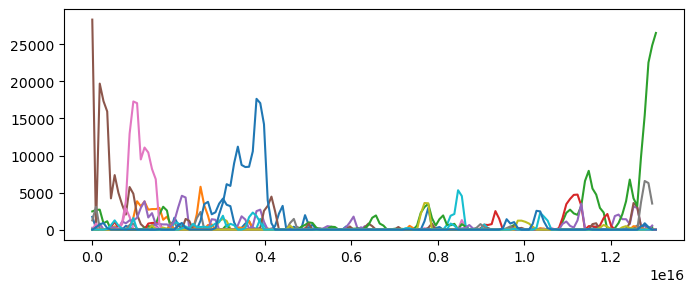

In [6]:
years = np.append(np.arange(2003,2012), np.arange(2013,2025))

fig, ax= plt.subplots(figsize=(8,3))


for year in years:
    
    time_range = slice(datetime(year-1, 12, 1), datetime(year, 4, 30,23))
    open_years = f'{time_range.start.year}_{time_range.stop.year}'
    DS = xr.open_dataset(f'./data/polynya_size/daily_polynya_{time_range.stop.year}_sic15_v1.nc')
    DS = DS.sel(time = time_range)
    
    plt.plot((DS.time - DS.time[0]), DS.extent)

In [25]:
#===============================================================

# 2016-2017
# time_range = slice(datetime(2016, 12, 1), datetime(2017, 4, 30,23))

# 2017-2018
time_range = slice(datetime(2017, 12, 1), datetime(2018, 4, 30,23))

# 2018-2019
# time_range = slice(datetime(2018, 12, 1), datetime(2019, 4, 30,23))

#===============================================================

#=============
mooring = 'M1'
#=============

open_years = f'{time_range.start.year}_{time_range.stop.year}'

# calculate projected ESE current component
# u_val = np.cos(157.5 * np.pi/180)
# v_val = np.sin(157.5 * np.pi/180)

DS = xr.open_dataset(f'./data/polynya_size/daily_polynya_{time_range.stop.year}_sic15_v1.nc')
DS = DS.sel(time = time_range)
DS['length'] = (DS['l_per95'] - DS['l_per5'])
# DS['length'] = DS['l_max'] - DS['l_min']


# ocean velocity
#-----------------
ds = xr.open_dataset(f"/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/{mooring}/{mooring}_hourly_ocean_currents_{open_years}.nc")
ds.close()
ds = ds.sel(time=time_range)
ds['se'] = vectors.comp_along_theta(ds.u, ds.v, 135*units('deg'))
ds['ne'] = vectors.comp_along_theta(ds.u, ds.v, (90+135)*units('deg'))
ds['speed'] = np.sqrt(ds.u**2+ ds.v**2)

# ocean temperature, sailinity
#-----------------------------
ds2 = xr.open_dataset(f"/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/{mooring}/{mooring}_hourly_tempsalinity_{open_years}.nc")
ds2.close()
ds2 = ds2.sel(time=time_range)

ds2['dT'] = ds2.Ct - ds2.Tf

# sea ice velocity
#------------------
ds3 = xr.open_dataset(f"/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/{mooring}/{mooring}_hourly_seaice_velocity_{open_years}.nc")
ds3.close()
ds3 = ds3.sel(depth=0, time=time_range)
ds3['se'] = vectors.comp_along_theta(ds3.u, ds3.v, 135*units('deg'))
ds3['speed'] = np.sqrt(ds3.u**2+ ds3.v**2)


ds6 = xr.open_dataset(f'./data/heat_flux/ohf_{time_range.stop.year}.nc')
ds6 = ds6.sel(time=time_range)
ds6.close()


icespeed = np.sqrt(ds3.u**2 + ds3.v**2)

u_sfc = ds3.u.values
v_sfc = ds3.v.values

scf_angle = vectors.vector_angle(u_sfc, v_sfc)



# u_norm = u_sfc / icespeed
# v_norm = v_sfc / icespeed

# u_perp = - v_norm
# v_perp = u_norm

along_sfc = vectors.comp_along_theta(ds.u, ds.v, scf_angle)
perp_sfc  = vectors.comp_along_theta(ds.u, ds.v, scf_angle + 90*units('deg'))


lat, lon = 70.5, -140 
ds4 = grab_atm(time_range, lat = lat, lon = lon)
ds4['speed'] = np.sqrt(ds4.u10**2+ ds4.v10**2)
ds4['se'] = vectors.comp_along_theta(ds4.u10, ds4.v10, 135*units('deg'))
# wind_along_sfc = (ds4.u10 * u_norm) + (ds4.v10 * v_norm)
# wind_perp_sfc = (ds4.u10 * -v_norm) + (ds4.v10 * u_norm)


In [9]:
wind_angle = vectors.vector_angle(ds4.u10.values, ds4.v10.values)
wind_speed = np.sqrt(ds4.u10.values**2 + ds4.v10.values**2)

wf = 0.015 * 10
ta = 20*units('deg')

exp_ice_u = wf * wind_speed * np.cos(wind_angle + ta)
exp_ice_v = wf * wind_speed * np.sin(wind_angle + ta)

exp_ice_se = vectors.comp_along_theta(exp_ice_u, exp_ice_v, 135*units('deg'))




In [10]:
open_times = np.array([], dtype='datetime64[ns]')
for time in pd.to_datetime(DS.time.values[DS.extent>0]):
    fullday = pd.date_range(time, time+timedelta(hours=23), freq='1H')
    open_times = np.append(open_times, fullday)
    
clos_times = np.array([], dtype='datetime64[ns]')
for time in pd.to_datetime(DS.time.values[DS.extent==0]):
    fullday = pd.date_range(time, time+timedelta(hours=23), freq='1H')
    clos_times = np.append(clos_times, fullday)

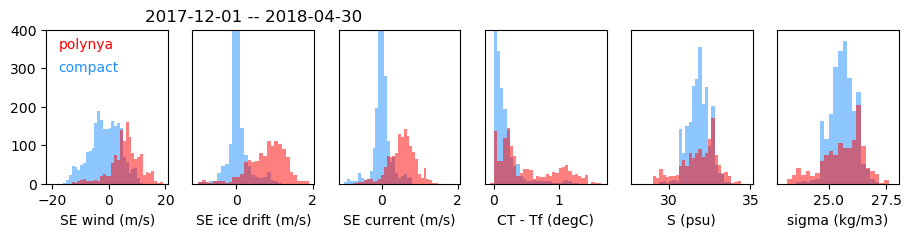

In [11]:
%matplotlib inline

fig, axs = plt.subplots(1,6, figsize=(11,2))

ax = axs[0]
ax.set_xlabel('SE wind (m/s)')
ax.set_ylim(0,400)
for event, color in zip([clos_times,open_times ], ['dodgerblue', 'r']):
    ax.hist(ds4.se.sel(time = event), bins=np.arange(-20,20,1), color=color, alpha=0.5)

ax = axs[1]
ax.set_xlabel('SE ice drift (m/s)')
ax.set_ylim(0,400)
ax.set_yticks([])
for event, color in zip([clos_times,open_times ], ['dodgerblue', 'r']):
    ax.hist(ds3.se.sel(time = event), bins=np.arange(-1,2,0.1), color=color, alpha=0.5)
    
ax.set_title(f"{time_range.start.date()} -- {time_range.stop.date()}")
ax = axs[2]
ax.set_xlabel('SE current (m/s)')
ax.set_ylim(0,400)
ax.set_yticks([])
for event, color in zip([clos_times,open_times ], ['dodgerblue', 'r']):
    ax.hist(ds.se.mean(dim='depth').sel(time = event), bins=np.arange(-1,2,0.075), color=color, alpha=0.5) 
    
ax = axs[3]
ax.set_xlabel('CT - Tf (degC)')
ax.set_ylim(0,400)
ax.set_yticks([])
for event, color in zip([clos_times,open_times ], ['dodgerblue', 'r']):
    ax.hist(ds2.dT.sel(depth=-16).sel(time = event), bins=np.arange(-0.05,1.7,0.05), color=color, alpha=0.5)
    
ax = axs[4]
ax.set_xlabel('S (psu)')
ax.set_ylim(0,400)
ax.set_yticks([])
for event, color in zip([clos_times,open_times ], ['dodgerblue', 'r']):
    ax.hist(ds2.Sp.sel(depth=-16).sel(time = event), bins=np.arange(28,35,0.2), color=color, alpha=0.5)
    
ax = axs[5]
ax.set_xlabel('sigma (kg/m3)')
ax.set_ylim(0,400)
ax.set_yticks([])
for event, color in zip([clos_times,open_times ], ['dodgerblue', 'r']):
    ax.hist(ds2.sig0.sel(depth=-16).sel(time = event), bins=np.arange(23,28,0.2), color=color, alpha=0.5)
    
ax = axs[0]
ax.text(0.1,0.95,'polynya', c='red', ha='left', va='top',transform=ax.transAxes)
ax = axs[0]
ax.text(0.1,0.8,'compact', c='dodgerblue', ha='left', va='top',transform=ax.transAxes)
    
fig.savefig('/Users/mackenziejewell/Desktop/img.png', dpi=300, bbox_inches='tight')

<IPython.core.display.Javascript object>


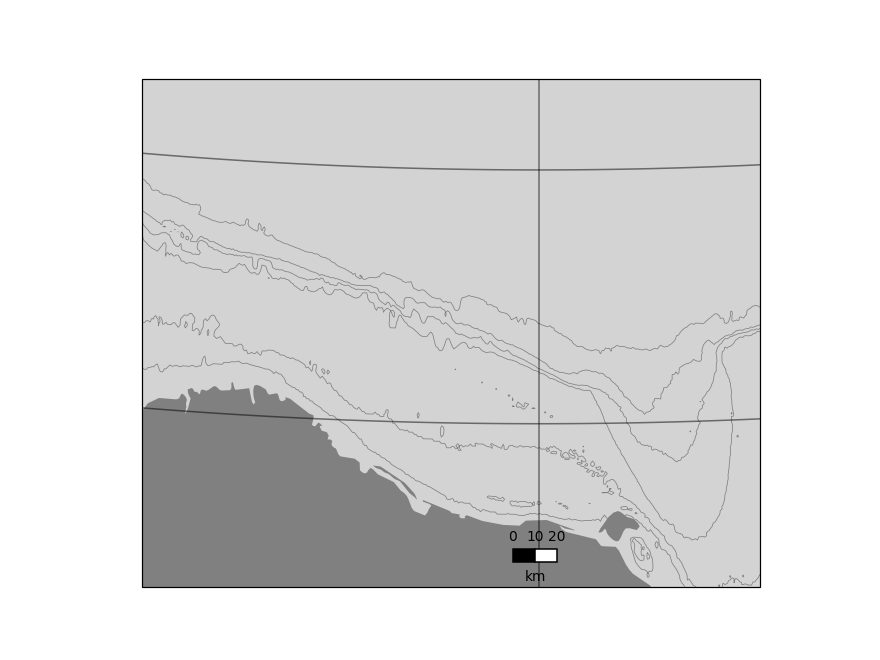

In [33]:

# wind
# U = 0.06 * np.array([ds4.u10.sel(time=event_time).mean(dim='time').values]) * units('m/s')
# V = 0.06 * np.array([ds4.v10.sel(time=event_time).mean(dim='time').values]) * units('m/s')
# tail, tip, vec = conv(map_proj, M1['lon'], M1['lat'], eastward = U, northward = V)
# ax.quiver(*tail, *vec, color='gray', pivot='tail', angles='xy', scale_units='xy', scale=1, zorder=4)
# ax.text(*tip, '6%', ha=label_side, color='k',)

# U = 0.02 * np.array([ds4.u10.sel(time=event_time).mean(dim='time').values]) * units('m/s')
# V = 0.02 * np.array([ds4.v10.sel(time=event_time).mean(dim='time').values]) * units('m/s')
# tail, tip, vec = conv(map_proj, M1['lon'], M1['lat'], eastward = U, northward = V)
# ax.quiver(*tail, *vec, color='gray', pivot='tail', angles='xy', scale_units='xy', scale=1, zorder=4)
# ax.text(*tip, '2% wind', ha=label_side, color='k',)

# # ice drift 
# Ui = np.array([ds3.u.sel(time=event_time).mean(dim='time').values]) * units('m/s')
# Vi = np.array([ds3.v.sel(time=event_time).mean(dim='time').values]) * units('m/s')
# tail, tip, vec = conv(map_proj, M1['lon'], M1['lat'], eastward = Ui, northward = Vi)
# ax.quiver(*tail, *vec, color=[0.2,0.2,0.2], pivot='tail', angles='xy', scale_units='xy', scale=1, zorder=3)
# ax.text(*tip, 'ice', ha=label_side, color='k',)

# # ocean currents
# color_list = cmocean.cm.deep(np.linspace(0.05,0.85,len(ds.depth.values)))
# for dd, depth in enumerate(ds.depth.values):
    
#     color = color_list[dd]
#     ffrac = np.sum(np.isfinite(ds.u.sel(depth = depth, time=event_time))).values / len(ds.time.sel(time=event_time).values)
    
#     if ffrac > 0.5:

        
#         U = np.array([ds.u.sel(depth = depth, time=event_time).mean(dim='time').values]) * units('m/s')
#         V = np.array([ds.v.sel(depth = depth, time=event_time).mean(dim='time').values]) * units('m/s')

#         tail, tip, vec = conv(map_proj, M1['lon'], M1['lat'], eastward = U, northward = V)
#         ax.quiver(*tail, *vec, color=color, pivot='tail', angles='xy', scale_units='xy', scale=1, zorder=2)
#         ax.text(*tip, f'{depth:.0f}', ha=label_side, color='k',)


In [1382]:
%matplotlib inline

event_dates = pd.date_range(datetime(2019,1,13), datetime(2019, 1, 20), freq='24H')

print(event_dates[0], event_dates[-1])

sic = UNISIC.open_local_file(event_dates[-1], res='6250', hem='n', main_path='/Volumes/Seagate_Jewell/KenzieStuff/', 
                      crop=[850,1250,150,350], coordinates=False, area=False, include_units=False, quiet=True)


drift = osidrift.open_local_file(event_dates[-1], main_path = '/Volumes/Seagate_Jewell/KenzieStuff/OSI-SAF/', 
                                 include_units = True)
drift['sp'] = np.sqrt(drift['u']**2+drift['v']**2)

# transform to map
out = map_proj.transform_points(drift['proj'], drift['xx0'], drift['yy0'])
drift['xx_proj'] = out[:,:,0]
drift['yy_proj'] = out[:,:,1]



# xxx = np.array([M1['xx']])
# yyy = np.array([M1['yy']])

xosi, yosi = drift['proj'].transform_point(M1['lon'], M1['lat'], ccrs.PlateCarree())
xxx_osi = np.array([xosi])
yyy_osi = np.array([yosi])

xosi, yosi = drift['proj'].transform_point(-135.1, 69.8, ccrs.PlateCarree())
xxx2_osi = np.array([xosi])
yyy2_osi = np.array([yosi])


2019-01-13 00:00:00 2019-01-20 00:00:00
!!! 2019/01/ice_drift_nh_polstere-625_multi-oi_201901191200-201901211200.nc not found in /Volumes/Seagate_Jewell/KenzieStuff/OSI-SAF/


TypeError: 'NoneType' object is not subscriptable

In [1383]:

for date in event_dates:
    
    drift = osidrift.open_local_file(date, main_path = '/Volumes/Seagate_Jewell/KenzieStuff/OSI-SAF/', 
                                 include_units = True)
    drift['sp'] = np.sqrt(drift['u']**2+drift['v']**2)
    

    # transform to map
    out = ccrs.PlateCarree().transform_points(drift['proj'], drift['xx0'], drift['yy0'])
    drift['lons'] = out[:,:,0]
    drift['lats'] = out[:,:,1]

    lon_range = (drift['lons'] < -140) & (drift['lons'] > -155)
    lat_range = (drift['lats'] < 73) & (drift['lats'] > 69.5)

    # advect ice along vector in osi projection
    u_loc = np.nanmean(drift['u'][lon_range&lat_range])
    v_loc = np.nanmean(drift['v'][lon_range&lat_range])

    dx_osi = u_loc.to('m/day') * units('day')
    dy_osi = v_loc.to('m/day') * units('day')

    
    xosi = xxx_osi[-1] + dx_osi.magnitude
    yosi = yyy_osi[-1] + dy_osi.magnitude 
    xxx_osi = np.append(xxx_osi, xosi)
    yyy_osi = np.append(yyy_osi, yosi)

    
    
    if date > datetime(2024,1,7):
        lon_range = (drift['lons'] < -133) & (drift['lons'] > -140)
        lat_range = (drift['lats'] < 71.5) & (drift['lats'] > 69)

        # advect ice along vector in osi projection
        u_loc = np.nanmean(drift['u'][lon_range&lat_range])
        v_loc = np.nanmean(drift['v'][lon_range&lat_range])

        dx_osi = u_loc.to('m/day') * units('day')
        dy_osi = v_loc.to('m/day') * units('day')

        xosi = xxx2_osi[-1] + dx_osi.magnitude
        yosi = yyy2_osi[-1] + dy_osi.magnitude 
        xxx2_osi = np.append(xxx2_osi, xosi)
        yyy2_osi = np.append(yyy2_osi, yosi)


!!! 2019/01/ice_drift_nh_polstere-625_multi-oi_201901121200-201901141200.nc not found in /Volumes/Seagate_Jewell/KenzieStuff/OSI-SAF/


TypeError: 'NoneType' object is not subscriptable

In [1483]:
def free_drift(event_dates, ref_proj = [], initial_loc = (-145,70), 
               latitude = slice(72, 70), longitude = slice(-145,-138), 
               ta = -20*units('degree'),  wf = 0.02, grab_local_winds = False, hourly = False):
    
    
    
    
    if hourly:
        
        dates = pd.date_range(event_dates[0], event_dates[-1], freq='1H')

        ds = xr.open_dataset(f'/Volumes/Jewell_EasyStore/ECMWF/annual/hourly/ERA5_{dates[-1].year}.nc')
        ds = ds.sel(latitude=latitude, longitude = longitude, time = dates)

        lons = np.array([initial_loc[0]])
        lats = np.array([initial_loc[1]])
        
        time_unit = 'hour'
        

    else:
        
        dates = pd.to_datetime(event_dates)

        ds = xr.open_dataset(f'/Volumes/Jewell_EasyStore/ECMWF/annual/daily/ERA5_{dates[-1].year}_daily.nc')
        ds = ds.sel(latitude=latitude, longitude = longitude, time = dates)

        lons = np.array([initial_loc[0]])
        lats = np.array([initial_loc[1]])
        
        time_unit = 'day'
        
        
    for dd in range(len(dates)):

        lon, lat = lons[-1], lats[-1]

        if grab_local_winds:
            
            
            longrid, latgrid = np.meshgrid(ds.longitude.values, ds.latitude.values)
            
            out = ref_proj.transform_points(ccrs.PlateCarree(), longrid, latgrid)
            geogrid_xx = out[:,:,0]
            geogrid_yy = out[:,:,1]
            
            pxx, pyy = map_proj.transform_point(*(lon,lat), ccrs.PlateCarree())
            
            distances = np.sqrt((geogrid_xx-pxx)**2+(geogrid_yy-pyy)**2)
    
            
            nearest_lon = longrid[np.where(distances == np.min(distances))]
            nearest_lat = latgrid[np.where(distances == np.min(distances))]
            
#             nearest_lon = ds.longitude.values[np.argmin(abs(ds.longitude.values - lon))]
#             nearest_lat = ds.latitude.values[np.argmin(abs(ds.latitude.values - lat))]

            uw = ds.u10.sel(time = dates[dd], longitude = nearest_lon, latitude = nearest_lat).values * units('m/s')
            vw = ds.v10.sel(time = dates[dd], longitude = nearest_lon, latitude = nearest_lat).values * units('m/s')

        else:
            
            uw = ds.u10.sel(time = dates[dd]).mean(dim=['latitude', 'longitude']).values * units('m/s')
            vw = ds.v10.sel(time = dates[dd]).mean(dim=['latitude', 'longitude']).values * units('m/s')


        # convert to expected ice drift
        ui, vi = vectors.rotate_vector(wf*uw, wf*vw, ta)
        ice_angles = vectors.vector_angle(ui, vi)
    
        
        tail, tip, vec = vectors.project_vectors(map_proj, lon, lat, 
                                                 eastward = ui, northward = vi, 
                                                 final_units=f'm/{time_unit}')
        
        lon, lat = ccrs.PlateCarree().transform_point(*tip, map_proj)
        lons = np.append(lons, lon)
        lats = np.append(lats, lat)
    
    return dates, lons, lats

#     xx_se = np.array([M1['xx']])
#     yy_se = np.array([M1['yy']])

In [2103]:
%matplotlib inline

event_dates = pd.date_range(datetime(2014,1,1), datetime(2014, 1, 7), freq='24H')

print(event_dates[0], event_dates[-1])

sic = UNISIC.open_local_file(event_dates[-1], res='6250', hem='n', main_path='/Volumes/Seagate_Jewell/KenzieStuff/', 
                      crop=[850,1250,150,350], coordinates=False, area=False, include_units=False, quiet=True)


points = {}

points[0] = {}
points[0]['initial'] = (M1['lon'],M1['lat'])

points[1] = {}
points[1]['initial'] = (-135.1, 69.8)

points[2] = {}
points[2]['initial'] = (-136, 69.66)

points[3] = {}
points[3]['initial'] = (-139.25, 69.65)


for ii in points.keys():
    
    dates, lons, lats = free_drift(event_dates, 
                            initial_loc = points[ii]['initial'], 
                            ref_proj = map_proj, 
                            latitude = slice(73, 69),
                            longitude = slice(-155,-133), 
                            ta = -20*units('degree'),  wf = 0.03,
                           grab_local_winds = True, hourly = True)

    points[ii]['lons'] = lons
    points[ii]['lats'] = lats
    points[ii]['dates'] = dates

for ii in points.keys():
    
    out = map_proj.transform_points(ccrs.PlateCarree(), points[ii]['lons'], points[ii]['lats'])
    points[ii]['xx'] = out[:,0]
    points[ii]['yy'] = out[:,1]
    
    
ii = 0
wind_ds = np.sqrt((points[ii]['xx'] - points[ii]['xx'][0])**2+(points[ii]['yy'] - points[ii]['yy'][0])**2)


2014-01-01 00:00:00 2014-01-07 00:00:00


<IPython.core.display.Javascript object>


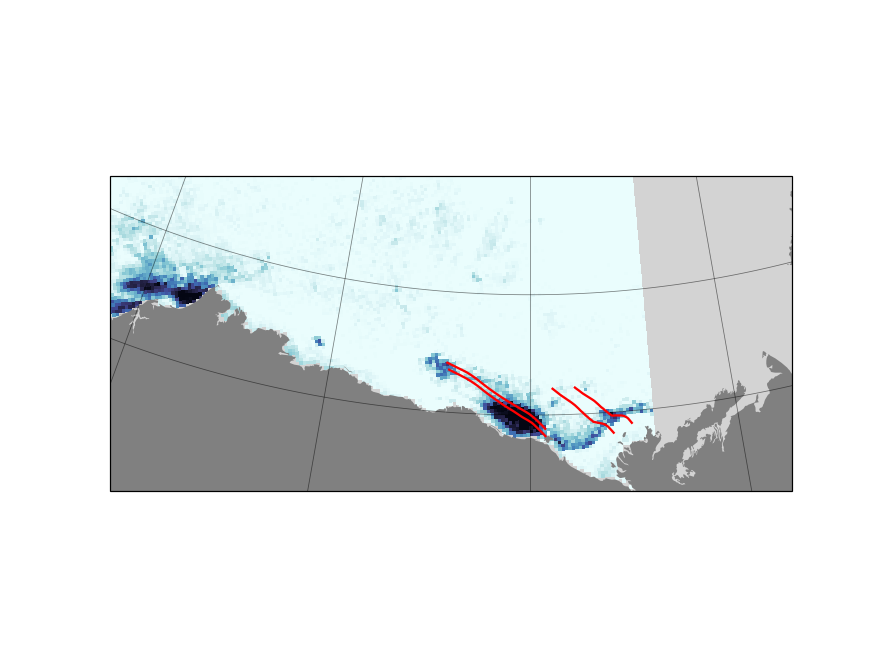

In [2104]:
%matplotlib notebook

fig, ax = plt.subplots(subplot_kw=dict(projection=map_proj), figsize=(8,6))

# ax.set_xlim(-500000,100000)
# ax.set_ylim(-2330000,-1800000)

ax.set_xlim(-800000,500000)
ax.set_ylim(-2400000,-1800000)
ax.set_facecolor('lightgray')
geomap.land(ax, scale = '10m', color='gray', alpha=1, fill_dateline_gap = True, zorder=2)
geomap.grid(ax, lats = np.arange(70,75,2), lons = np.arange(200,250,10) , color='k', linewidth=0.5)

# geomap.scalebar(ax, loc=(0.2, 0.1), stepsize=100, numsteps=3, unit='km', label=None, 
#                 colors=['k', 'w'], edgecolor=None, textsize=9, lw=1, bar_width=0.025,
#                 labelpad=0.015, ticklabelpad=0.01, zorder=100)

# label_side = 'left'

# geomap.gebco_bathymetry(ax, file_path='/Volumes/Seagate_Jewell/KenzieStuff/GEBCO/GEBCO_2024/gebco_2024_n90.0_s55.0_w-180.0_e180.0.nc', 
#                         crop_lat=(69, 71), crop_lon=(-147, -135), clat=2, clon=5, 
#                         contour_labels=False,
#                         contour_levels=[-500,-300,-200,-100,  -40,-20],
#                         contour_kwargs={'colors': 'gray', 'linewidths': 0.5, 'linestyles': 'solid', 'zorder': 1},
#                         depth_shade=False)


mesh = ax.pcolormesh(sic['xx'], sic['yy'], sic['sic'], vmin=0, vmax=100, cmap=cmocean.cm.ice, transform=sic['proj'])

for ii in points.keys():
    ax.plot(points[ii]['lons'], 
            points[ii]['lats'], c='r', transform=ccrs.PlateCarree(), zorder=100)


In [2106]:
DS = xr.open_dataset(f'./data/polynya_size/daily_polynya_{event_dates[-1].year}_sic15_v1.nc')
# event_dates = pd.date_range(datetime(2023,12,31), datetime(2024, 1, 20), freq='24H')
DS = DS.sel(time = event_dates)
DS['length'] = (DS['l_max'] - DS['l_min'])
# DS['length'] = (DS['l_per95'] - DS['l_per5'])

# DS['length'] = (DS['extent'])/(DS['w_per95'] - DS['w_per5'])
# DS['length'][DS['extent']==0]=0
DS.length

<xarray.DataArray 'length' (time: 7)>
array([220.05455969, 136.40669869,  99.76383425, 119.77676511,
       157.12443582,  99.52406184,  94.55109646])
Coordinates:
  * time     (time) datetime64[ns] 2014-01-01 2014-01-02 ... 2014-01-07

<IPython.core.display.Javascript object>


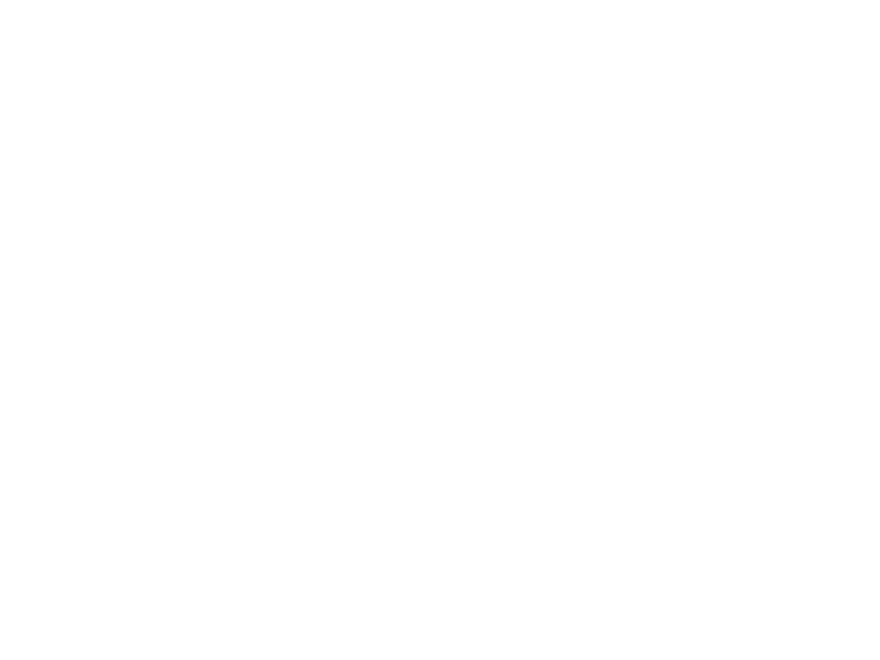

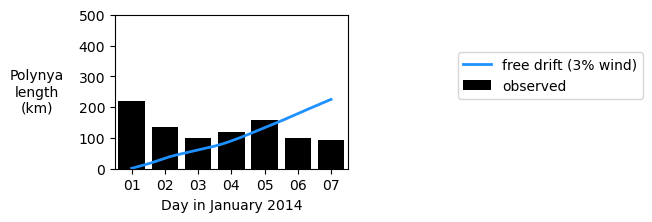

In [2107]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(3,2))

# ax.plot(np.sqrt(dx**2+dy**2)/1000)
ax.set_ylabel('Polynya\nlength\n(km)', rotation=0, labelpad=30, va='center')
plt.ylim(0,500)
ax.bar(event_dates, DS.length, color='k', label='observed')
ax.plot(points[0]['dates'], wind_ds[1:]/1000, c='dodgerblue', lw=2, label='free drift (3% wind)')
# ax.plot(event_dates, dist_osi[1:]/1000, c='skyblue', lw=2, label='OSI-SAF pack ice drift')

ax.set_xlim(event_dates[0]-timedelta(hours=12), event_dates[-1]+timedelta(hours=12))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d'))
ax.set_xlabel(f'Day in January {event_dates[-1].year}')
plt.legend(bbox_to_anchor=(2.3,0.8))


fig.savefig(f'./figures/overview/polynalength_{event_dates[-1].year}.png', dpi=300, bbox_inches='tight', pad_inches=0)


In [2288]:
sys.path.append('../Libraries_functions/')
from LIB_MODIS_IST_N1kmNIGHT import grab_MODIS_IST

date = datetime(2019,1,13)
# date = datetime(2024,1,9)

In [2289]:
# IST
#----
file_path = f'/Volumes/Seagate_Jewell/KenzieStuff/MODIS_IST_1km_night/{date.strftime("%Y.%m")}/'
ist = grab_MODIS_IST(date, file_path = file_path)

ist['ist_c'] = (ist['ist'] - 273.15)
ist['ist_f'] = (ist['ist_c'] - (-1.7))

In [2290]:
sic = UNISIC.open_local_file(date, res='3125', hem='n', main_path='/Volumes/Seagate_Jewell/KenzieStuff/', 
                      crop=[1600,2000,450,750], coordinates=True, area=False, include_units=False, quiet=True)
sic['lon'][sic['lon']>180]-=360

In [2291]:
sources = {}

sources['hip'] = {}
sources['hip']['lon_range'] = np.array([-139.8, -138.9])
sources['hip']['lat_range'] = np.array([69.5, 69.7])

sources['tuk'] = {}
sources['tuk']['lon_range'] = np.array([-138, -132.5])
sources['tuk']['lat_range'] = np.array([69.1, 70.1])


def find_open_water(sic, sources, sic_thresh = 5):
    
    source_points = {}
    
    for loc in sources.keys():
        
        within_lon = (sic['lon'] > sources[loc]['lon_range'].min()) & (sic['lon'] < sources[loc]['lon_range'].max())
        within_lat = (sic['lat'] > sources[loc]['lat_range'].min()) & (sic['lat'] < sources[loc]['lat_range'].max())
        within_region = within_lon&within_lat
        
        open_water = sic['sic'] < sic_thresh
        

        source_points[loc] = {}
        source_points[loc]['lon'] = sic['lon'][within_region&open_water]
        source_points[loc]['lat'] = sic['lat'][within_region&open_water]
    
    return source_points
    
source_points = find_open_water(sic, sources, sic_thresh = 5)


<IPython.core.display.Javascript object>


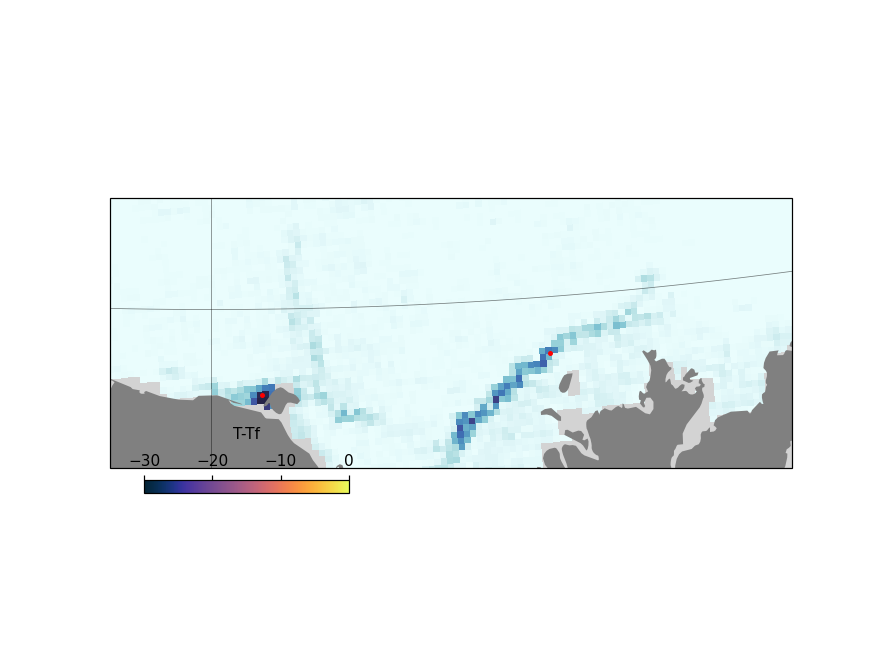

(<matplotlib.colorbar.Colorbar at 0x16c3dfd70>, <Axes: xlabel='T-Tf'>)

In [2327]:
pts = {}

pts['hip'] = {}
pts['hip'][0] = {}
pts['hip'][0]['initial'] = (-139.35,69.62)
pts['hip'][0]['wf'] = 0.03

pts['tuk'] = {}
pts['tuk'][0] = {}
pts['tuk'][0]['initial'] = (-135.67,69.75)
pts['tuk'][0]['wf'] = 0.02

pts['tuk'][1] = {}
pts['tuk'][1]['initial'] = (-136.5,69.53)
pts['tuk'][1]['wf'] = 0.02

event_dates = pd.date_range(datetime(2019,1,13,0), datetime(2019,1,18))




In [2604]:
pts = {}

pts['hip'] = {}
pts['hip'][0] = {}
pts['hip'][0]['initial'] = (-139.35,69.62)
pts['hip'][0]['wf'] = 0.05

pts['tuk'] = {}
pts['tuk'][0] = {}
pts['tuk'][0]['initial'] = (-136.25, 69.5)
pts['tuk'][0]['wf'] = 0.04

pts['tuk'][1] = {}
pts['tuk'][1]['initial'] = (-136.58, 69.45)
pts['tuk'][1]['wf'] = 0.04

pts['tuk'][2] = {}
pts['tuk'][2]['initial'] = (-135.5, 69.66)
pts['tuk'][2]['wf'] = 0.04


event_dates = pd.date_range(datetime(2018,1,8,12), datetime(2018,1,10,12))


In [2605]:


for loc in pts.keys():
    
    for ii in pts[loc].keys():

        dates, lons, lats = free_drift(event_dates, 
                                        initial_loc = pts[loc][ii]['initial'], 
                                        ref_proj = map_proj, 
                                        latitude = slice(73, 69),
                                        longitude = slice(-155,-133), 
                                        ta = -20*units('degree'),  wf = pts[loc][ii]['wf'],
                                       grab_local_winds = True, hourly = True)

        pts[loc][ii]['lons'] = lons
        pts[loc][ii]['lats'] = lats
        pts[loc][ii]['dates'] = dates

    for ii in pts[loc].keys():

        out = map_proj.transform_points(ccrs.PlateCarree(), pts[loc][ii]['lons'], pts[loc][ii]['lats'])
        pts[loc][ii]['xx'] = out[:,0]
        pts[loc][ii]['yy'] = out[:,1]

        pts[loc][ii]['dist'] = np.sqrt((pts[loc][ii]['xx'] - pts[loc][ii]['xx'][0])**2+(pts[loc][ii]['yy'] - pts[loc][ii]['yy'][0])**2) / 1000
    
    
    
date = event_dates[-1]

# SIC 
#----
sic = UNISIC.open_local_file(date, res='3125', hem='n', main_path='/Volumes/Seagate_Jewell/KenzieStuff/', 
                      crop=[1600,2000,450,750], coordinates=True, area=False, include_units=False, quiet=True)
sic['lon'][sic['lon']>180]-=360


# IST
#----
file_path = f'/Volumes/Seagate_Jewell/KenzieStuff/MODIS_IST_1km_night/{date.strftime("%Y.%m")}/'
ist = grab_MODIS_IST(date, file_path = file_path)

ist['ist_c'] = (ist['ist'] - 273.15)
ist['ist_f'] = (ist['ist_c'] - (-1.7))

In [2606]:
date = event_dates[-1]

# SIC 
#----
sic = UNISIC.open_local_file(date, res='3125', hem='n', main_path='/Volumes/Seagate_Jewell/KenzieStuff/', 
                      crop=[1600,2000,450,750], coordinates=True, area=False, include_units=False, quiet=True)
sic['lon'][sic['lon']>180]-=360


# IST
#----
file_path = f'/Volumes/Seagate_Jewell/KenzieStuff/MODIS_IST_1km_night/{date.strftime("%Y.%m")}/'
ist = grab_MODIS_IST(date, file_path = file_path)

ist['ist_c'] = (ist['ist'] - 273.15)
ist['ist_f'] = (ist['ist_c'] - (-1.7))

In [3163]:
date = datetime(2018, 1, 10)

# SIC 
#----
sic = UNISIC.open_local_file(date, res='3125', hem='n', main_path='/Volumes/Seagate_Jewell/KenzieStuff/', 
                      crop=[1600,2000,450,750], coordinates=True, area=False, include_units=False, quiet=True)
sic['lon'][sic['lon']>180]-=360


# IST
#----
file_path = f'/Volumes/Seagate_Jewell/KenzieStuff/MODIS_IST_1km_night/{date.strftime("%Y.%m")}/'
ist = grab_MODIS_IST(date, file_path = file_path)

ist['ist_c'] = (ist['ist'] - 273.15)
ist['ist_f'] = (ist['ist_c'] - (-1.7))

<IPython.core.display.Javascript object>


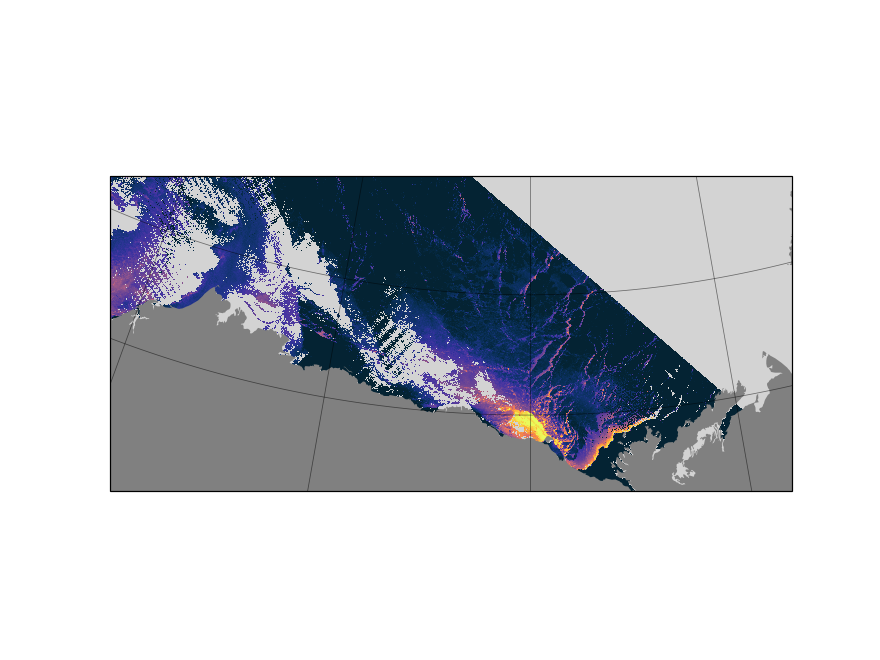

In [3164]:


%matplotlib notebook

fig, ax = plt.subplots(subplot_kw=dict(projection=map_proj), figsize=(8,6))

# ax.set_xlim(-500000,100000)
# ax.set_ylim(-2330000,-1800000)

ax.set_xlim(-800000,500000)
ax.set_ylim(-2400000,-1800000)
ax.set_facecolor('lightgray')
geomap.land(ax, scale = '10m', color='gray', alpha=1, fill_dateline_gap = True, zorder=2)
geomap.grid(ax, lats = np.arange(70,75,2), lons = np.arange(200,250,10) , color='k', linewidth=0.5)



ii = (670,680)
jj = (910,930)
ref_T = np.nanpercentile(ist['ist_c'][ii[0]:ii[1],jj[0]:jj[1]], 90)
# ax.scatter(ist['xx'][ii[0]:ii[1],jj[0]:jj[1]], 
#            ist['yy'][ii[0]:ii[1],jj[0]:jj[1]], transform=ist['proj'])


ax.pcolormesh(ist['xx'],ist['yy'],ist['ist_c']-ref_T, vmin=-20, vmax=0, cmap=cmocean.cm.thermal, transform=ist['proj'])


In [3165]:
ref_T

-2.9489999999999896

In [3150]:
np.nanmean(ist['ist_c'][ii[0]:ii[1],jj[0]:jj[1]])

-5.543030303030275

In [3126]:
ist['xx'].shape

(951, 1902)

In [3124]:
ist.keys()

dict_keys(['xx', 'yy', 'ist', 'proj', 'ist_c', 'ist_f'])

In [2882]:
track_T = {}

for loc in pts.keys():
    track_T[loc] = {}
    
    for ii in pts[loc].keys():
        track_T[loc][ii] = {}
        
        
for loc in pts.keys():     
    print(loc)
    
    for ii in pts[loc].keys():
        
        track_T[loc][ii] = grab_local_t(ist, pts[loc][ii]['lons'], pts[loc][ii]['lats'], max_dist = max_dist)
   

hip
tuk


In [2883]:
def grab_local_t(ist, plons, plats, max_dist = 5):
    
    # max_dist has units km
    
    out = ist['proj'].transform_points(ccrs.PlateCarree(), plons, plats)
    pts_xx = out[:,0]
    pts_yy = out[:,1]
    
    temps = {}
    temps['N'] = np.array([])
    temps['min'] = np.array([])
    temps['max'] = np.array([])
    temps['mean'] = np.array([])
    temps['std'] = np.array([])
    temps['per5'] = np.array([])
    temps['per25'] = np.array([])
    temps['per50'] = np.array([])
    temps['per75'] = np.array([])
    temps['per95'] = np.array([])
    
    for ss in range(len(pts_xx)):

        # distance in units of km
        distances = np.sqrt((ist['xx'] - pts_xx[ss])**2 + (ist['yy'] - pts_yy[ss])**2) / 1000
        temps_in_range = ist['ist_c'][distances < max_dist]
    
    
        temps['N'] = np.append(temps['N'], len(temps_in_range))
        temps['mean'] = np.append(temps['mean'], np.nanmean(temps_in_range))
        temps['std'] = np.append(temps['std'], np.nanstd(temps_in_range))
        temps['min'] = np.append(temps['min'], np.nanmin(temps_in_range))
        temps['max'] = np.append(temps['max'], np.nanmax(temps_in_range))
        
        temps['per5'] = np.append(temps['per5'], np.nanpercentile(temps_in_range, 5))
        temps['per25'] = np.append(temps['per25'], np.nanpercentile(temps_in_range, 25))
        temps['per50'] = np.append(temps['per50'], np.nanpercentile(temps_in_range, 50))
        temps['per75'] = np.append(temps['per75'], np.nanpercentile(temps_in_range, 75))
        temps['per95'] = np.append(temps['per95'], np.nanpercentile(temps_in_range, 95))

    return temps


In [2610]:
check_dates = [datetime(2019,1,13), datetime(2019,1,14), datetime(2019,1,16), datetime(2019,1,17), datetime(2019,1,18)]


daily_temps = {}

for loc in pts.keys():
    daily_temps[loc] = {}
    
    for ii in pts[loc].keys():
        daily_temps[loc][ii] = {}
        
        for date in check_dates:
            daily_temps[loc][ii][date] = {}

In [2559]:

for date in check_dates:
    
    print(date)
    
    # IST
    #----
    file_path = f'/Volumes/Seagate_Jewell/KenzieStuff/MODIS_IST_1km_night/{date.strftime("%Y.%m")}/'
    ist = grab_MODIS_IST(date, file_path = file_path)
    ist['ist_c'] = (ist['ist'] - 273.15)
    
    
    for loc in pts.keys():     
        for ii in pts[loc].keys():
            daily_temps[loc][ii][date] = grab_local_t(ist, pts[loc][ii]['lons'], pts[loc][ii]['lats'], max_dist = max_dist)
    

2019-01-13 00:00:00


/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_34639/2191125520.py:29: RuntimeWarning: Mean of empty slice
  temps['mean'] = np.append(temps['mean'], np.nanmean(temps_in_range))
/opt/anaconda3/envs/SBSpolynya/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_34639/2191125520.py:31: RuntimeWarning: All-NaN slice encountered
  temps['min'] = np.append(temps['min'], np.nanmin(temps_in_range))
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_34639/2191125520.py:32: RuntimeWarning: All-NaN slice encountered
  temps['max'] = np.append(temps['max'], np.nanmax(temps_in_range))
/opt/anaconda3/envs/SBSpolynya/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


2019-01-14 00:00:00
2019-01-16 00:00:00
2019-01-17 00:00:00
2019-01-18 00:00:00


<IPython.core.display.Javascript object>


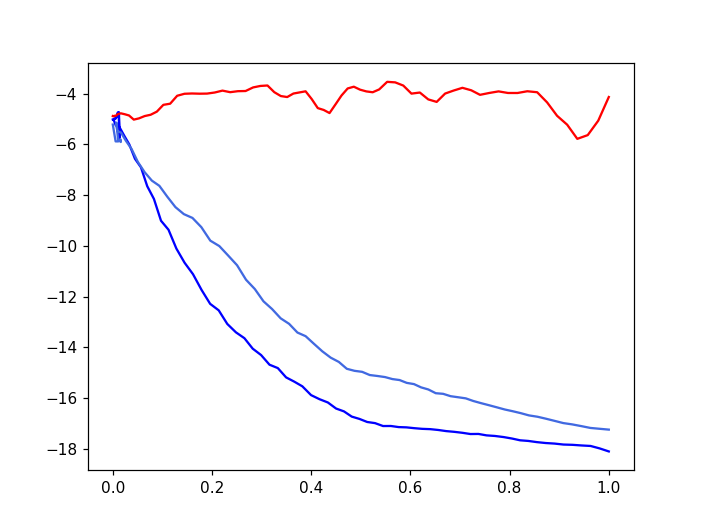

2019-01-16 00:00:00


In [2582]:

fig, ax = plt.subplots()

for dd, date in enumerate([check_dates[-3]]):
    
    print(date)
    
    loc = 'tuk'
    ii = 0
    
    date_s = np.where(pts[loc][ii]['dates'] == date)[0][0]
    loc_temps = daily_temps[loc][ii][date]
    x = pts[loc][ii]['dist'][:date_s]
    ax.plot(x/np.max(x), loc_temps['mean'][:date_s], c='b')
    
    
    loc = 'tuk'
    ii = 1
    
    date_s = np.where(pts[loc][ii]['dates'] == date)[0][0]
    loc_temps = daily_temps[loc][ii][date]
    x = pts[loc][ii]['dist'][:date_s]
    ax.plot(x/np.max(x), loc_temps['mean'][:date_s], c='royalblue')

    
    loc = 'hip'
    ii = 0
    
    date_s = np.where(pts[loc][ii]['dates'] == date)[0][0]
    loc_temps = daily_temps[loc][ii][date]
    x = pts[loc][ii]['dist'][:date_s]
    ax.plot(x/np.max(x), loc_temps['mean'][:date_s], c='r')

    
#     loc = 'tuk'
#     ii = 1
    
#     date_s = np.where(pts[loc][ii]['dates'] == date)[0][0]
#     loc_temps = daily_temps[loc][ii][date]
#     x = pts[loc][ii]['dist'][:date_s]
#     ax.plot(x, loc_temps['mean'][:date_s], c='royalblue')
    
#     temp = loc_temps['mean'][date_s - 23]
#     ax.scatter(date, temp, c='r')

In [2563]:
x

array([], dtype=float64)

<IPython.core.display.Javascript object>


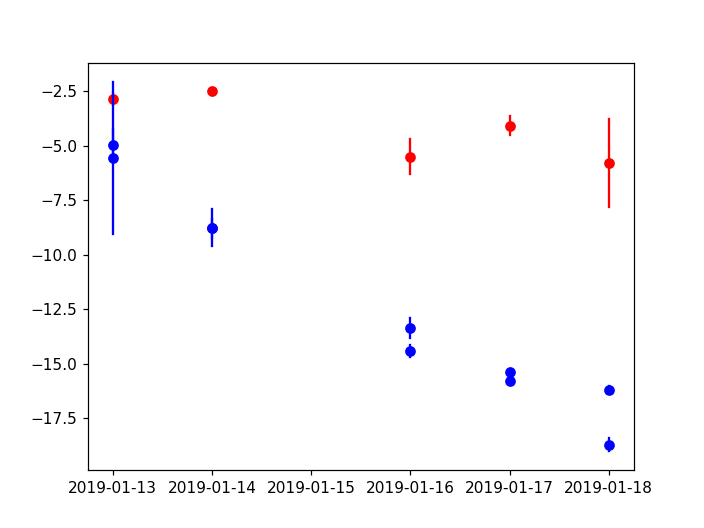

In [2516]:
fig, ax = plt.subplots()

for date in check_dates:
    
    # IST
    #----
    file_path = f'/Volumes/Seagate_Jewell/KenzieStuff/MODIS_IST_1km_night/{date.strftime("%Y.%m")}/'
    ist = grab_MODIS_IST(date, file_path = file_path)

    ist['ist_c'] = (ist['ist'] - 273.15)
    ist['ist_f'] = (ist['ist_c'] - (-1.7))
    
    
    loc = 'hip'
    ii = 0
    temp = track_T[loc][ii]['mean'][np.where(pts[loc][ii]['dates'] == date)[0][0]]
    tempstd = track_T[loc][ii]['std'][np.where(pts[loc][ii]['dates'] == date)[0][0]]

    ax.scatter(date, temp, c='r')
    ax.plot([date, date], [temp-tempstd, temp+tempstd], c='r')
    
    
    loc = 'tuk'
    ii = 0
    temp = track_T[loc][ii]['mean'][np.where(pts[loc][ii]['dates'] == date)[0][0]]
    tempstd = track_T[loc][ii]['std'][np.where(pts[loc][ii]['dates'] == date)[0][0]]
    
    ax.scatter(date, temp, c='b')
    ax.plot([date, date], [temp-tempstd, temp+tempstd], c='b')
    
    loc = 'tuk'
    ii = 1
    temp = track_T[loc][ii]['mean'][np.where(pts[loc][ii]['dates'] == date)[0][0]]
    tempstd = track_T[loc][ii]['std'][np.where(pts[loc][ii]['dates'] == date)[0][0]]
    
    ax.scatter(date, temp, c='b')
    ax.plot([date, date], [temp-tempstd, temp+tempstd], c='b')

In [2487]:
check_dates

[datetime.datetime(2019, 1, 13, 0, 0),
 datetime.datetime(2019, 1, 14, 0, 0),
 datetime.datetime(2019, 1, 16, 0, 0),
 datetime.datetime(2019, 1, 17, 0, 0),
 datetime.datetime(2019, 1, 18, 0, 0)]

<IPython.core.display.Javascript object>


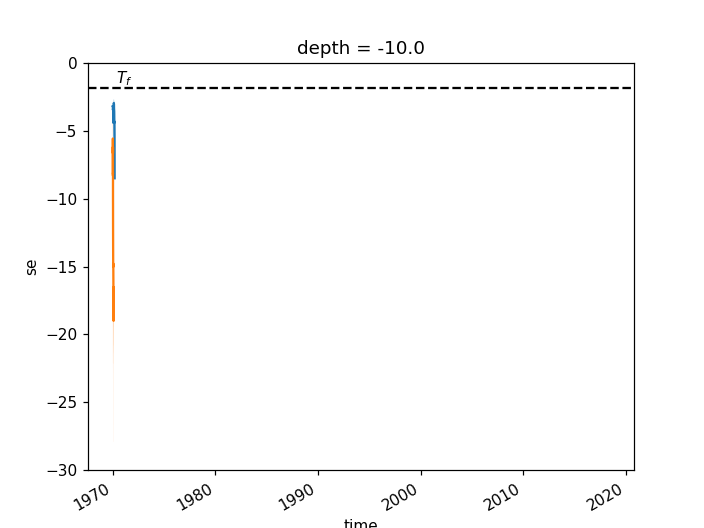

(-30.0, 0.0)

In [2613]:
fig, ax = plt.subplots()

ax.axhline(-1.8, c='k', ls='dashed')
ax.text(100, -1.8, '$T_{f}$', va='bottom')

loc = 'hip'
ii = 0
x = pts[loc][ii]['dist']#/np.max(pts[loc][ii]['dist'])
plt.fill_between(x, track_T[loc][ii]['min'], track_T[loc][ii]['max'], alpha=0.5)
plt.plot(x, track_T[loc][ii]['mean'])


loc = 'tuk'
ii = 0
x = pts[loc][ii]['dist']#/np.max(pts[loc][ii]['dist'])
plt.fill_between(x, track_T[loc][ii]['min'], track_T[loc][ii]['max'], alpha=0.5)
plt.plot(x, track_T[loc][ii]['mean'])

# loc = 'tuk'
# ii = 1
# x = pts[loc][ii]['dist']/np.max(pts[loc][ii]['dist'])
# plt.fill_between(x, track_T[loc][ii]['min'], track_T[loc][ii]['max'], alpha=0.5)
# plt.plot(x, track_T[loc][ii]['mean'])

plt.ylim(-30,0)

In [2634]:
ds

<xarray.Dataset>
Dimensions:  (depth: 8, time: 8761)
Coordinates:
  * depth    (depth) float64 -162.0 -143.0 -126.0 -109.0 -91.0 -74.0 -57.0 -40.0
  * time     (time) datetime64[ns] 2017-10-01 2017-10-01T01:00:00 ... 2018-10-01
Data variables:
    T        (depth, time) float64 ...
    Sp       (depth, time) float64 ...
    Sa       (depth, time) float64 ...
    Ct       (depth, time) float64 ...
    Tf       (depth, time) float64 ...
    sig0     (depth, time) float64 ...
Attributes:
    lat:      69.9088
    lon:      -138.9986

In [2629]:

dT = 1*units('delta_degC')
dz = 16 * units('m') 

u = 1 * units('m/s')

HF = ((cst['Cp_o'] * cst['rho_o'] * dT * dz) * u  / ).to('W/m2')

(HF / (cst['L_i']*cst['rho_i'])).to_base_units()

<Quantity(0.0129222471, 'meter / second')>

In [2632]:
cst['Cp_o'] * cst['rho_o'] * dT * dz * u

<Quantity(63324800.0, 'joule / meter / second')>

In [2633]:
cst['Cp_o']

<Quantity(3850.0, 'joule / kilogram / delta_degree_Celsius')>

In [2630]:
cst['Cp_o'] * cst['rho_o'] * dT * dz

<Quantity(63324800.0, 'joule / meter ** 2')>

In [3190]:
# ocean velocity
#-----------------
# mooring = 'M2'

# time_range = slice(datetime(2018, 12, 1), datetime(2019, 2, 15,23))
# time_range = slice(datetime(2017, 12, 1), datetime(2018, 1, 30,23))
time_range = slice(datetime(2016, 12, 1), datetime(2017, 3, 30,23))


open_years = f'{time_range.start.year}_{time_range.stop.year}'

mooring = 'M1'
ds = xr.open_dataset(f"/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/{mooring}/{mooring}_hourly_ocean_currents_{open_years}.nc")
ds.close()
ds = ds.sel(time=time_range)
ds['se'] = vectors.comp_along_theta(ds.u, ds.v, 135*units('deg'))
ds['ne'] = vectors.comp_along_theta(ds.u, ds.v, (90+135)*units('deg'))
ds['speed'] = np.sqrt(ds.u**2+ ds.v**2)

# ocean temperature, sailinity
#-----------------------------
mooring = 'M1'
ds2 = xr.open_dataset(f"/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/{mooring}/{mooring}_hourly_tempsalinity_{open_years}.nc")
ds2.close()
ds2 = ds2.sel(time=time_range)
ds2['dT'] = ds2.Ct - ds2.Tf


DS = xr.open_dataset(f'./data/polynya_size/daily_polynya_{time_range.stop.year}_sic15_v1.nc')
DS = DS.sel(time = time_range)
DS['length'] = (DS['l_per95'] - DS['l_per5'])

<IPython.core.display.Javascript object>


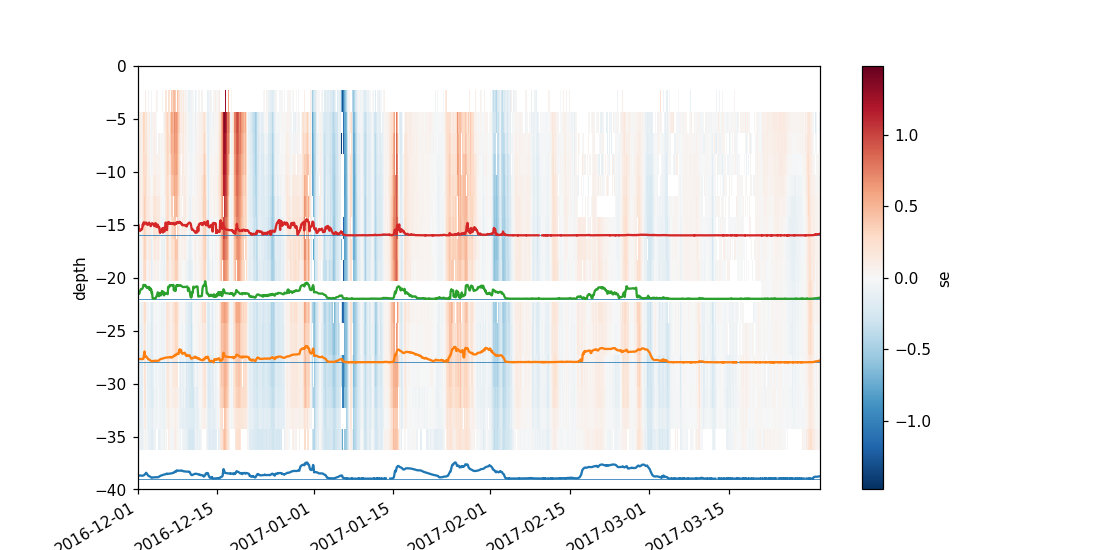

-39.0
-28.0
-22.0
-16.0


(-40.0, 0.0)

In [3191]:
fig, ax = plt.subplots(figsize=(10,5))

ds.se.plot(ax=ax)

for depth in ds2.depth.values:
    print(depth)
    ax.axhline(depth, lw=0.5)
    ax.plot(ds2.time, depth+ ds2.sel(depth=depth).dT.values)
    
    

    
ax.bar(DS.time, DS.extent/100, align='edge', color='k')

ax.set_ylim(-40,0)

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(8,4))

for ax in axs:
    size = 50
    ax.set_ylim(-0.1*size,size)
    ax.set_xlim(-size,0.1*size)

ax = axs[0]
D = -10
ax.plot(np.cumsum(ds.u.sel(depth=D)), np.cumsum(ds.v.sel(depth=D)), lw=0.5, c='k')
ax.scatter(np.cumsum(ds.u.sel(depth=D)), np.cumsum(ds.v.sel(depth=D)), 
         c= ds2.dT.sel(depth=-16).values, vmin=0, vmax=1.5, cmap=cmocean.cm.thermal)

ax = axs[1]
D = -30
ax.plot(np.cumsum(ds.u.sel(depth=D)), np.cumsum(ds.v.sel(depth=D)), lw=0.5, c='k')
ax.scatter(np.cumsum(ds.u.sel(depth=D)), np.cumsum(ds.v.sel(depth=D)), 
         c= ds2.dT.sel(depth=-36).values, vmin=0, vmax=1.5, cmap=cmocean.cm.thermal)

<IPython.core.display.Javascript object>


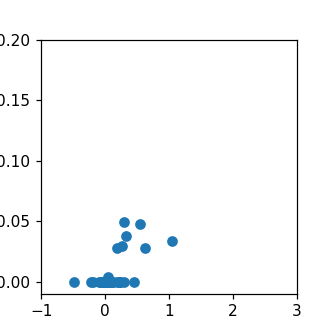

(-1.0, 3.0)

In [3194]:
fig, ax = plt.subplots(figsize=(3,3))

DT = ds2.dT.sel(depth=-16)
V = ds.se.sel(depth=-9.3)

ax.scatter((DT*V)[::24], DS.length/1000)

ax.set_ylim(-0.01,0.2)
ax.set_xlim(-1,3)

<IPython.core.display.Javascript object>


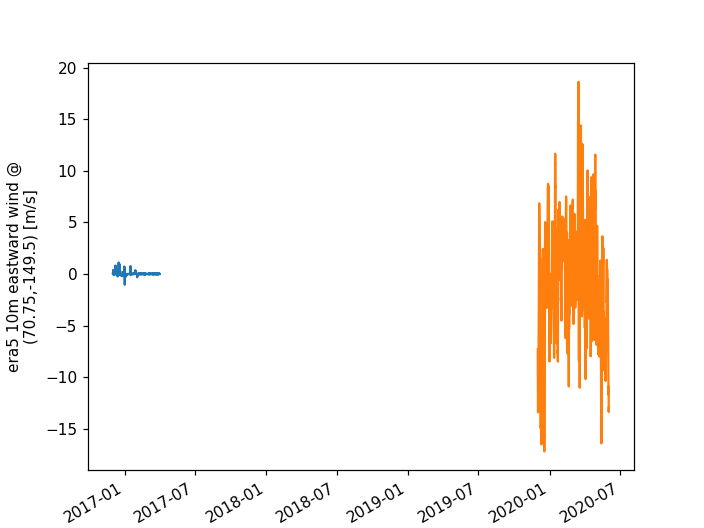

<BarContainer object of 120 artists>

In [3197]:
%matplotlib notebook

fig, ax = plt.subplots()
# np.cumsum(ds.ne.sel(depth=-143).plot())
# np.cumsum(ds.ne.sel(depth=-142.3).plot())

DT = ds2.dT.sel(depth=-16)
V = ds.se.sel(depth=-9.3)
(DT*V).plot()


# DT = ds2.dT.sel(depth=-28)
# V = ds.se.sel(depth=-30)
# (DT*V).plot()
    
ax.bar(DS.time, DS.length/100, align='edge', color='k')




# plt.plot(ds2.time, ds2.sel(depth=-16).dT.values/10)
# plt.plot(ds2.time, ds2.sel(depth=-28).dT.values/10)
# plt.plot(ds2.time, ds2.sel(depth=-22).dT.values/10)
# plt.plot(ds2.time, ds2.sel(depth=-39).dT.values/10)

In [3169]:
-139.2582,69.7718

{'lon': array([-139.2582]),
 'lat': array([69.7718]),
 'xx': 29546.27257084566,
 'yy': -2281992.6265499666}

<IPython.core.display.Javascript object>


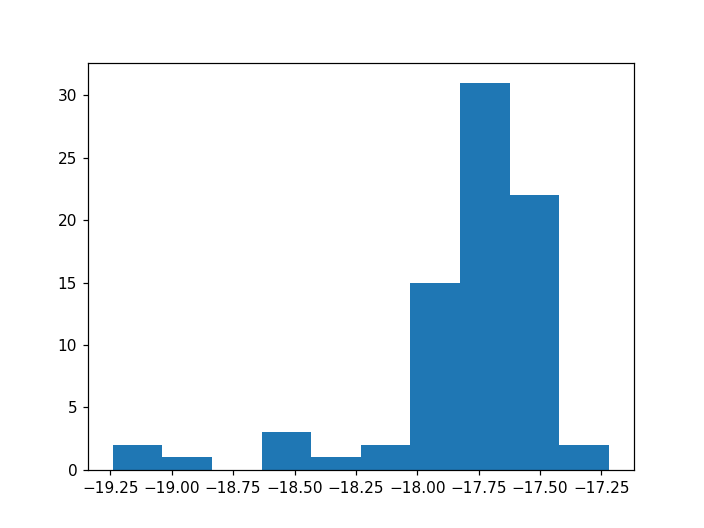

(array([ 2.,  1.,  0.,  3.,  1.,  2., 15., 31., 22.,  2.]),
 array([-19.24 , -19.038, -18.836, -18.634, -18.432, -18.23 , -18.028,
        -17.826, -17.624, -17.422, -17.22 ]),
 <BarContainer object of 10 artists>)

In [2363]:
fig, ax = plt.subplots()
plt.hist(ist['ist_c'][distances < max_dist])

In [2343]:
for loc in pts.keys():
    
    print(loc)
    
    for ii in pts[loc].keys():
        
        print(ii)
        print(f'{pts[loc][ii]['lats'][-1]}, {pts[loc][ii]['lons'][-1]}')

hip
0
70.07244088760594, -141.3550731447865
tuk
0
70.11536121585074, -136.95638627403756
1
69.93777122162942, -137.79491898343508


In [2301]:
ii

1

In [ ]:
wind_ds = np.sqrt((pts[ii]['xx'] - pts[ii]['xx'][0])**2+(pts[ii]['yy'] - pts[ii]['yy'][0])**2)

<IPython.core.display.Javascript object>


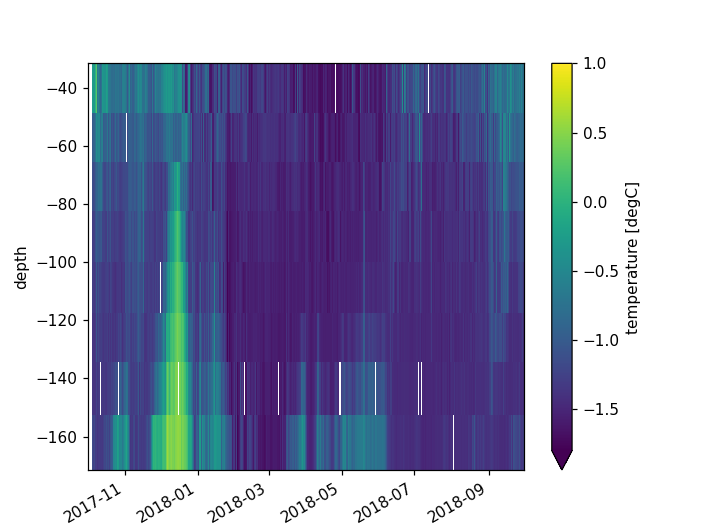

In [2294]:
ds = xr.open_dataset('/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M2/M2_hourly_tempsalinity_2017_2018.nc')
fig, ax = plt.subplots()

ds.T.plot(vmin=-1.8, vmax=1)




In [2101]:
event_dates[-1].year

2003

In [1538]:
df = pd.read_csv('/Users/mackenziejewell/Downloads/900107.csv')

buoydates = np.array([])

for dd in range(len(df.DOY)):
    datestr = f'{int(df.Year[dd])}.{int(df.DOY[dd])}.{int(df.Hour[dd])}.{int(df.Min[dd])}'
    date = datetime.strptime(datestr, '%Y.%j.%H.%M')
    buoydates = np.append(buoydates, date)
    
buoydates = pd.to_datetime(buoydates)

In [1539]:
indi = np.where((buoydates - event_dates[0]).total_seconds() >= 0)[0][0]
indf = np.where((buoydates - (event_dates[-1]+timedelta(hours=1))).total_seconds() <= 0)[0][-1]

buoydates = buoydates[indi:indf]
buoylats = df.Lat[indi:indf]
buoylons = df.Lon[indi:indf]

In [1540]:

out = map_proj.transform_points(ccrs.PlateCarree(), buoylons, buoylats)
buoy_xx = out[:,0]
buoy_yy = out[:,1]
    
buoy_ds = np.sqrt((buoy_xx-buoy_xx[0])**2 + (buoy_yy-buoy_yy[0])**2)

<IPython.core.display.Javascript object>


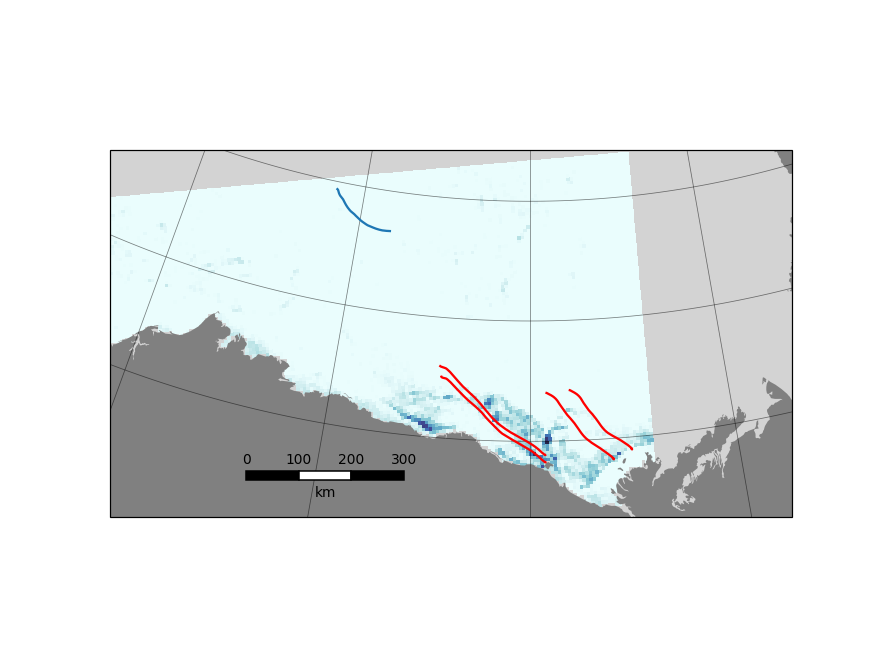

In [1541]:
fig, ax = plt.subplots(subplot_kw=dict(projection=map_proj), figsize=(8,6))

# ax.set_xlim(-500000,100000)
# ax.set_ylim(-2330000,-1800000)

ax.set_xlim(-800000,500000)
ax.set_ylim(-2400000,-1700000)
ax.set_facecolor('lightgray')
geomap.land(ax, scale = '10m', color='gray', alpha=1, fill_dateline_gap = True, zorder=2)
geomap.grid(ax, lats = np.arange(70,75,2), lons = np.arange(200,250,10) , color='k', linewidth=0.5)

geomap.scalebar(ax, loc=(0.2, 0.1), stepsize=100, numsteps=3, unit='km', label=None, 
                colors=['k', 'w'], edgecolor=None, textsize=9, lw=1, bar_width=0.025,
                labelpad=0.015, ticklabelpad=0.01, zorder=100)

mesh = ax.pcolormesh(sic['xx'], sic['yy'], sic['sic'], vmin=0, vmax=100, cmap=cmocean.cm.ice, transform=sic['proj'])


# ax.scatter(buoylons, buoylats, transform=ccrs.PlateCarree())

ax.plot(buoy_xx, buoy_yy,)


for ii in points.keys():
    ax.plot(points[ii]['lons'], 
            points[ii]['lats'], c='r', transform=ccrs.PlateCarree(), zorder=100)

In [1629]:
dss = xr.open_dataset('./data/heat_flux/ohf_2019_v0.nc')
dss = dss.sel(time = slice(event_dates[0], event_dates[-1]), z0=0.001, depth=-10)
dhdt = (dss.OHF.values * units(dss.OHF.units) / (cst['L_i'] * cst['rho_i'])).to('cm/day')

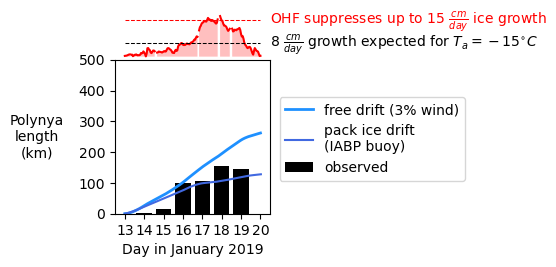

In [1703]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(2,2))

# ax.plot(np.sqrt(dx**2+dy**2)/1000)
ax.set_ylabel('Polynya\nlength\n(km)', rotation=0, labelpad=30, va='center')
plt.ylim(0,500)
ax.bar(event_dates, DS.length, color='k', label='observed')
ax.plot(points[0]['dates'], wind_ds[1:]/1000, c='dodgerblue', lw=2, label='free drift (3% wind)')
# ax.plot(event_dates, dist_osi[1:]/1000, c='skyblue', lw=2, label='OSI-SAF pack ice drift')


viirs = np.array([5.4,33.5, 38.5, 135,156, 171, 149,12])
viirs_site2 = np.array([4.4,4.4,4,8,10,8,5,np.nan])

# ax.plot(event_dates, viirs_site2, c='gray')

ax.plot(buoydates, buoy_ds/1000, c='royalblue', label='pack ice drift\n(IABP buoy)')

# ax.scatter(event_dates,  viirs, c='gray',)

scale = 8
yi = 510
ax.plot(dss.time, yi+dhdt.magnitude*scale, c='r', clip_on=False)
ax.fill_between(dss.time, yi+dhdt.magnitude*scale, yi, color='r',lw=0,  alpha=0.25, clip_on=False)

t = pd.to_datetime(dss.time.values[-1]) + timedelta(hours=12)
dt = timedelta(hours=3)
dy = 75
# ax.plot([t,t], [yi,yi+dy], c = 'r', lw=1,  clip_on=False)
# ax.plot([t-dt,t+dt], [yi,yi], c = 'r', lw=1,  clip_on=False)
# ax.plot([t-dt,t+dt], [yi+dy,yi+dy], c = 'r', lw=1,  clip_on=False)



dhdtref = 15
ax.plot([dates[0],dates[-1]], [yi+dhdtref*scale,yi+dhdtref*scale], ls='dashed', lw=0.75, c='r', clip_on=False)

# ax.text(1.05,1.03,'$\mathrm{500 Wm/2}$', c = 'r', transform=ax.transAxes)
# ax.text(1.05,1.03,'$\mathrm{10\;cm\;(day)^{-1}}$', c = 'r', transform=ax.transAxes)
ax.text(1.0,1.23,r'OHF suppresses up to 15 $\frac{cm}{day}$ ice growth', c = 'r', transform=ax.transAxes)


dhdt_exp = (4.5*units('cm')/(20*units('hour'))).to('cm/day')
# dhdt_exp = (3.3*units('cm')/(10*units('hour'))).to('cm/day')
# dhdt_exp = (5*units('cm')/(8.5*units('hour'))).to('cm/day')
ax.plot([dates[0],dates[-1]], [yi+dhdt_exp.magnitude*scale,yi+dhdt_exp.magnitude*scale], ls='dashed', lw=0.75, c='k', clip_on=False)
# ax.text(0.1,1.2, 'Ta = -30degC', transform=ax.transAxes)
ax.text(1.0,1.08,r'8 $\frac{cm}{day}$ growth expected for $T_{a} = -15 ^{\circ}C$', c = 'k', transform=ax.transAxes)

ax.set_xlim(event_dates[0]-timedelta(hours=12), event_dates[-1]+timedelta(hours=12))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d'))
ax.set_xlabel(f'Day in January {event_dates[-1].year}')
plt.legend(bbox_to_anchor=(2.3,0.8))


fig.savefig(f'./figures/overview/polynalength_{event_dates[-1].year}.png', dpi=300, bbox_inches='tight', pad_inches=0)


In [1861]:
sic = UNISIC.open_local_file(event_dates[-1], res='6250', hem='n', main_path='/Volumes/Seagate_Jewell/KenzieStuff/', 
                      crop=[800,1250,150,370], coordinates=False, area=False, include_units=False, quiet=True)

sic['sic'].shape


(450, 220)

In [2048]:

years = np.append(np.arange(2003,2012), np.arange(2013,2025))

sic_mean_sum = np.zeros_like(sic_mean['sic_mean'])
open_freq_sum = np.zeros_like(sic_mean['sic_mean'])

# mean across events
pe_sic_mean_sum = np.zeros_like(sic_mean['sic_mean'])
pe_open_freq_sum = np.zeros_like(sic_mean['sic_mean'])

num_events = 0


events_per_year = []
days_per_year = []

for year in years:
    
    print(year)
    DS = xr.open_dataset(f'./data/polynya_size/daily_polynya_{year}_sic15_v1.nc')
    time_range = slice(datetime(year,1,1), datetime(year,3,31))
    DS = DS.sel(time = time_range)
    open_dates = pd.to_datetime(DS.time[DS.extent > 500].values)
    days_per_year.append(len(open_dates))
    
    open_seqs = tseries.dates_to_sequences(open_dates, dt_max = 1 * units('day'))
    events_per_year.append(len(open_seqs))
        
    
    
    if len(open_dates) > 0:
        

        sic_mean = UNISIC.calc_meansic_openfreq(open_dates, crop = [800,1250,150,370], open_thresh = 15,
                          res = '6250', hem ='n', 
                          main_path = '/Volumes/Seagate_Jewell/KenzieStuff/',
                          coordinates = False, area = False, quiet=True)
        sic_mean_sum += sic_mean['sic_mean']
        open_freq_sum += sic_mean['open_freq']

        

        # average across each event and add as single to cross-event means
        for ss in open_seqs.keys():
            num_events+=1
            sic_mean = UNISIC.calc_meansic_openfreq(open_seqs[ss], crop = [800,1250,150,370], open_thresh = 15,
                          res = '6250', hem ='n', 
                          main_path = '/Volumes/Seagate_Jewell/KenzieStuff/',
                          coordinates = False, area = False, quiet=True)
            pe_sic_mean_sum += sic_mean['sic_mean']
            pe_open_freq_sum += sic_mean['open_freq']

    
mean_sic = sic_mean_sum/len(years)
mean_freq = open_freq_sum/len(years)

mean_sic_pe = pe_sic_mean_sum/num_events
mean_freq_pe = pe_open_freq_sum/num_events

2003
2004
2005
2006
2007
2008
2009
2010
2011
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024


In [2059]:
wind_events_per_year = []
wind_days_per_year = []

for year in years:
    
    time_range = slice(datetime(year, 1, 1), datetime(year, 3, 31,23))
    DS2 = grab_atm(time_range, lat = lat, lon = lon, dt = 'daily')

    u = DS2.u10.values
    v = DS2.v10.values

    angles = vectors.vector_angle(u*units('m/s'), v*units('m/s')).magnitude
    speeds = np.sqrt(u**2 + v**2)

    angle_range = (angles > 135) 
    wind_speed = speeds > 10
    wind_days_per_year.append(np.sum(angle_range & wind_speed))
    
    wind_dates = pd.to_datetime(DS2.time[angle_range & wind_speed].values)
    wind_seqs = tseries.dates_to_sequences(wind_dates, dt_max = 1 * units('day'))

    wind_events_per_year.append(len(wind_seqs))

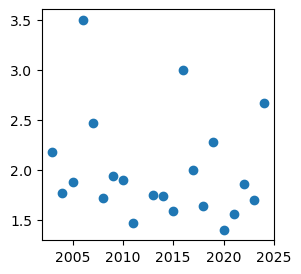

In [2070]:

fig, ax = plt.subplots(figsize=(3,3))
plt.scatter(years, np.array(wind_days_per_year)/np.array(wind_events_per_year))

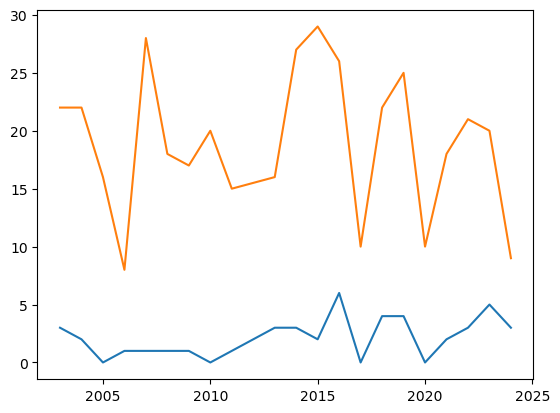

In [2062]:
plt.plot(years, events_per_year)
plt.plot(years, wind_events_per_year)

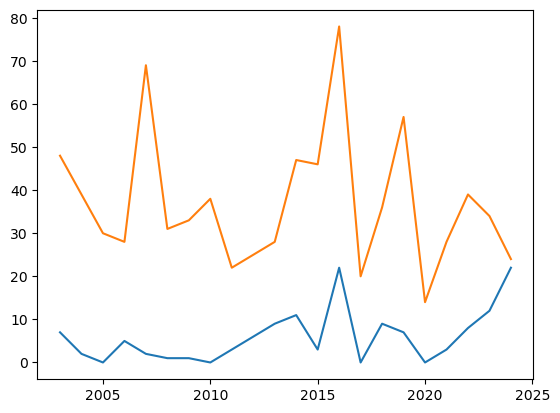

In [2063]:
plt.plot(years, days_per_year)
plt.plot(years, wind_days_per_year)

In [2045]:
year = 2024
DS = xr.open_dataset(f'./data/polynya_size/daily_polynya_{year}_sic15_v1.nc')
time_range = slice(datetime(year,1,1), datetime(year,3,31))
DS = DS.sel(time = time_range)
open_dates = pd.to_datetime(DS.time[DS.extent > 500].values)
open_seqs = tseries.dates_to_sequences(open_dates, dt_max = 1 * units('day'))

for ss in open_seqs.keys():
    print(f'[{ss}] {open_seqs[ss][0].date()} -- {open_seqs[ss][-1].date()}')

#======
ss = 0
#======
event_mean = UNISIC.calc_meansic_openfreq(open_seqs[ss], crop = [800,1250,150,370], open_thresh = 15,
                      res = '6250', hem ='n', 
                      main_path = '/Volumes/Seagate_Jewell/KenzieStuff/',
                      coordinates = False, area = False, quiet=True)


[0] 2024-01-04 -- 2024-01-18
[1] 2024-03-21 -- 2024-03-23
[2] 2024-03-28 -- 2024-03-31


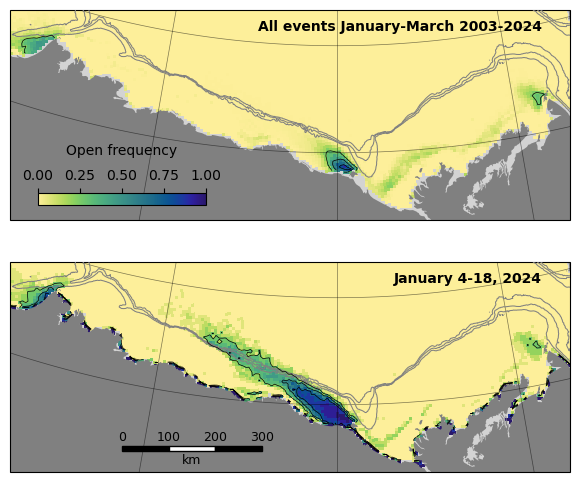

In [2047]:
fig, axs = plt.subplots(2,1,subplot_kw=dict(projection=map_proj), figsize=(8,6))

# ax.set_xlim(-500000,100000)
# ax.set_ylim(-2330000,-1800000)

for ax in axs:
    ax.set_xlim(-700000,500000)
    ax.set_ylim(-2400000,-1950000)
    ax.set_facecolor('lightgray')
    geomap.land(ax, scale = '10m', color='gray', alpha=1, fill_dateline_gap = True, zorder=2)
    geomap.grid(ax, lats = np.arange(70,75,2), lons = np.arange(200,250,10) , color='k', linewidth=0.5)
    
    geomap.gebco_bathymetry(ax, file_path='/Volumes/Seagate_Jewell/KenzieStuff/GEBCO/GEBCO_2024/gebco_2024_n90.0_s55.0_w-180.0_e180.0.nc', 
                            crop_lat=(69, 73), crop_lon=(-160, -120), clat=4, clon=10, 
                            contour_labels=False,
                            contour_levels=[-300,-200,-100],
                            contour_kwargs={'colors': 'gray', 'linewidths': 0.75, 'linestyles': 'solid', 'zorder': 100},
                            depth_shade=False)


    
geomap.scalebar(ax, loc=(0.2, 0.1), stepsize=100, numsteps=3, unit='km', label=None, 
                colors=['k', 'w'], edgecolor=None, textsize=9, lw=1, bar_width=0.025,
                labelpad=0.015, ticklabelpad=0.01, zorder=100)



ax = axs[0]
mesh = ax.pcolormesh(sic['xx'], sic['yy'], mean_freq_pe, vmin=0, vmax=1, cmap=cmocean.cm.haline_r, transform=sic['proj'])
ax.contour(sic['xx'], sic['yy'], mean_freq_pe, levels=[0.25,0.5,0.75,1], zorder=101,colors=['k'], linewidths=[0.5], transform=sic['proj'])
ax.text(0.95,0.9, f'All events January-March 2003-2024', ha='right',weight='bold', transform=ax.transAxes)

plotter.add_colorbar(fig, ax, [mesh], cb_placement='top', cb_orientation='horizontal', 
                     cb_width=0.02, cb_length_fraction=[0.05, 0.35], cb_pad=-0.325, cb_ticks='auto', 
                     cb_ticklabels='auto', cb_extend='neither', cb_label='Open frequency', labelpad=10, 
                     cb_label_placement='auto', cb_tick_placement='auto', tick_kwargs=None, 
                     cb_labelsize=10, draw_edges=False, edge_params=['k', 2])

ax = axs[1]
mesh = ax.pcolormesh(sic['xx'], sic['yy'], event_mean['open_freq'], vmin=0, vmax=1, cmap=cmocean.cm.haline_r, transform=sic['proj'])
ax.contour(sic['xx'], sic['yy'], event_mean['open_freq'], levels=[0.25,0.5,0.75,1],zorder=101, colors=['k'], linewidths=[0.5], transform=sic['proj'])
# ax.text(0.5,0.9, f'{open_seqs[ss][0].date()} -- {open_seqs[ss][-1].date()}', transform=ax.transAxes)
ax.text(0.95,0.9, f'January 4-18, 2024', ha='right',weight='bold', transform=ax.transAxes)


fig.savefig(f'./figures/overview/event_maps_Jan{year}.png', dpi=300, bbox_inches='tight', pad_inches=0)


In [1657]:
add

In [1658]:
dhdt_exp*5

<Quantity(27.0, 'centimeter / day')>

In [1647]:
15*5

75

In [1612]:
cst['L_i'].to('kJ/kg')

<Quantity(3.34, 'kilojoule / kilogram')>

In [1646]:
(500*units('W/m2') / (cst['L_i'] * cst['rho_i'])).to('cm/day')

<Quantity(14.1048329, 'centimeter / day')>

In [1601]:
(0.7*units('W/m2') / (cst['L_i'] * cst['rho_i'])).to_base_units()

<Quantity(2.28550533e-07, 'meter / second')>

In [1589]:
50 * units('cm/hour').to('m/day')

<Quantity(12.0, 'meter / day')>

In [1524]:
Tf = -1.8 + 273.15
# Ts = np.arange(255,Tf)[::-1]

Ts = 273.15 - 10

dt = np.linspace(0, 5, 100) * units('day')
dT = (Ts - Tf) * units('delta_degC')
dT

coeff = (2 * cst['k_i']) / (cst['rho_i'] * cst['L_i'])


In [1525]:


h0 = 0.05 * units('m')
h0

<Quantity(0.05, 'meter')>

In [1074]:
qcond = cst['k_i'] * dT / h0

dhdt = (qcond / (cst['rho_i'] * cst['L_i'])).to('m/day') * units('day')

dhdt

<Quantity(-10.1780474, 'meter')>

In [1075]:
273.15-1.8


271.34999999999997

In [1079]:
coeff = (2 * cst['k_i']) / (cst['rho_i'] * cst['L_i'])
h = np.sqrt(-coeff*dT*dt).to_base_units()

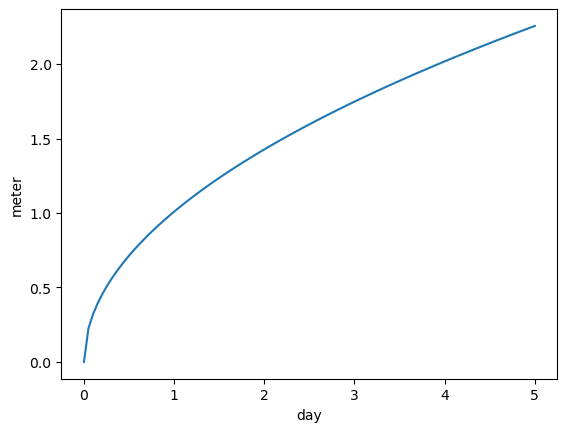

In [1080]:
plt.plot(dt, h)

In [996]:
h.to_base_units()

<Quantity([-0. nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan], 'meter')>

In [980]:
hi = np.arange(0,1,0.05) * units('m')

In [979]:
cst['k_i']

<Quantity(2.2, 'watt / meter / delta_degree_Celsius')>

In [883]:

for dd, date in enumerate(event_dates):
    
    sic = UNISIC.open_local_file(date, res='6250', hem='n', main_path='/Volumes/Seagate_Jewell/KenzieStuff/', 
                      crop=[800,1250,150,350], coordinates=False, area=False, include_units=False, quiet=True)


    
#     drift = osidrift.open_local_file(date, main_path = '/Volumes/Seagate_Jewell/KenzieStuff/OSI-SAF/', 
#                                  include_units = True)
#     drift['sp'] = np.sqrt(drift['u']**2+drift['v']**2)
    

#     # transform to map
#     out = ccrs.PlateCarree().transform_points(drift['proj'], drift['xx0'], drift['yy0'])
#     drift['lons'] = out[:,:,0]
#     drift['lats'] = out[:,:,1]

#     lon_range = (drift['lons'] < -140) & (drift['lons'] > -155)
#     lat_range = (drift['lats'] < 73) & (drift['lats'] > 69.5)

#     # advect ice along vector in osi projection
#     u_loc = np.nanmean(drift['u'][lon_range&lat_range])
#     v_loc = np.nanmean(drift['v'][lon_range&lat_range])

#     dx_osi = u_loc.to('m/day') * units('day')
#     dy_osi = v_loc.to('m/day') * units('day')

    
#     xosi = xxx_osi[-1] + dx_osi.magnitude
#     yosi = yyy_osi[-1] + dy_osi.magnitude 
#     xxx_osi = np.append(xxx_osi, xosi)
#     yyy_osi = np.append(yyy_osi, yosi)

    
    
#     if date > datetime(2024,1,7):
#         lon_range = (drift['lons'] < -133) & (drift['lons'] > -140)
#         lat_range = (drift['lats'] < 71.5) & (drift['lats'] > 69)

#         # advect ice along vector in osi projection
#         u_loc = np.nanmean(drift['u'][lon_range&lat_range])
#         v_loc = np.nanmean(drift['v'][lon_range&lat_range])

#         dx_osi = u_loc.to('m/day') * units('day')
#         dy_osi = v_loc.to('m/day') * units('day')

#         xosi = xxx2_osi[-1] + dx_osi.magnitude
#         yosi = yyy2_osi[-1] + dy_osi.magnitude 
#         xxx2_osi = np.append(xxx2_osi, xosi)
#         yyy2_osi = np.append(yyy2_osi, yosi)

        

    fig, ax = plt.subplots(subplot_kw=dict(projection=map_proj), figsize=(8,6))

    # ax.set_xlim(-500000,100000)
    # ax.set_ylim(-2330000,-1800000)

    ax.set_xlim(-800000,500000)
    ax.set_ylim(-2400000,-1800000)
    ax.set_facecolor('lightgray')
    geomap.land(ax, scale = '10m', color='gray', alpha=1, fill_dateline_gap = True, zorder=2)
    geomap.grid(ax, lats = np.arange(70,75,2), lons = np.arange(200,250,10) , color='k', linewidth=0.5)

    geomap.scalebar(ax, loc=(0.2, 0.1), stepsize=100, numsteps=3, unit='km', label=None, 
                    colors=['k', 'w'], edgecolor=None, textsize=9, lw=1, bar_width=0.025,
                    labelpad=0.015, ticklabelpad=0.01, zorder=100)

    # label_side = 'left'

    # geomap.gebco_bathymetry(ax, file_path='/Volumes/Seagate_Jewell/KenzieStuff/GEBCO/GEBCO_2024/gebco_2024_n90.0_s55.0_w-180.0_e180.0.nc', 
    #                         crop_lat=(69, 71), crop_lon=(-147, -135), clat=2, clon=5, 
    #                         contour_labels=False,
    #                         contour_levels=[-500,-300,-200,-100,  -40,-20],
    #                         contour_kwargs={'colors': 'gray', 'linewidths': 0.5, 'linestyles': 'solid', 'zorder': 1},
    #                         depth_shade=False)


    mesh = ax.pcolormesh(sic['xx'], sic['yy'], sic['sic'], vmin=0, vmax=100, cmap=cmocean.cm.ice, transform=sic['proj'])



    # ax.pcolormesh(drift['x0'], drift['y0'], drift['sp'], vmin=0, vmax=40, cmap=cmocean.cm.speed, transform=drift['proj'])


    # ax.pcolormesh(drift['xx_proj'], drift['yy_proj'], drift['sp'], vmin=0, vmax=40, cmap=cmocean.cm.speed)#, transform=drift['proj'])


    ax.scatter(M1['xx'], M1['yy'], marker='o', s=50, facecolor='w', edgecolor='k')
    # ax.plot(lons, lats, c='r', transform=ccrs.PlateCarree())


    ax.plot(xxx_osi[:dd+1], yyy_osi[:dd+1], c='r',  ls='dashed', lw=1,  transform=drift['proj'])
    ax.scatter(xxx_osi[0], yyy_osi[0], c='r',  marker='.', transform=drift['proj'])
    ax.scatter(xxx_osi[dd], yyy_osi[dd], c='r',  marker='x', transform=drift['proj'])


    ax.plot(lons[:dd+1], lats[:dd+1], c='b',  ls='dashed', lw=1,  transform=ccrs.PlateCarree())
    ax.scatter(lons[dd], lats[dd], c='b', marker='x', transform=ccrs.PlateCarree(), zorder=100)

    ax.set_title(date.date())

    plotter.add_colorbar(fig, ax, [mesh], cb_placement='top', cb_orientation='horizontal', 
                     cb_width=0.025, cb_length_fraction=[0.7, 0.9], cb_pad=0.025, cb_ticks='auto', 
                     cb_ticklabels='auto', cb_extend='neither', cb_label='SIC (%)', labelpad='auto', 
                     cb_label_placement='auto', cb_tick_placement='auto', tick_kwargs=None, 
                     cb_labelsize=12, draw_edges=False, edge_params=['k', 2])
    
    
    fig.savefig(f'/Users/mackenziejewell/Desktop/imgs/img_{date.strftime("%Y-%m-%d")}.png',
                dpi=300, bbox_inches='tight', pad_inches=0)
    
    plt.close()


In [ ]:
import timeseries.adjust as tseries

In [1834]:


years = np.append(np.arange(2003,2012), np.arange(2013,2025))

# years = [2003, 2004]#, 2005, 2006]


angles_on_polynya_days = np.array([])
angles_other_days = np.array([])

speeds_on_polynya_days = np.array([])
speeds_other_days = np.array([])

annual_polynyas = np.array([])
annual_SEwinds = np.array([])

for year in years:
    
    print(year)
    
    time_range = slice(datetime(year-1, 12, 28), datetime(year, 3, 31,23))
    open_years = f'{time_range.start.year}_{time_range.stop.year}'
    DS = xr.open_dataset(f'./data/polynya_size/daily_polynya_{time_range.stop.year}_sic15_v1.nc')
    DS = DS.sel(time = time_range)
    
    
    polynya_cond = DS.extent.values[4:] > 500
    polynya_days = np.sum(polynya_cond)
    annual_polynyas = np.append(annual_polynyas, polynya_days)
    
#     ax.scatter(year, polynya_days)

    lat, lon = 70.5, -140 
    DS2 = grab_atm(time_range, lat = lat, lon = lon, dt = 'daily')
    
    time_range = slice(datetime(year-1, 12, 28), datetime(year, 3, 31,23))
    DS2 = grab_atm(time_range, lat = lat, lon = lon, dt = 'daily')
#     DS2['se'] = vectors.comp_along_theta(DS2.u10, DS2.v10, 135*units('deg')).values[4:]
#     u = tseries.running_mean(DS2.u10.values, length=4, center=False, address_nans=False)[4:]
#     v = tseries.running_mean(DS2.v10.values, length=4, center=False, address_nans=False)[4:]

    u = DS2.u10.values[4:]
    v = DS2.v10.values[4:]


    # year2
#     lat, lon = 70.5, -140 
#     DS2 = xr.open_dataset(f'/Volumes/Jewell_EasyStore/ECMWF/annual/daily/ERA5_{time_range.stop.year}_daily.nc')
#     DS2.close()
#     DS2 = DS2.sel(latitude = lat, longitude = lon, time=time_range)
#     SE_wind_days = np.sum(DS2.se > 7.5)
    
    angles = vectors.vector_angle(u*units('m/s'), v*units('m/s')).magnitude
    speeds = np.sqrt(u**2 + v**2)
    
#     angle_range1 = (angles > 115) & (angles < 165)
    
    angle_range1 = (angles > 135) #& (angles < 180)
    angle_range2 = (angles < -165) #& (angles > -180)
#     angle_range = angle_range1.astype(int) + angle_range2.astype(int) >= 1
    angle_range = angle_range1
    wind_speed = speeds > 10
    SE_wind_days = np.sum(angle_range & wind_speed)

    angles_on_polynya_days = np.append(angles_on_polynya_days, angles[polynya_cond])
    angles_other_days = np.append(angles_other_days, angles[polynya_cond == False])
    
    speeds_on_polynya_days = np.append(speeds_on_polynya_days, speeds[polynya_cond])
    speeds_other_days = np.append(speeds_other_days, speeds[polynya_cond == False])
    
    annual_SEwinds = np.append(annual_SEwinds, SE_wind_days)
    
#     ax.scatter(year, SE_wind_days)

2003
2004
2005
2006
2007
2008
2009
2010
2011
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024


In [1830]:
all_speeds = np.append(speeds_on_polynya_days, speeds_other_days)
np.nanmean(all_speeds) + 1.0*np.nanstd(all_speeds)

9.890678029007706

In [1825]:
all_speeds = np.append(speeds_on_polynya_days, speeds_other_days)
np.nanmean(all_speeds) + 0.5 * np.nanstd(all_speeds)

8.108937202850885

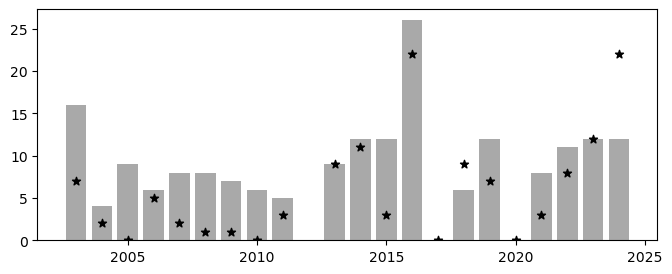

In [1826]:

fig, ax = plt.subplots(figsize=(8,3))
ax.bar(years, annual_SEwinds, color='darkgray')
ax.scatter(years, annual_polynyas, marker='*', c='k')

In [1827]:
from scipy import stats

In [1828]:
np.max([np.nanmax(x), np.nanmax(y)])

32.0

<>:35: SyntaxWarning: invalid escape sequence '\m'
<>:35: SyntaxWarning: invalid escape sequence '\m'
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_34639/1681513105.py:35: SyntaxWarning: invalid escape sequence '\m'
  ax.text(0,24, '($\mathrm{R^2}$'+f'= {res.rvalue**2:.2f})', color=tc, ha='left')


max val: 26.0


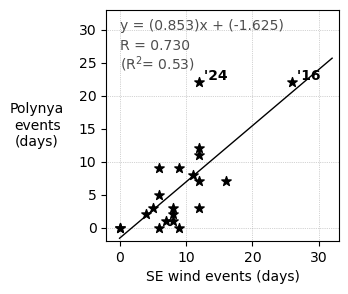

In [1836]:
x = annual_SEwinds
y = annual_polynyas

x_nn = x[np.isfinite(x)&np.isfinite(y)]
y_nn = y[np.isfinite(x)&np.isfinite(y)]

res = stats.linregress(x_nn, y_nn)



fig, ax = plt.subplots(figsize=(3,3))

ax.set_xlabel('SE wind events (days)')# [3-day running]
ax.set_ylabel('Polynya\nevents\n(days)', rotation=0, labelpad=30, va='center')

maxval = np.max([np.nanmax(x), np.nanmax(y)])
print(f'max val: {maxval}')
ax.set_xlim(-2,33)
ax.set_ylim(-2,33)

for n in [0,10,20,30]:
    ax.axhline(n, zorder=-1, c='darkgray', lw=0.5, ls='dotted')
    ax.axvline(n, zorder=-1, c='darkgray', lw=0.5, ls='dotted')

x_line = np.array([0,32])
y_line = res.intercept + res.slope*x_line

# ax.plot(x_line, x_line, lw=1, ls='dashed', c='darkgray', zorder=-1)
# ax.text(24,24+4, '1:1', color='gray')

tc = [0.3,0.3,0.3]
ax.plot(x_line, y_line, lw=1, ls='solid', c='k')
ax.text(0,30, f'y = ({res.slope:.3f})x + ({res.intercept:.3f})', color=tc, ha='left')
ax.text(0,27, f'R = {res.rvalue:.3f}', color=tc, ha='left')
ax.text(0,24, '($\mathrm{R^2}$'+f'= {res.rvalue**2:.2f})', color=tc, ha='left')
# ax.text(24,24+4, '1:1')

ax.scatter(x, y, marker='*', s=50, c='k')
ax.text(x[years==2024],y[years==2024]," '24", weight='bold', ha='left', va='bottom')
ax.text(x[years==2016],y[years==2016]," '16", weight='bold', ha='left', va='bottom')

fig.savefig('./figures/overview/JFM_events.png', dpi=300, bbox_inches='tight', pad_inches=0)

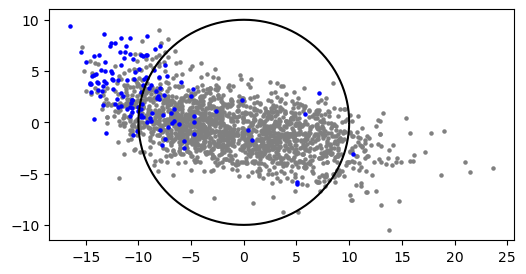

In [1831]:
fig, ax = plt.subplots(figsize=(6,3))


u = speeds_other_days * np.cos(angles_other_days * np.pi/180)
v = speeds_other_days * np.sin(angles_other_days * np.pi/180)
ax.scatter(u,v, c='gray', s=5)

u = speeds_on_polynya_days * np.cos(angles_on_polynya_days * np.pi/180)
v = speeds_on_polynya_days * np.sin(angles_on_polynya_days * np.pi/180)
ax.scatter(u,v, c='b', s=5)


angles = np.arange(0,360,1)
R = 10
u = R * np.cos(angles * np.pi/180)
v = R * np.sin(angles * np.pi/180)
ax.plot(u,v, c='k')

(array([ 5.,  2.,  2.,  2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,
         2.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  3.,  5.,
        15., 10., 17., 15., 16., 16., 10.]),
 array([-180., -175., -170., -165., -160., -155., -150., -145., -140.,
        -135., -130., -125., -120., -115., -110., -105., -100.,  -95.,
         -90.,  -85.,  -80.,  -75.,  -70.,  -65.,  -60.,  -55.,  -50.,
         -45.,  -40.,  -35.,  -30.,  -25.,  -20.,  -15.,  -10.,   -5.,
           0.,    5.,   10.,   15.,   20.,   25.,   30.,   35.,   40.,
          45.,   50.,   55.,   60.,   65.,   70.,   75.,   80.,   85.,
          90.,   95.,  100.,  105.,  110.,  115.,  120.,  125.,  130.,
         135.,  140.,  145.,  150.,  155.,  160.,  165.,  170.,  175.,
         180.]),
 <Bar

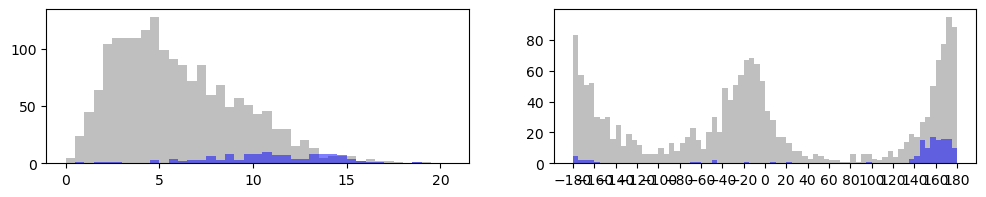

In [1765]:
fig, axs = plt.subplots(1,2,figsize=(12,2))


ax = axs[0]
bins = np.arange(0,21,0.5)
ax.hist(speeds_other_days, bins=bins, color='gray', alpha=0.5)
ax.hist(speeds_on_polynya_days, bins=bins, color='blue', alpha=0.5)

ax = axs[1]
bins = np.arange(-180,181,5)
ax.set_xticks(np.arange(-180,181,20))
ax.hist(angles_other_days, bins=bins, color='gray', alpha=0.5)
ax.hist(angles_on_polynya_days, bins=bins, color='blue', alpha=0.5)

(array([ 7.,  4.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,
         2.,  0.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  1.,  0.,  0.,  0.,  3., 20., 27., 31., 26.]),
 array([-180., -170., -160., -150., -140., -130., -120., -110., -100.,
         -90.,  -80.,  -70.,  -60.,  -50.,  -40.,  -30.,  -20.,  -10.,
           0.,   10.,   20.,   30.,   40.,   50.,   60.,   70.,   80.,
          90.,  100.,  110.,  120.,  130.,  140.,  150.,  160.,  170.,
         180.]),
 <BarContainer object of 36 artists>)

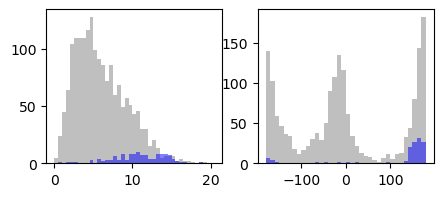

In [608]:
fig, axs = plt.subplots(1,2,figsize=(5,2))

ax = axs[0]
bins = np.arange(0,21,0.5)
ax.hist(speeds_other_days, bins=bins, color='gray', alpha=0.5)
ax.hist(speeds_on_polynya_days, bins=bins, color='blue', alpha=0.5)


ax = axs[1]
bins = np.arange(-180,181,10)
# ax.set_xticks(np.arange(-180,181,60))
ax.hist(angles_other_days, bins=bins, color='gray', alpha=0.5)
ax.hist(angles_on_polynya_days, bins=bins, color='blue', alpha=0.5)

In [478]:
# year2
lat, lon = 70.5, -140 
DS2 = xr.open_dataset(f'/Volumes/Jewell_EasyStore/ECMWF/annual/daily/ERA5_{time_range.stop.year}_daily.nc')
DS2.close()
DS2 = DS2.sel(latitude = lat, longitude = lon, time=time_range)
ds4['se'] = vectors.comp_along_theta(ds4.u10, ds4.v10, 135*units('deg'))
SE_wind_days = np.sum(ds4.se.values > 5)

In [161]:

lons = np.array([M1['lon']])
lats = np.array([M1['lat']])

for dd, date in enumerate(event_dates):

    U = np.array([ds.sel(depth=-10, time = date).u.values]) * units('m/s')
    V = np.array([ds.sel(depth=-10, time = date).v.values]) * units('m/s')

    lon, lat = lons[-1], lats[-1]

    tail, tip, vec = vectors.project_vectors(map_proj, lon, lat, 
                                             eastward = U, northward = V, 
                                             final_units='m/hour')

    lon, lat = ccrs.PlateCarree().transform_point(*tip, map_proj)
    
    lons = np.append(lons, lon)
    lats = np.append(lats, lat)


In [126]:
tail

(-59558.261227171664, -2215004.8739944347)

In [41]:
date = datetime(2018,1,8)

ds3.sel(time = date).u.values

array(-0.10488698)

In [35]:
event_time = slice(datetime(2018,1,8), datetime(2018, 1, 11))


<IPython.core.display.Javascript object>


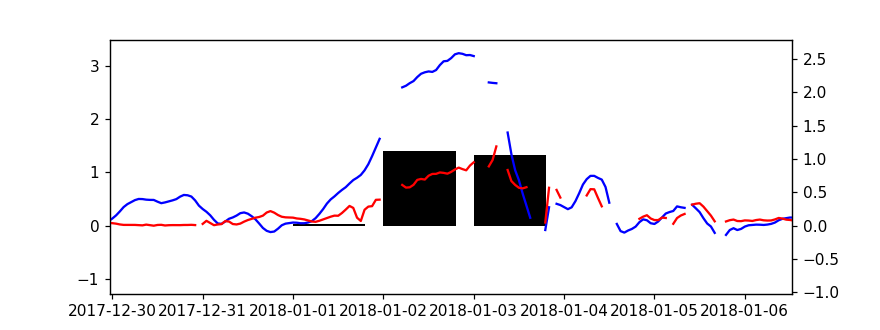

In [156]:
%matplotlib notebook

fig, ax = plt.subplots(figsize=(8,3))

ax.set_ylim(-5,5)
ax.bar(DS.time, DS.extent/1000, align='edge', color='k')

ax2 = ax.twinx()
ax2.set_ylim(-4,4)
ax2.plot(ds3.time, ds3.se, c='b')

ax2.plot(ds6.time, ds6.OHF.sel(z0=0.0001, depth=-10)/500, c='r')

In [2640]:
dLdt = DS.length.diff('time')
dttimes = pd.to_datetime(dLdt.time.values)# - timedelta(hours=12)

L = DS.length.values[:-1]

In [2641]:
ui = np.array([])
ua = np.array([])

for time in dttimes:
    
    time_slice = slice(time - timedelta(hours=12), time + timedelta(hours=11))
    
    avg_ui = ds3.se.sel(time = time_slice).mean(dim='time').values * units('m/s')
    avg_ua = ds4.se.sel(time = time_slice).mean(dim='time').values * units('m/s')
    
    ui = np.append(ui, avg_ui.to('km/day').magnitude)
    ua = np.append(ua, avg_ua.to('m/s').magnitude)

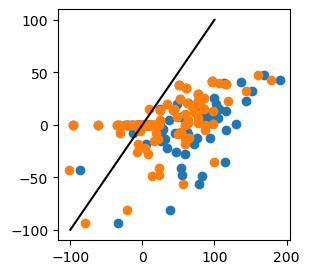

In [2642]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(3,3))

line = 100

frazil_collection = 50 # km/day

ht = (1/15) * (1+0.1*np.abs(ua))
# ht[np.abs(ua)<5] = 0
P = 0.05
frazil_collection = P*L/ht # km/day


ax.plot([-line,line], [-line, line], c='k')

ax.scatter(ui, dLdt)
ax.scatter(ui-frazil_collection, dLdt)

# ax.scatter(ua, ht)

<IPython.core.display.Javascript object>


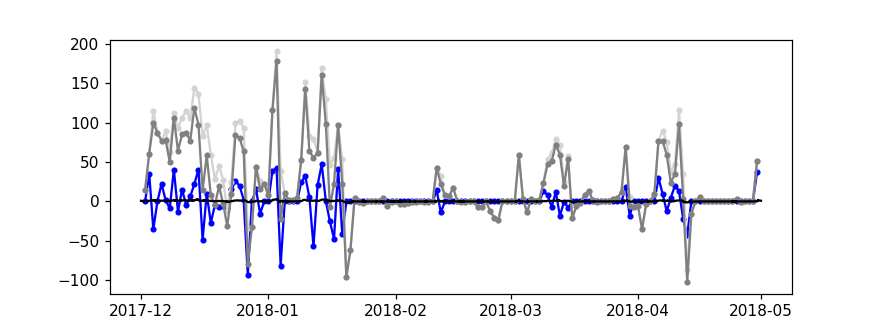

In [2643]:
%matplotlib notebook

fig, ax = plt.subplots(figsize=(8,3))


# ax.bar(dttimes, dLdt/20, align='edge')

ax.plot(dttimes, dLdt, c='b', marker='.')


# ax.plot(dttimes, dLdt)
# ax.scatter(dLdt.time, np.zeros(len(dLdt)), marker='.')

ax.plot(dLdt.time, ui, marker='.', c='lightgray')
ax.plot(dLdt.time, ui-frazil_collection, marker='.', c='gray')

ax.plot(ds3.time, ds3.se, c='k')

<IPython.core.display.Javascript object>


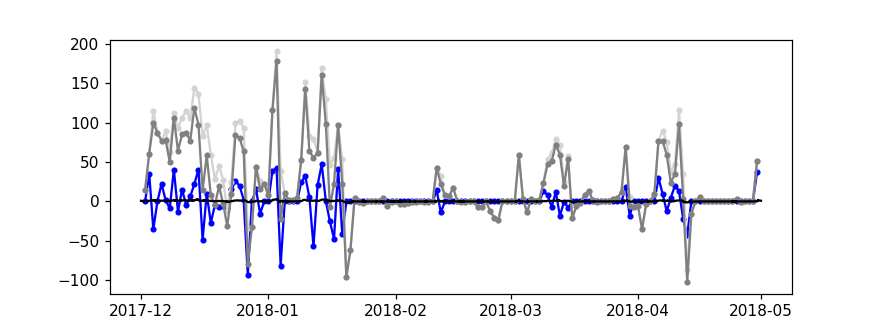

In [2644]:
%matplotlib notebook

fig, ax = plt.subplots(figsize=(8,3))


# ax.bar(dttimes, dLdt/20, align='edge')

ax.plot(dttimes, dLdt, c='b', marker='.')


# ax.plot(dttimes, dLdt)
# ax.scatter(dLdt.time, np.zeros(len(dLdt)), marker='.')

ax.plot(dLdt.time, ui, marker='.', c='lightgray')
ax.plot(dLdt.time, ui-frazil_collection, marker='.', c='gray')

ax.plot(ds3.time, ds3.se, c='k')

<IPython.core.display.Javascript object>


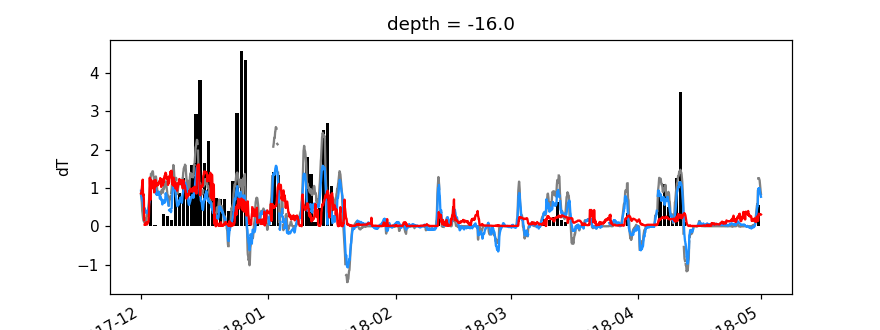

<BarContainer object of 151 artists>

In [2648]:
%matplotlib notebook

fig, ax = plt.subplots(figsize=(8,3))
# plt.plot(ds3.time, exp_ice_se, c='lightgray')
# plt.plot(ds.time, exp_ice_se, c='k')
(ds3.se).plot(c='gray')

(ds.se.sel(depth=-10)).plot(c='dodgerblue')

(ds2.dT.sel(depth=-16)).plot(c='r')



# plt.bar(DS.time, DS.extent/2000, align='edge', color='k')

# plt.bar(DS.time, (DS.length)/50, align='edge', color='k')

plt.bar(DS.time, (DS.extent)/1000, align='edge', color='k')



# (ds.u.sel(depth=-22)).plot()

# ds2.dT.sel(depth=-16).plot()
# plt.ylim(-0.2,0.2)
# ds32.u.plot()

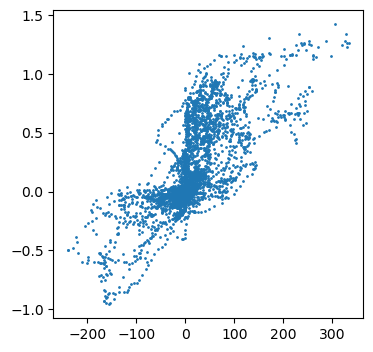

In [12]:
fig, ax = plt.subplots(figsize=(4,4))
# ax.scatter(ds4.se, ds3.se, s=1)
# ax.scatter(ds4.se, ds.se.mean('depth'), s=1)
ax.scatter(np.sign(ds4.se)*ds4.se**2, ds.se.mean('depth'), s=1)

<IPython.core.display.Javascript object>


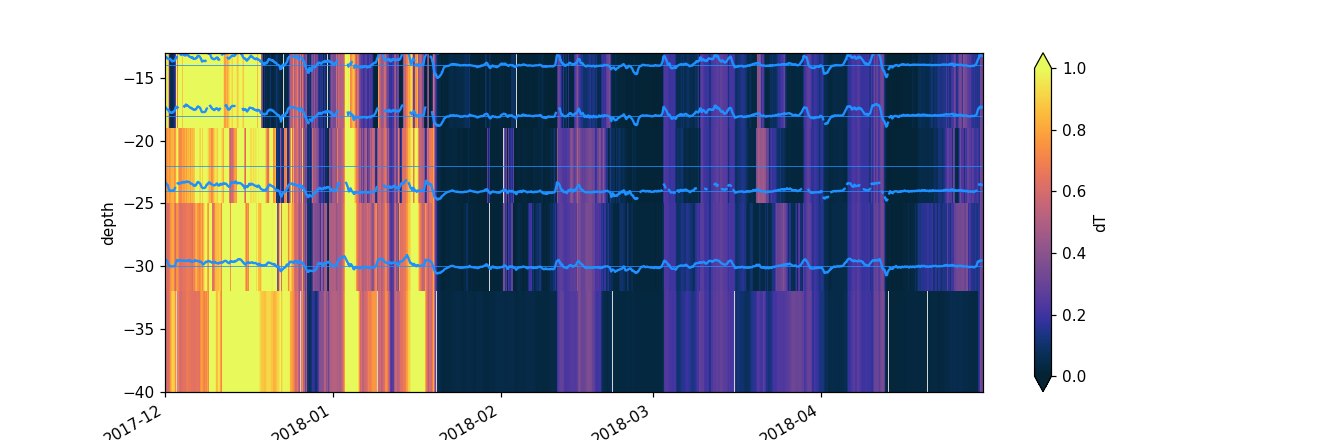

<xarray.DataArray 'depth' (depth: 4)>
array([-36., -28., -22., -16.])
Coordinates:
  * depth    (depth) float64 -36.0 -28.0 -22.0 -16.0


In [2653]:


fig, ax = plt.subplots(figsize=(12,4))
ax.patch.set_facecolor('lightgray')


(ds2.dT).plot(vmin=0, vmax=1, cmap=cmocean.cm.thermal)

for depth in ds.depth.values:
    plt.axhline(depth, lw=0.5, c='dodgerblue')
    plt.plot(ds.time, ds.se.sel(depth=depth)+depth, c='dodgerblue')


# .sel(depth = np.array([-36,-28,-16]))
# ds2.Sp.plot(vmin=30, vmax=34, cmap=cmocean.cm.thermal)

print(ds2.depth)


# ax.plot(ds3.time, 8*(-ds3.u)-16,c='r',  clip_on = True)
# ax.plot(ds.time, 8*(-ds.u.mean(dim='depth'))-16,c='mediumpurple',  clip_on = True)

# ax.set_xlim(datetime(2017,2,15), datetime(2017,3,5))

### Evaluate data gaps

In [527]:
#===================
retain_frac = 0.95
#===================

print(f'Ocean currents:')
for depth in ds.depth.values[::-1]:
    # finite fraction
    ffrac = np.sum(np.isfinite(ds.u.sel(depth=depth).values)) / len(ds.time)
    print(f'z = {str(depth)} [{ffrac:.2f}] {"*"*(ffrac > retain_frac)}')

print(f'\nOcean temperatures:')
for depth in ds2.depth.values[::-1]:
    # finite fraction
    ffrac = np.sum(np.isfinite(ds2.Ct.sel(depth=depth).values)) / len(ds2.time)
    print(f'z = {str(depth)} [{ffrac:.2f}] {"*"*(ffrac > retain_frac)}')
    
print(f'\nSea ice velocity:')
# finite fraction
ffrac = np.sum(np.isfinite(ds3.u.values)) / len(ds3.time)
print(f'z = {str(depth)} [{ffrac:.2f}] {"*"*(ffrac > retain_frac)}')

Ocean currents:
z = -4.0 [0.30] 
z = -6.0 [0.42] 
z = -8.0 [0.46] 
z = -10.0 [0.48] 
z = -12.0 [0.48] 
z = -14.0 [0.48] 
z = -18.0 [0.47] 
z = -22.0 [0.00] 
z = -24.0 [0.36] 
z = -30.0 [0.48] 

Ocean temperatures:
z = -16.0 [1.00] *
z = -22.0 [1.00] *
z = -28.0 [1.00] *
z = -36.0 [0.99] *

Sea ice velocity:
z = -36.0 [0.47] 


/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_812/1511898339.py:9: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  print(f'z = {str(depth)} [{ffrac:.2f}] {"*"*(ffrac > retain_frac)}')
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_812/1511898339.py:15: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  print(f'z = {str(depth)} [{ffrac:.2f}] {"*"*(ffrac > retain_frac)}')
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_812/1511898339.py:20: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  print(f'z = {str(depth)} [{ffrac:.2f}] {"*"*(ffrac > retain_frac)}')


layer 0 [0, -16], dz = 16 meter


ValueError: attempt to get argmin of an empty sequence

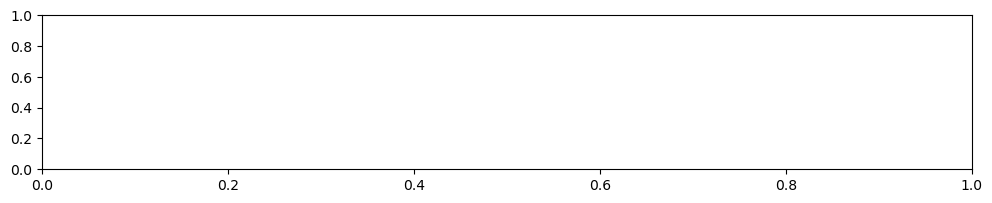

In [528]:
def interp_U(ds, z_loc, method = 'interp'):
                
    ffrac = np.isfinite(ds.u).sum(dim='time') / len(ds.time)
    
    thresh = 0.95
    
    if str(method) == 'interp':

        # find nearest velocity above / below:
        z_abv = ds.depth.values[(ds.depth.values > z_loc)&(ffrac.values>thresh)][0]
        z_blw = ds.depth.values[(ds.depth.values < z_loc)&(ffrac.values>thresh)][-1]
        print(f'       interp U({z_loc}) from: [{z_abv} {z_blw}]')

        U_abv = ds.se.sel(depth = z_abv).values
        U_blw = ds.se.sel(depth = z_blw).values

        # interp
        dz = z_loc-z_blw
        dZ = z_abv-z_blw
        dU = U_abv-U_blw
        U_interp = U_blw + dz*(dU/dZ)
        
    elif str(method) == 'nearest':
        
        # find nearest velocity above / below:
        z_retain = ds.depth.values[(ffrac.values>thresh)]
        z_near = z_retain[np.argmin(abs(z_retain - z_loc))]
        U_interp = ds.se.sel(depth = z_near).values
        print(f'       interp U({z_loc}) from: [{z_near}]')

    return U_interp
            
            
depths = [0, -16]#, -22, -28]

fig, ax = plt.subplots(figsize=(12,2))

OHT = np.array([])

for ii in range(len(depths[:-1])):
    
    z = {}
    Up = {}
    dT = {}
    
    z['a'] = depths[ii]
    z['b'] = depths[ii+1]
    
    dz = np.abs(z['a'] - z['b']) * units('m')
    
    print(f"layer {ii} [{z['a']}, {z['b']}], dz = {dz}")
    
    if z['a']==0:
#         dT['a'] = (0 + np.zeros(len(ds2.time))) * units('delta_degC')
        dT['a'] = (ds2.dT).sel(depth=z['b']).values * units('delta_degC')
        Up['a'] = ds3.se.values * units('m/s')
        rho_a = (ds2.sel(depth = z['b']).sig0 + 1000).values * units('kg/m^3')
        
    else:
        dT['a'] = (ds2.Ct - ds2.Tf).sel(depth=z['a']).values * units('delta_degC')
        Up['a'] = interp_U(ds, z['a'], method = 'nearest') * units('m/s')
        rho_a = (ds2.sel(depth = z['a']).sig0 + 1000).values * units('kg/m^3')
        
    dT['b'] = (ds2.Ct - ds2.Tf).sel(depth=z['b']).values * units('delta_degC')
    Up['b'] = interp_U(ds, z['b'], method = 'nearest') * units('m/s')
    rho_b = (ds2.sel(depth = z['b']).sig0 + 1000).values * units('kg/m^3')
    
    
    a_OHT = cst['Cp_o'] * rho_a * dT['a'] * Up['a']
    b_OHT = cst['Cp_o'] * rho_b * dT['b'] * Up['b']
    
    # add in the time component (hourly velocity measurements, so mass flux integrated over an hour)
#     a_OHT = a_OHT * units('hour').to('s')
#     b_OHT = b_OHT * units('hour').to('s')
    
    trap_OHT = 0.5 * (a_OHT + b_OHT) * dz
    
#     ax.plot(ds2.time, a_OHT)
#     ax.plot(ds2.time, b_OHT)
    
    ax.plot(ds2.time, trap_OHT/dz)

    

<IPython.core.display.Javascript object>


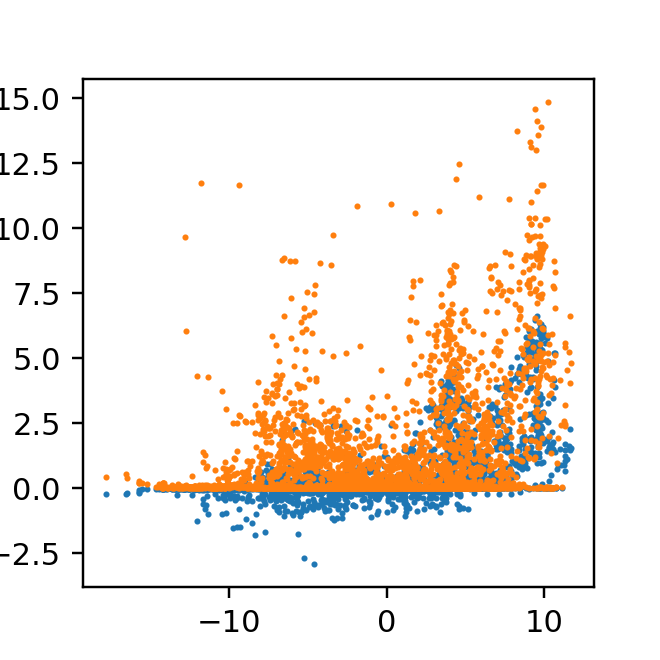

In [342]:
fig, ax = plt.subplots(figsize=(3,3))

lag = 6

ax.scatter(ds4.se[:-lag], ((trap_OHT/dz).to('W/m2')/(10**6))[lag:], s=1)

ax.scatter(ds4.se[:-lag], (THF/(10**2))[lag:], s=1)

In [534]:
daily_THF = np.array([])
for date in pd.to_datetime(DS.time.values):
    
    dt = (pd.to_datetime(ds.time.values)-date).total_seconds()/(3600)
    
    daily_THF = np.append(daily_THF, np.nanmean(THF[(dt >= 0)&(dt < 24)]))

/opt/anaconda3/envs/SBSpolynya/lib/python3.12/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/opt/anaconda3/envs/SBSpolynya/lib/python3.12/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/opt/anaconda3/envs/SBSpolynya/lib/python3.12/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/opt/anaconda3/envs/SBSpolynya/lib/python3.12/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/opt/anaconda3/envs/SBSpolynya/lib/python3.12/site-packages/pint/facets/numpy/numpy_func.py:856: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)
/opt/anaconda3/envs/SBSpolynya/lib/python3.12/site-packages/pint/facets/num

<>:8: SyntaxWarning: invalid escape sequence '\m'
<>:25: SyntaxWarning: invalid escape sequence '\m'
<>:8: SyntaxWarning: invalid escape sequence '\m'
<>:25: SyntaxWarning: invalid escape sequence '\m'
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_812/3340587032.py:8: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel('Polynya Extent\n($\mathrm{km^2}$)')
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_812/3340587032.py:25: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel('Turbulent\nOcean-Ice\nHeat Flux\n($\mathrm{\;W\;m^2}$)')


<IPython.core.display.Javascript object>


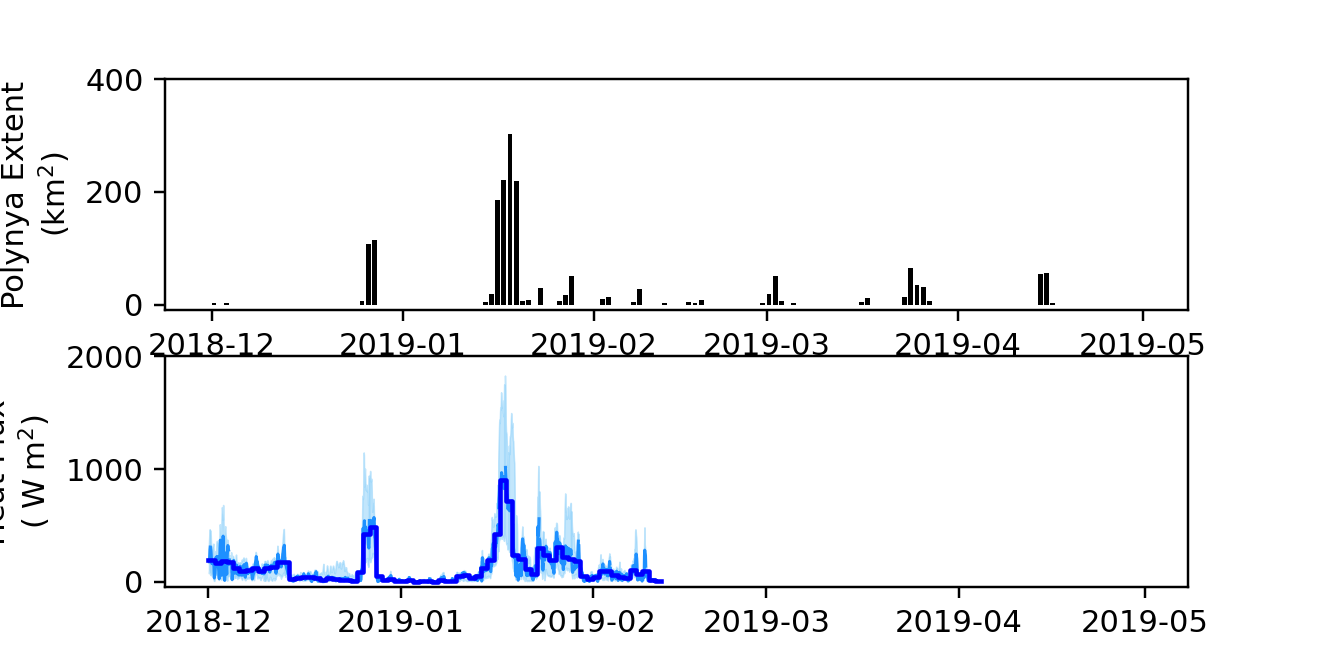

In [540]:
%matplotlib notebook

fig, axs = plt.subplots(2, 1, figsize=(6,3))

ax = axs[0]
ax.set_ylim(-10,400)
ax.bar(DS.time, DS.extent/20, align='edge', color='k')
ax.set_ylabel('Polynya Extent\n($\mathrm{km^2}$)')
# ax.bar(DS.time, DS.length, align='edge', color='gray')

ax = axs[1]
ax.set_ylim(-0.5*100,2000)
# ax2.plot(ds.time, (trap_OHT/dz).to('W/m2')/(10**4), lw=1, c='k')
# ax2.set_ylabel('Horizontal\nheat transport\n($10^3\mathrm{\;W\;m^2}$)')
# ax2.plot(ds.time, ds4.se/10, c='gray')

ax.fill_between(ds.time, THF_min, THF_max, color='lightskyblue', lw=0.5, alpha=0.5)
ax.plot(ds.time, THF, lw=1, c='dodgerblue')
ax.step(DS.time, daily_THF, color='b', where='post', zorder=2)

# ax2=ax.twinx()
# ax2.step(ds.time, ds2.dT.sel(depth=-16), color='r', zorder=2)


ax.set_ylabel('Turbulent\nOcean-Ice\nHeat Flux\n($\mathrm{\;W\;m^2}$)')
# THF

ax.set_xlim(datetime(2018,12,1)-timedelta(days=7), datetime(2019,5,1)+timedelta(days=7))

    
fig.savefig('/Users/mackenziejewell/Desktop/img.png', dpi=300, bbox_inches='tight')

<IPython.core.display.Javascript object>


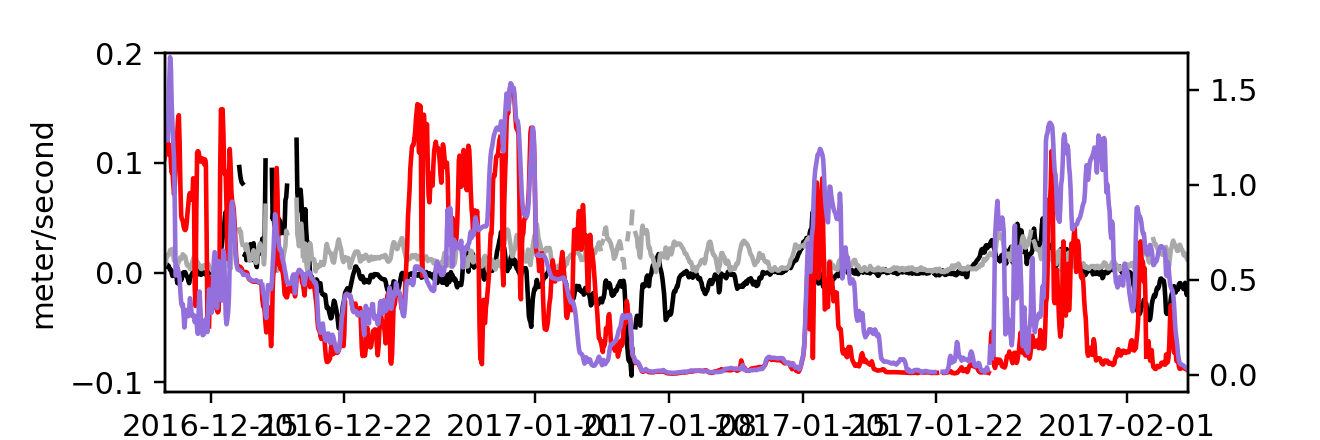

In [403]:
%matplotlib notebook

fig, ax = plt.subplots(figsize=(6,2))
# ax.set_ylim(-100,400)

ax.plot(ds3.time, ds3.se/10, color='k')
# ax.plot(ds3.time, ds.se.mean(dim='depth'), color='gray')

ax.plot(ds3.time, us, color='darkgray')

ax2 = ax.twinx()
ax2.plot(ds2.time, ds2.dT.sel(depth=-16), color='r')
ax2.plot(ds2.time, ds2.dT.sel(depth=-22), color='mediumpurple')
# ax.set_ylabel('Polynya Extent\n($\mathrm{km^2}$)')
# ax.bar(DS.time, DS.length, align='edge', color='gray')

## Calculate Integrate Ocean Heat Content

Use trapezoidal rule to estimate integrate ocean heat content
OHC = $\sum{\frac{1}{2} [f(x_i) + f(x_{i+1})}] \Delta x$

$\mathrm{f(z) = C_{p} \;\rho_{o}(z)\; (\Theta(z) - \Theta_{freezing}(z))}$

In [316]:
OHC = np.array([])

Z = np.append(np.array([0]), ds2.depth.values[::-1])

for ii in range(len(Z[:-1])):
    
    print(ii)
    
    za = Z[ii] * units('m')
    zb = Z[ii+1] * units('m')
    
    dz = za - zb
    
    print(f'za = {za}; zb = {zb}; dz = {dz}')
    
    # define upper
    if ii == 0:
        rho_a = (ds2.sel(depth = zb).sig0 + 1000).values * units('kg/m^3')
        dCTa = np.zeros(len(ds2.Ct.sel(depth = zb))) * units('delta_degC')

    else:
        rho_a = (ds2.sel(depth = za).sig0 + 1000).values * units('kg/m^3')
        dCTa = (ds2.Ct - ds2.Tf).sel(depth = za).values * units('delta_degC')
        
    # grab lower
    rho_b = (ds2.sel(depth = zb).sig0 + 1000).values * units('kg/m^3')
    dCTb = (ds2.Ct - ds2.Tf).sel(depth = zb).values * units('delta_degC')
    
    layer_hc = 0.5 * dz

    f_za = cst['Cp_o'] * rho_a * dCTa
    f_zb = cst['Cp_o'] * rho_b * dCTb
    
    OHC = np.append(OHC, 0.5 * (f_za + f_zb) * dz)
    
    
OHC = np.reshape(OHC, (len(Z[:-1]), len(ds2.time), ))

0
za = 0.0 meter; zb = -16.0 meter; dz = 16.0 meter
1
za = -16.0 meter; zb = -22.0 meter; dz = 6.0 meter
2
za = -22.0 meter; zb = -28.0 meter; dz = 6.0 meter
3
za = -28.0 meter; zb = -39.0 meter; dz = 11.0 meter


## Calculate Integrated Ocean Heat Transport

Use trapezoidal rule to estimate integrate ocean heat content
OHC = $\sum{\frac{1}{2} [f(x_i) + f(x_{i+1})}] \Delta x$

$\mathrm{f(z) = C_{p} \;\rho_{o}(z)\; U_{\perp}(z)\; (\Theta(z) - \Theta_{freezing}(z))}$

In [497]:
OHC = np.array([])

Z = np.append(np.array([0]), ds2.depth.values[::-1])

for ii in range(len(Z[:-1])):
    
    print(ii)
    
    za = Z[ii] * units('m')
    zb = Z[ii+1] * units('m')
    
    dz = za - zb
    
    print(f'za = {za}; zb = {zb}; dz = {dz}')
    
    # define upper
    if ii == 0:
        rho_a = (ds2.sel(depth = zb).sig0 + 1000).values * units('kg/m^3')
        dCTa = np.zeros(len(ds2.Ct.sel(depth = zb))) * units('delta_degC')

    else:
        rho_a = (ds2.sel(depth = za).sig0 + 1000).values * units('kg/m^3')
        dCTa = (ds2.Ct - ds2.Tf).sel(depth = za).values * units('delta_degC')
        
    # grab lower
    rho_b = (ds2.sel(depth = zb).sig0 + 1000).values * units('kg/m^3')
    dCTb = (ds2.Ct - ds2.Tf).sel(depth = zb).values * units('delta_degC')
    
    layer_hc = 0.5 * dz

    f_za = cst['Cp_o'] * rho_a * dCTa
    f_zb = cst['Cp_o'] * rho_b * dCTb
    
    OHC = np.append(OHC, 0.5 * (f_za + f_zb) * dz)
    
    
OHC = np.reshape(OHC, (len(Z[:-1]), len(ds2.time), ))

0
za = 0.0 meter; zb = -16.0 meter; dz = 16.0 meter
1
za = -16.0 meter; zb = -22.0 meter; dz = 6.0 meter
2
za = -22.0 meter; zb = -28.0 meter; dz = 6.0 meter
3
za = -28.0 meter; zb = -36.0 meter; dz = 8.0 meter


In [498]:
# times = pd.to_datetime(ds2.time.values)
# times = np.append(times, times[-1] + timedelta(hours=1))

times = pd.to_datetime(ds2.time.values).to_pydatetime()
times = np.append(times, times[-1] + timedelta(hours=1))

time_grid, Zgrid = np.meshgrid(times, Z)#[:-1]+np.diff(Z)/2)

<IPython.core.display.Javascript object>


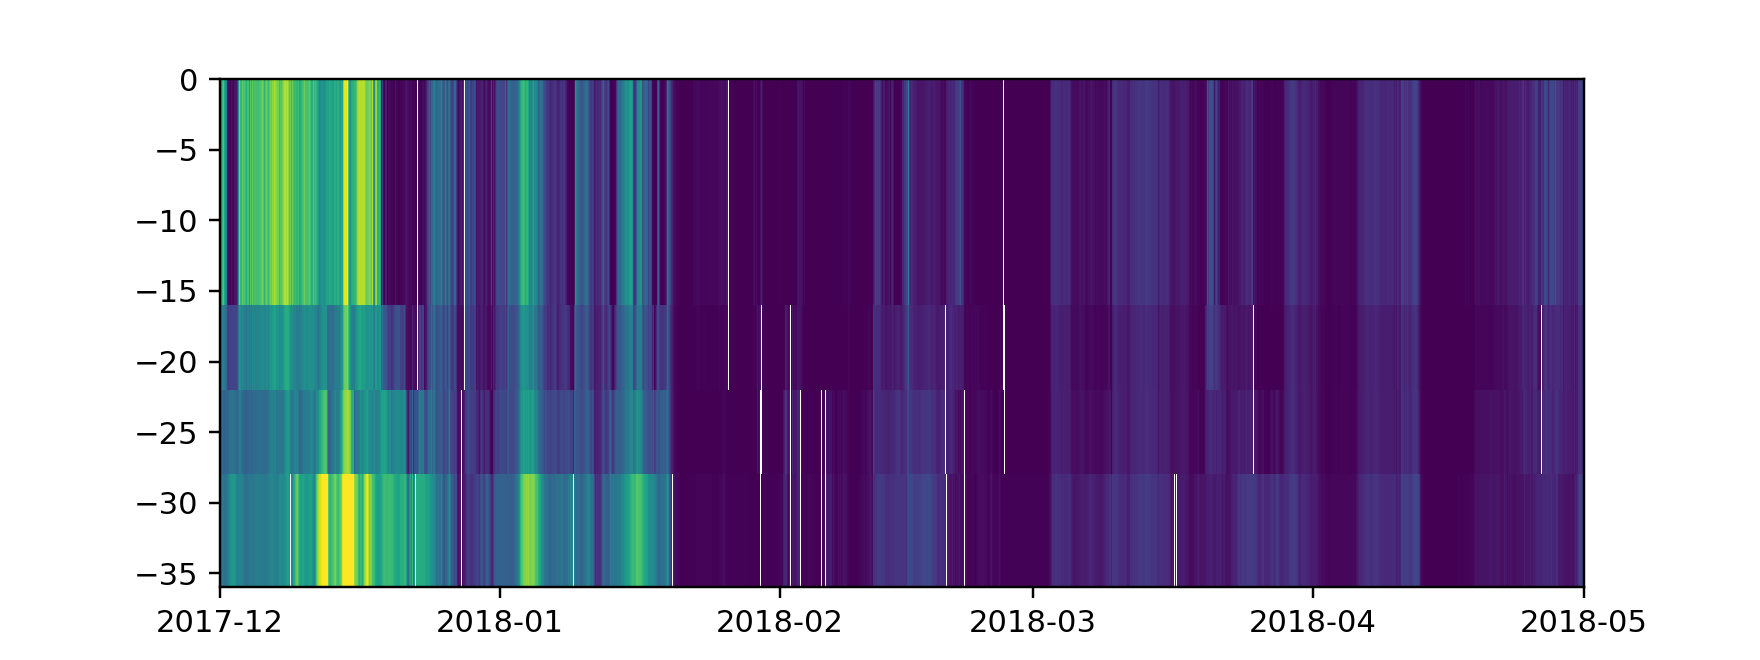

In [499]:
%matplotlib notebook
fig, ax = plt.subplots(figsize=(8,3))
plt.pcolormesh(time_grid, Zgrid, OHC, vmin=500000, vmax = 50000000)

<IPython.core.display.Javascript object>


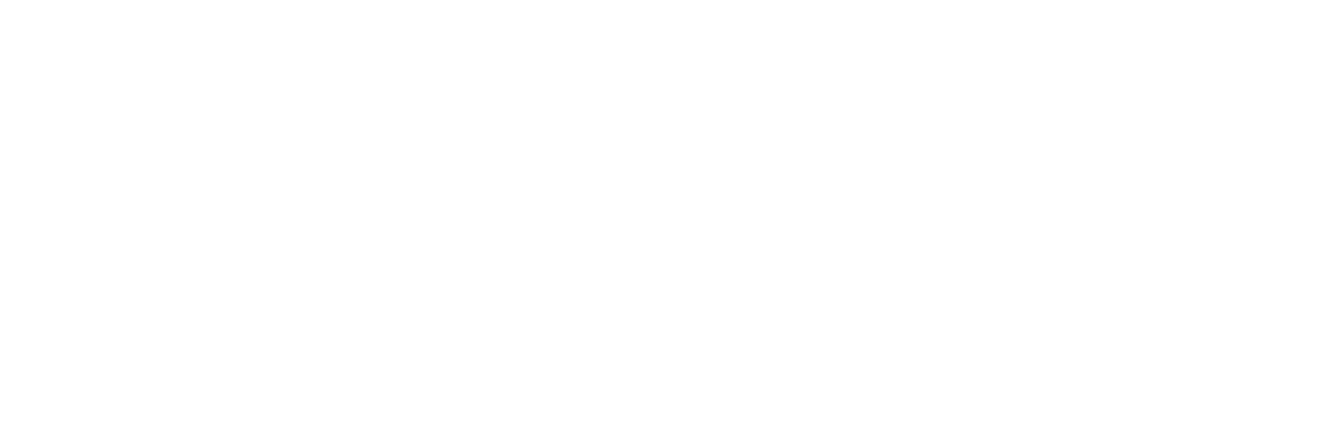

<IPython.core.display.Javascript object>


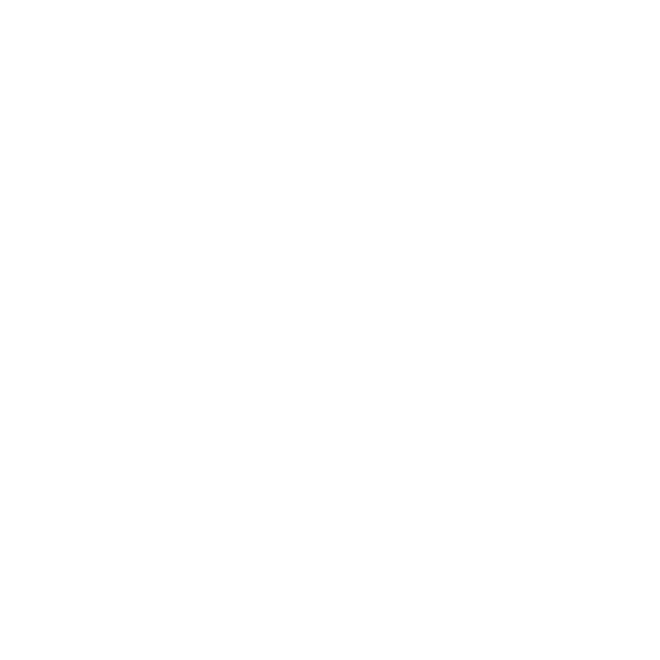

<IPython.core.display.Javascript object>


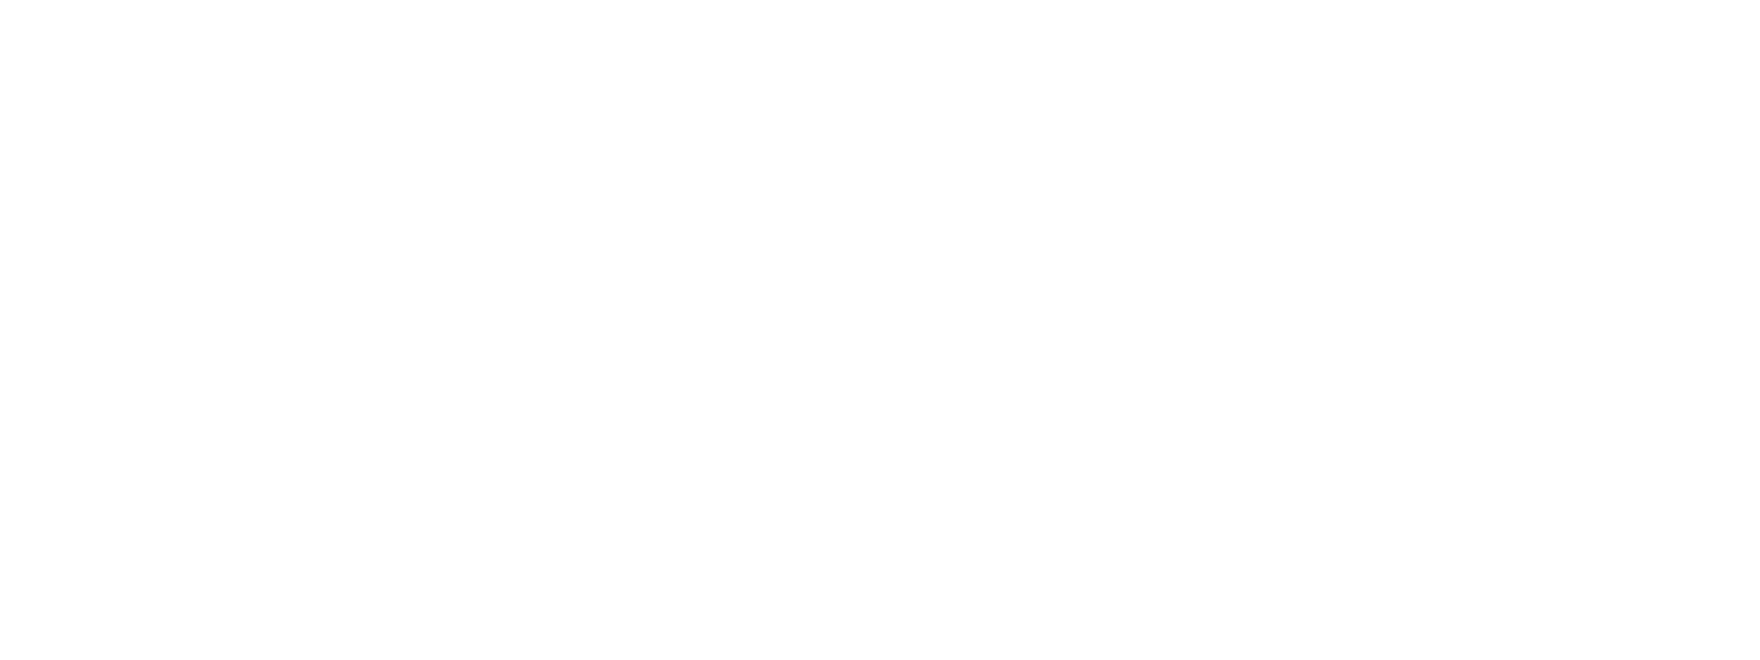

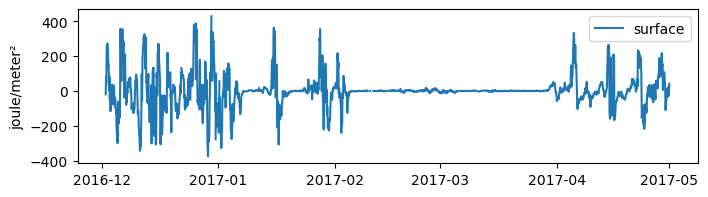

In [320]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(8,2))
# ax.set_ylim(-5000000,150000000)
# plt.plot(ds2.time, np.sum(OHC, axis=0), label = 'total')
# plt.plot(ds2.time, OHC[0,:], label = 'surface')

lag = 24

plt.plot(ds2.time[lag:], (OHC[0,:][lag:] - OHC[0,:][:-lag])/(24*60*60), label = 'surface')
plt.legend()

# ax.set_xlim(datetime(2017,12,1), datetime(2018,2,1))

<IPython.core.display.Javascript object>


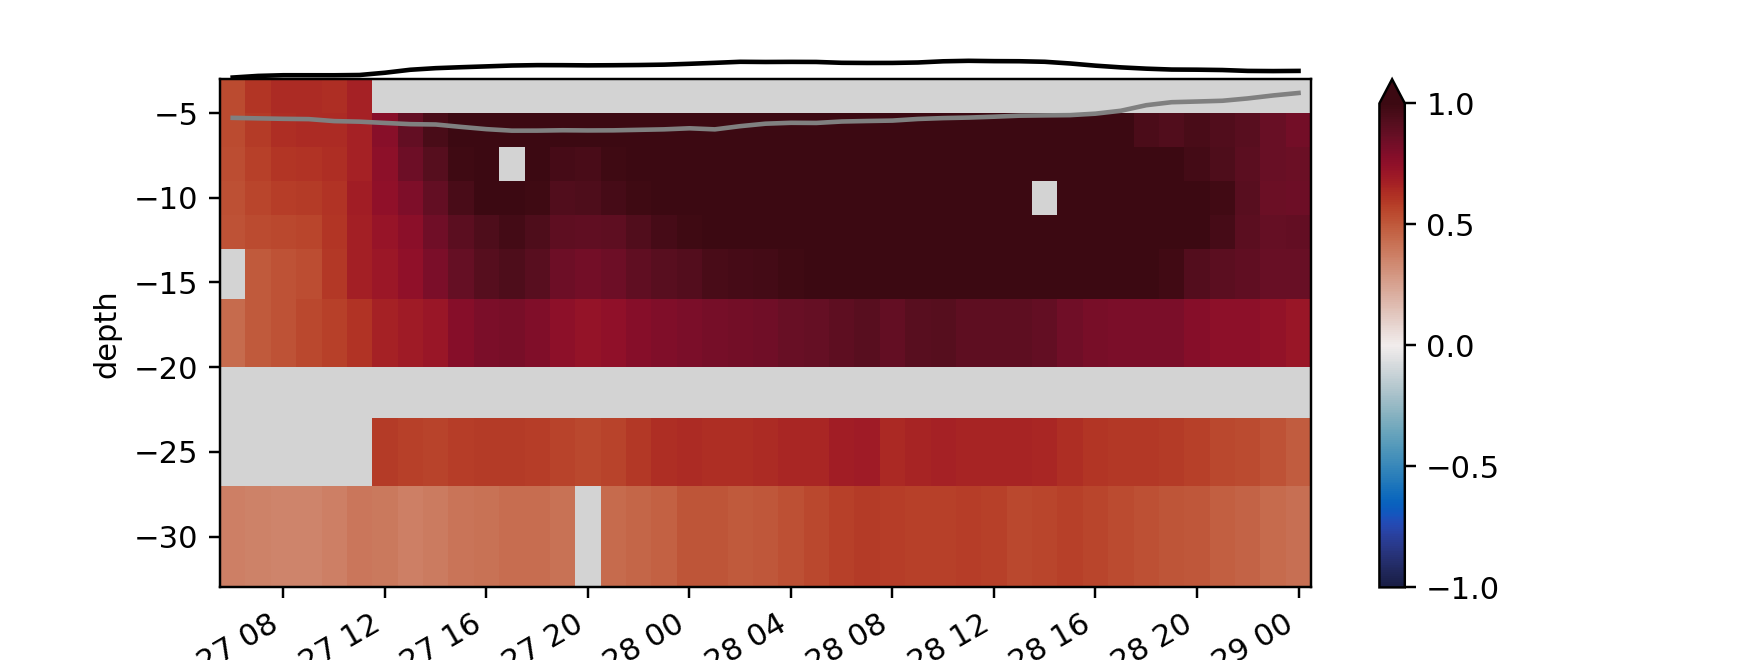

In [1453]:
%matplotlib notebook
fig, ax = plt.subplots(figsize=(8,3))
ax.patch.set_facecolor('lightgray')

# event_time = slice(datetime(2016,12,15), datetime(2016,12,17, 12))

# event_time = slice(datetime(2016,12,15,12), datetime(2016,12,16, 16))

# event_time = slice(datetime(2018,1,13,0), datetime(2018,1,15,12 ))


event_time = slice(datetime(2019,1,27,6), datetime(2019,1,29, ))


along_sfc.sel(time=event_time).plot(vmin=-1, vmax=1, cmap=cmocean.cm.balance)

ax.plot(ds3.time.sel(time=event_time), ds3.se.sel(time=event_time)-3.5, c='k', clip_on=False)


ax.plot(ds3.time.sel(time=event_time), 0.2*ds4.u10.sel(time=event_time)-3.5, c='gray', clip_on=False)


In [1454]:

print(M1)

{'lon': array([-139.2582]), 'lat': array([69.7718]), 'xx': 29546.27257084566, 'yy': -2281992.6265499666}


In [1455]:
import pyproj

def conv(projection, lon, lat, eastward = 1*units('m/s'), northward = 1*units('m/s')):

    """
    INPUT:
    - projection: projection to get final vector coordinates in 
    - eastward: eastward velocity component (with units)
    - northward: northward velocity component (with units)
    - lon: starting lon of vector (tail)
    - lat: starting lat of vector (tail)
    """
    
    # find vector speed and angle
    # theta defined CCW from eastward
    theta = vectors.vector_angle(eastward, northward)
    S = np.sqrt(eastward**2 + northward**2)
    
    # Define the bearing (in degrees) and the distance to travel (in meters)
    # bearing defined CW form northward
    #==================
    bearing = - (theta - 90 * units('degree'))
    distance = S.to('m/day') * units('day')    # m traveled in a day
    #==================
    
    geod = pyproj.Geod(ellps='WGS84') # Create a Geod object
    
    # find ending lon, lat of vector (m traveled over a day)
    vlon, vlat, _ = geod.fwd(lon, lat, bearing, distance)
    
    # find coordinates of vector end point (tip)
    tipx_proj, tipy_proj = projection.transform_point(vlon, vlat, ccrs.PlateCarree())

    # find coordinates of vector start point (tail)
    tailx_proj, taily_proj = projection.transform_point(lon, lat, ccrs.PlateCarree())

    # find vector difference between start and end points
    # this assumes coordinates of projection are units
    u = np.array([tipx_proj - tailx_proj]) * units('m')
    v = np.array([tipy_proj - taily_proj]) * units('m')
    
    tail = (tailx_proj, taily_proj)
    tip = (tipx_proj, tipy_proj)
    vec = (u,v)
    
    return tail, tip, vec





<IPython.core.display.Javascript object>


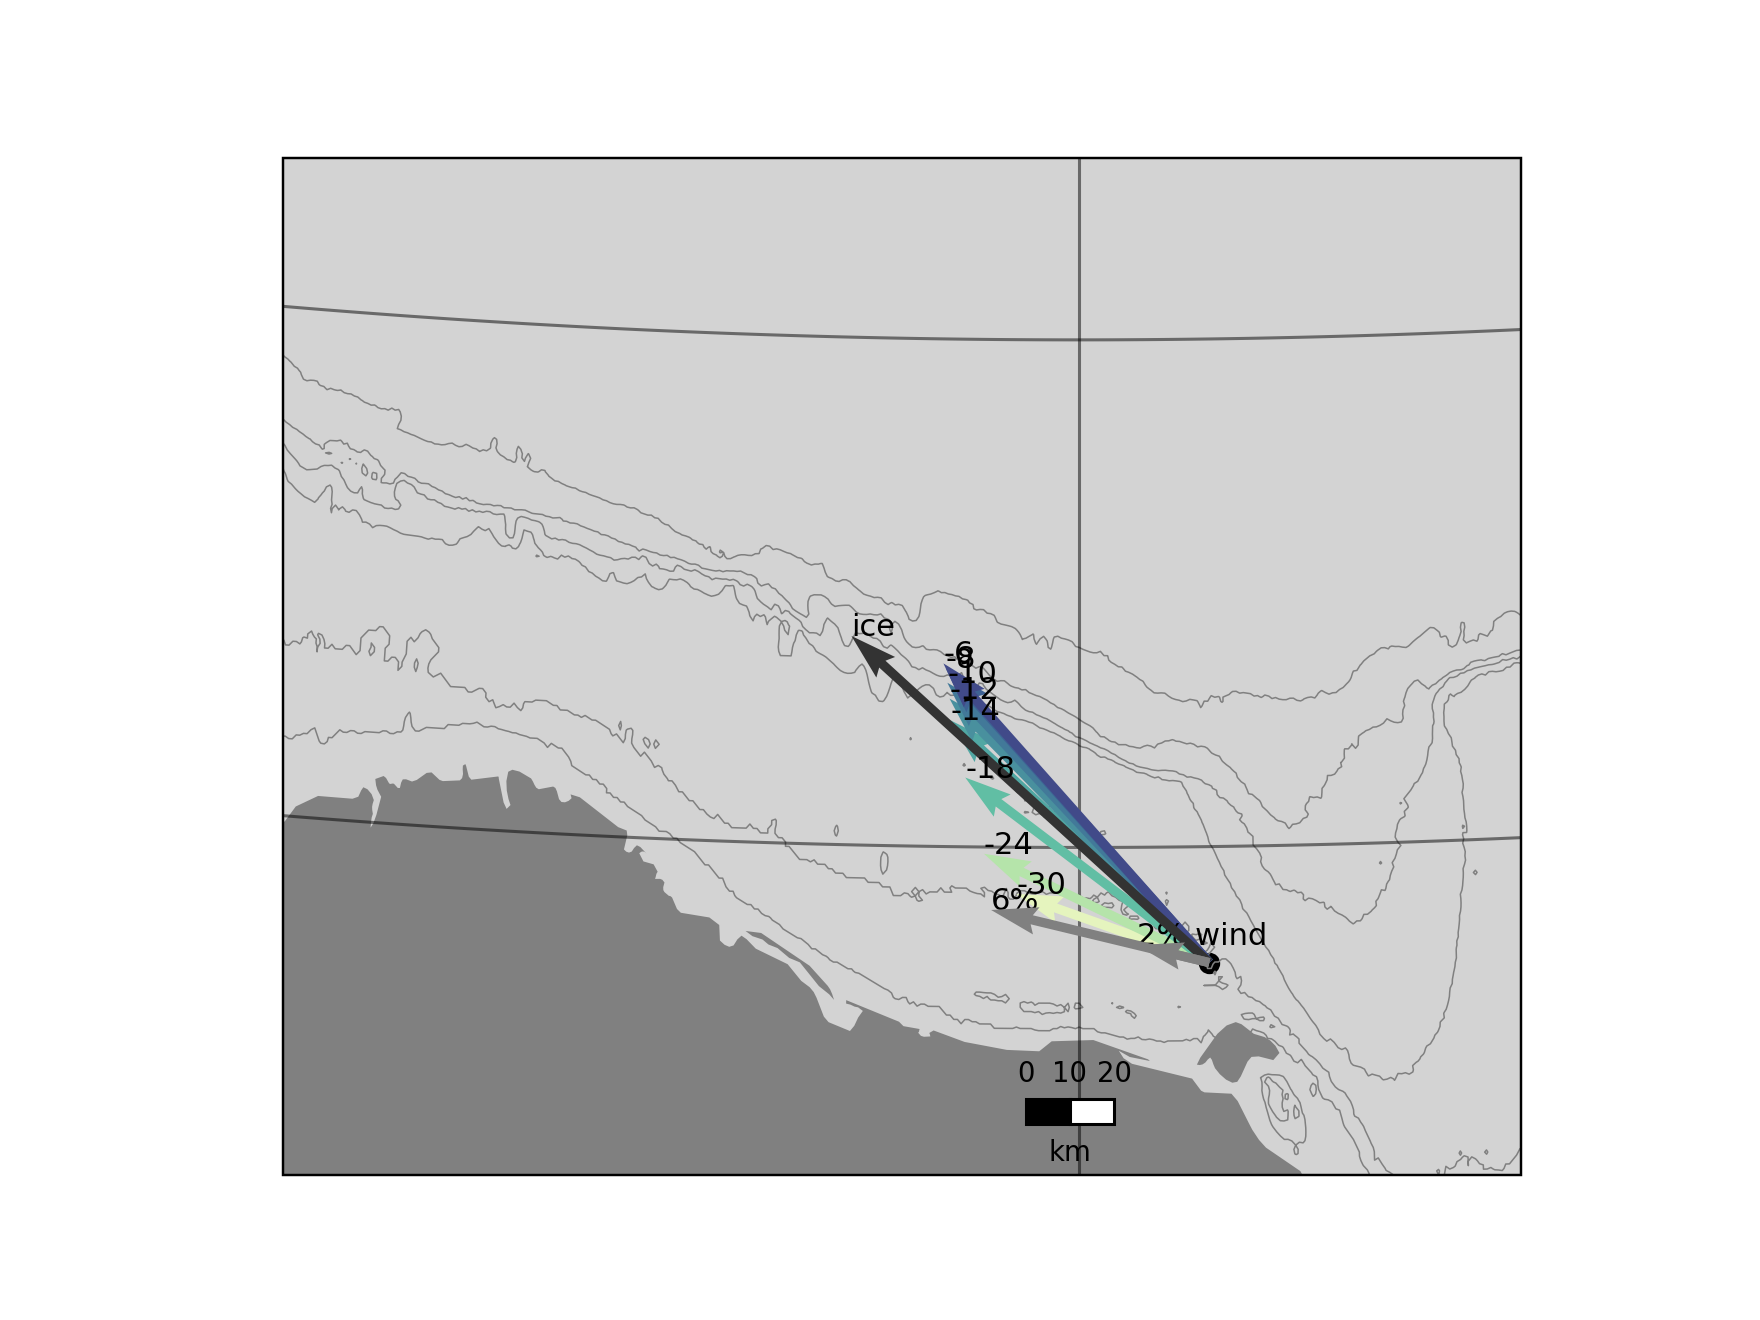

In [1456]:

fig, ax = plt.subplots(subplot_kw=dict(projection=map_proj), figsize=(8,6))

ax.set_xlim(-180000,100000)
ax.set_ylim(-2330000,-2100000)
ax.set_facecolor('lightgray')
geomap.land(ax, scale = '10m', color='gray', alpha=1, fill_dateline_gap = True, zorder=2)
geomap.grid(ax, lats = np.arange(69,75,1), lons = np.arange(200,250,5) , color='k')

geomap.scalebar(ax, loc=(0.6, 0.05), stepsize=10, numsteps=2, unit='km', label=None, 
                colors=['k', 'w'], edgecolor=None, textsize=9, lw=1, bar_width=0.025,
                labelpad=0.015, ticklabelpad=0.01, zorder=100)

ax.scatter(*tail, c='k')


label_side = 'left'

geomap.gebco_bathymetry(ax, file_path='/Volumes/Seagate_Jewell/KenzieStuff/GEBCO/GEBCO_2024/gebco_2024_n90.0_s55.0_w-180.0_e180.0.nc', 
                        crop_lat=(69, 71), crop_lon=(-147, -135), clat=2, clon=5, 
                        contour_labels=False,
                        contour_levels=[-500,-300,-200,-100,  -40,-20],
                        contour_kwargs={'colors': 'gray', 'linewidths': 0.5, 'linestyles': 'solid', 'zorder': 1},
                        depth_shade=False)


# wind
U = 0.06 * np.array([ds4.u10.sel(time=event_time).mean(dim='time').values]) * units('m/s')
V = 0.06 * np.array([ds4.v10.sel(time=event_time).mean(dim='time').values]) * units('m/s')
tail, tip, vec = conv(map_proj, M1['lon'], M1['lat'], eastward = U, northward = V)
ax.quiver(*tail, *vec, color='gray', pivot='tail', angles='xy', scale_units='xy', scale=1, zorder=4)
ax.text(*tip, '6%', ha=label_side, color='k',)

U = 0.02 * np.array([ds4.u10.sel(time=event_time).mean(dim='time').values]) * units('m/s')
V = 0.02 * np.array([ds4.v10.sel(time=event_time).mean(dim='time').values]) * units('m/s')
tail, tip, vec = conv(map_proj, M1['lon'], M1['lat'], eastward = U, northward = V)
ax.quiver(*tail, *vec, color='gray', pivot='tail', angles='xy', scale_units='xy', scale=1, zorder=4)
ax.text(*tip, '2% wind', ha=label_side, color='k',)

# ice drift 
Ui = np.array([ds3.u.sel(time=event_time).mean(dim='time').values]) * units('m/s')
Vi = np.array([ds3.v.sel(time=event_time).mean(dim='time').values]) * units('m/s')
tail, tip, vec = conv(map_proj, M1['lon'], M1['lat'], eastward = Ui, northward = Vi)
ax.quiver(*tail, *vec, color=[0.2,0.2,0.2], pivot='tail', angles='xy', scale_units='xy', scale=1, zorder=3)
ax.text(*tip, 'ice', ha=label_side, color='k',)

# ocean currents
color_list = cmocean.cm.deep(np.linspace(0.05,0.85,len(ds.depth.values)))
for dd, depth in enumerate(ds.depth.values):
    
    color = color_list[dd]
    ffrac = np.sum(np.isfinite(ds.u.sel(depth = depth, time=event_time))).values / len(ds.time.sel(time=event_time).values)
    
    if ffrac > 0.5:

        
        U = np.array([ds.u.sel(depth = depth, time=event_time).mean(dim='time').values]) * units('m/s')
        V = np.array([ds.v.sel(depth = depth, time=event_time).mean(dim='time').values]) * units('m/s')

        tail, tip, vec = conv(map_proj, M1['lon'], M1['lat'], eastward = U, northward = V)
        ax.quiver(*tail, *vec, color=color, pivot='tail', angles='xy', scale_units='xy', scale=1, zorder=2)
        ax.text(*tip, f'{depth:.0f}', ha=label_side, color='k',)



<IPython.core.display.Javascript object>


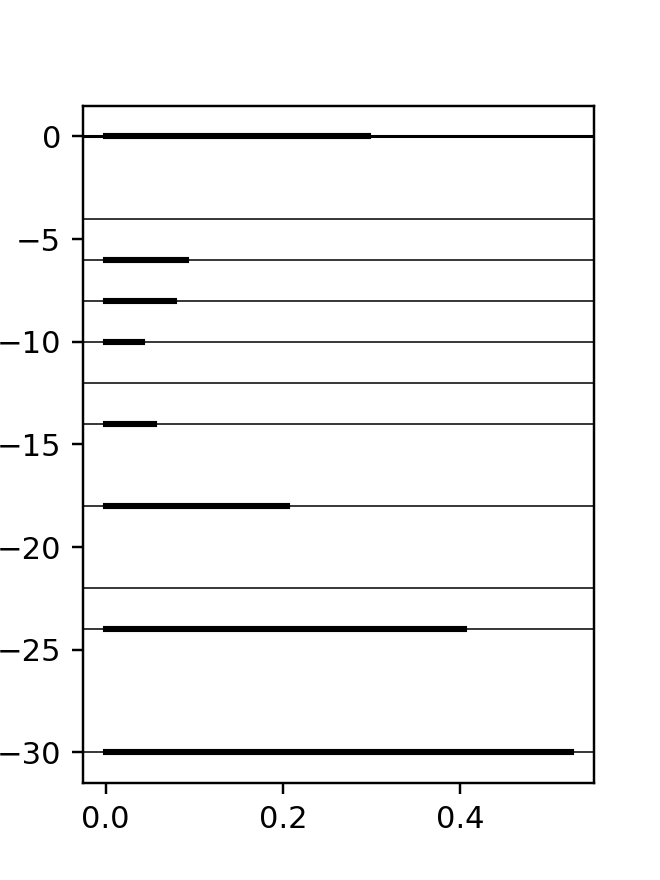

In [1481]:
# ice drift 
# Ui = np.array([ds3.u.sel(time=event_time).mean(dim='time').values]) * units('m/s')
# Vi = np.array([ds3.v.sel(time=event_time).mean(dim='time').values]) * units('m/s')

Ui = np.array([ds.u.sel(depth=-12).sel(time=event_time).mean(dim='time').values]) * units('m/s')
Vi = np.array([ds.v.sel(depth=-12).sel(time=event_time).mean(dim='time').values]) * units('m/s')

fig, ax = plt.subplots(figsize=(3,4))
ax.axhline(0, lw=1, c='k', zorder=0)
# ax.set_xlim(-0.1,1)
# ocean currents
color_list = cmocean.cm.deep(np.linspace(0.05,0.85,len(ds.depth.values)))
for dd, depth in enumerate(ds.depth.values):
    
    ax.axhline(depth, lw=0.5, c='k', zorder=0)
    color = color_list[dd]
    ffrac = np.sum(np.isfinite(ds.u.sel(depth = depth, time=event_time))).values / len(ds.time.sel(time=event_time).values)
    
    if ffrac > 0.5:

        U = np.array([ds.u.sel(depth = depth, time=event_time).mean(dim='time').values]) * units('m/s')
        V = np.array([ds.v.sel(depth = depth, time=event_time).mean(dim='time').values]) * units('m/s')
        
        vec_diff = np.sqrt((Ui-U)**2 + (Vi-V)**2).magnitude[0]
        
        ax.plot([0,vec_diff], [depth,depth], c='k', lw=2)

        
U = np.array([ds3.u.sel(time=event_time).mean(dim='time').values]) * units('m/s')
V = np.array([ds3.v.sel(time=event_time).mean(dim='time').values]) * units('m/s')

vec_diff = np.sqrt((Ui-U)**2 + (Vi-V)**2).magnitude[0]
depth=0
ax.plot([0,vec_diff], [depth,depth], c='k', lw=2)




<IPython.core.display.Javascript object>


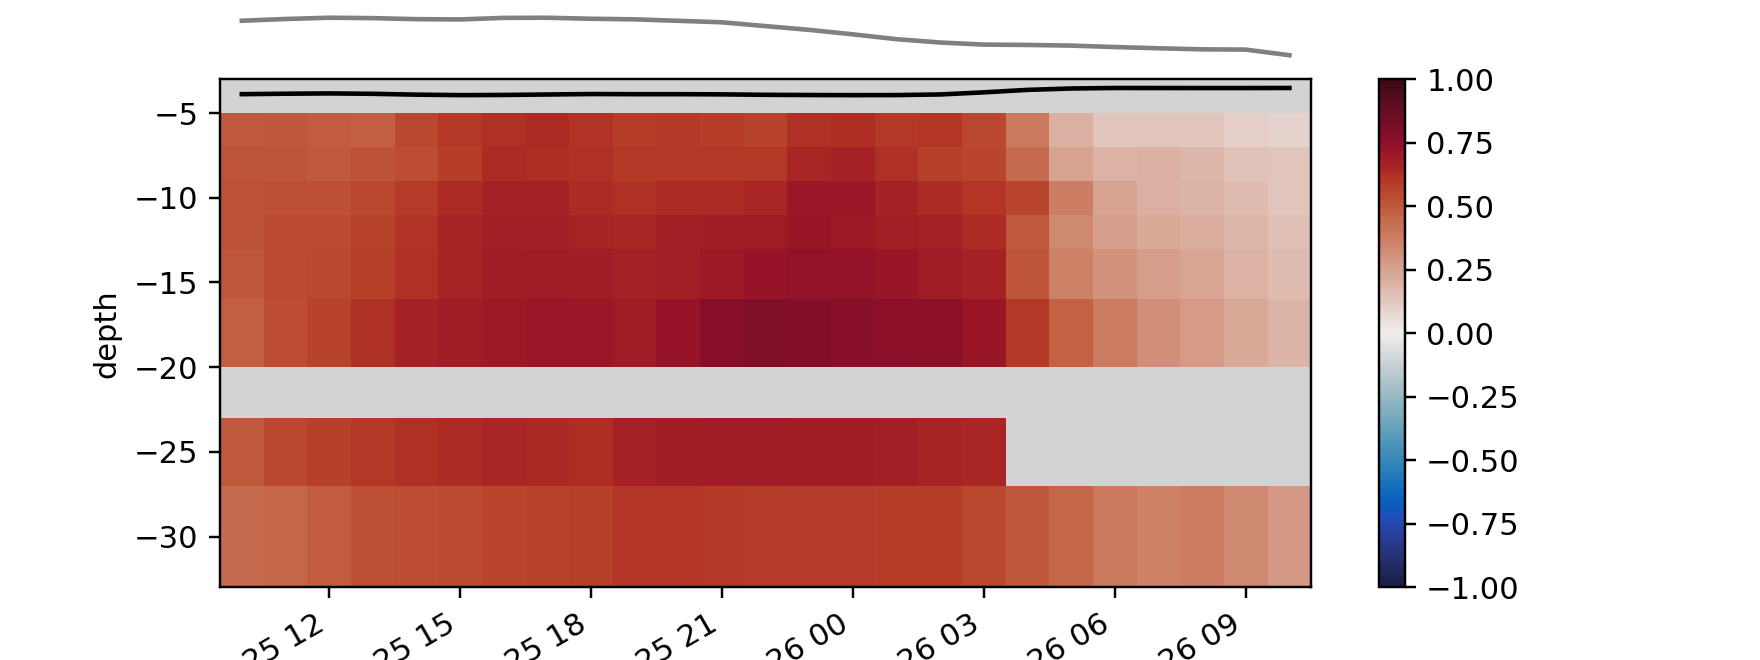

In [1680]:
%matplotlib notebook
fig, ax = plt.subplots(figsize=(8,3))
ax.patch.set_facecolor('lightgray')

# event_time = slice(datetime(2016,12,15), datetime(2016,12,17, 12))

# event_time = slice(datetime(2016,12,15,12), datetime(2016,12,16, 16))

# event_time = slice(datetime(2018,1,13,0), datetime(2018,1,15,12 ))


# event_time = slice(datetime(2019,1,27,6), datetime(2019,1,29, ))

# event_time = slice(datetime(2019,1,28,6), datetime(2019,1,29, ))
# event_time = slice(datetime(2019,1,27), datetime(2019,1,31, ))
event_time = slice(datetime(2018,2,25,10), datetime(2018,2,26, 10))

along_sfc.sel(time=event_time).plot(vmin=-1, vmax=1, cmap=cmocean.cm.balance)

ax.plot(ds3.time.sel(time=event_time), ds3.se.sel(time=event_time)-3.5, c='k', clip_on=False)


ax.plot(ds3.time.sel(time=event_time), 0.2*ds4.u10.sel(time=event_time)-3.5, c='gray', clip_on=False)


/opt/anaconda3/envs/SBSpolynya/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


<IPython.core.display.Javascript object>


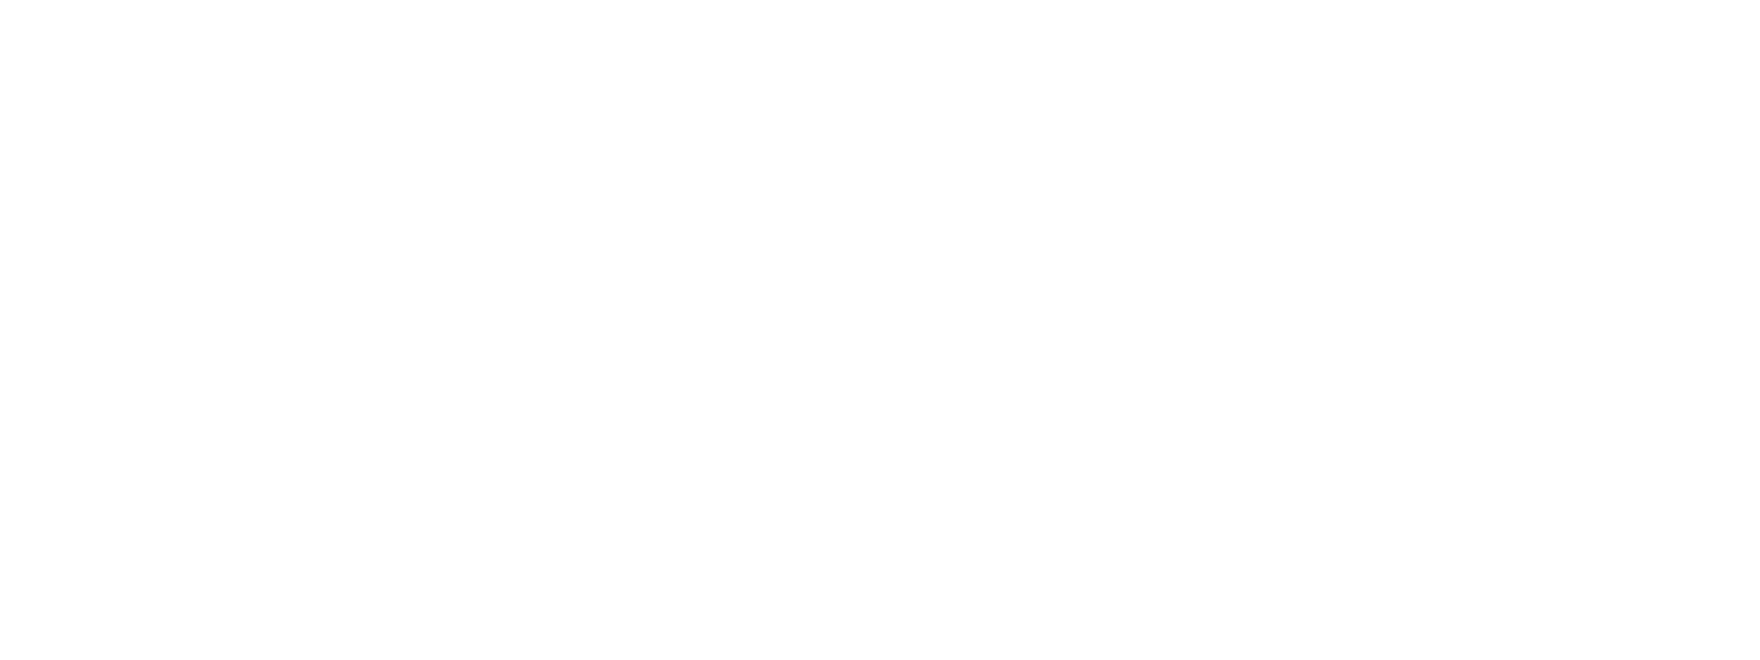

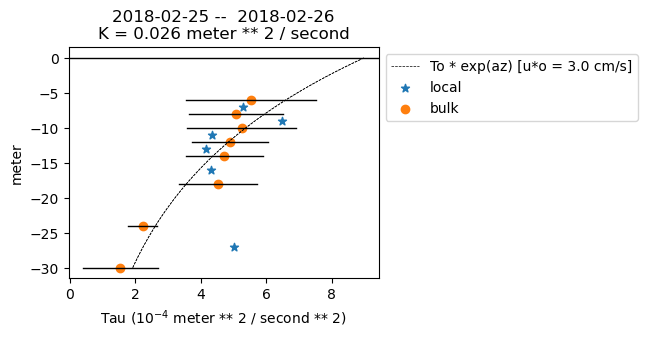

In [1681]:
%matplotlib inline

def simple_exp_tau(z, K = 0.026 * units('m2/s'), lat = 70, To = 10*10**(-4) * units('m2/s2')):
    
    # coriolis frequency
    om = 7.2921 * 10 **(-5)
    f = 2 * om * np.sin(lat*np.pi/180) * units('s')**(-1)
    a = np.sqrt(0.5*f/K)
    T = To * np.exp(a * z)
    
    return T

    




scale = 10**(-4)
fig, ax = plt.subplots(figsize=(4,3))
ax.axhline(0, lw=1, c='k', zorder=0)

z = np.linspace(-30,0,100) * units('m')


K = 0.026 * units('m2/s')


Uos = np.array([0.03]) * units('m/s')
Tos = Uos**2

for To in Tos:
    T = simple_exp_tau(z, To = To, K = K)
    plt.plot(T/scale, z, ls = 'dashed', c='k', lw=0.5)
    
uslabel = (Uos[0].to('cm/s')).magnitude
plt.plot(T/scale, z, ls = 'dashed', c='k', lw=0.5, label=f'To * exp(az) [u*o = {uslabel:.1f} cm/s]')

Ui = ds3.u
Vi = ds3.v

urel = (ds.u - Ui) 
vrel = (ds.v - Vi)

dudz_x = (urel / ds.depth ) * (1/units('s'))
dudz_y = (vrel / ds.depth ) * (1/units('s'))
dudz = np.sqrt(dudz_x**2+dudz_y**2)
# zmid = (ds.depth[:-1].values + ds.depth.diff('depth').values/2) * units('m')


z = ds.depth.values * units('m')
event_shear = dudz.sel(time=event_time).mean(dim='time').values * (1/units('s'))
event_shear_std = dudz.sel(time=event_time).std(dim='time').values * (1/units('s'))



dudz_x = ds.u.diff('depth') / ds.depth.diff('depth')
dudz_y = ds.v.diff('depth') / ds.depth.diff('depth')
dudz = np.sqrt(dudz_x**2+dudz_y**2)

shear_local = dudz.sel(time=event_time).mean(dim='time').values

top_z = ds.depth[-1]
top_shear = np.sqrt((urel.sel(depth=top_z)/ (top_z))**2+(vrel.sel(depth=top_z)/ (top_z))**2)
shear_local = np.append(shear_local, top_shear.sel(time=event_time).mean(dim='time'))
shear_local = shear_local * (1/units('s'))

TL = (shear_local * K)
zmid = (ds.depth[:-1].values + ds.depth.diff('depth').values/2) 
zmid = np.append(zmid, top_z/2)
zmid = zmid * units('m')
plt.scatter(TL/scale, zmid, marker='*', label='local', zorder=2)

T2 = (event_shear * K)
T2min = ((event_shear - event_shear_std) * K)
T2max = ((event_shear + event_shear_std) * K)

plt.scatter(T2/scale, z, label='bulk', zorder=1)

for min_, max_, z_ in zip(T2min.magnitude, T2max.magnitude, z.magnitude):
    plt.plot([min_/scale, max_/scale], [z_,z_], c='k', lw=1)
    
    

# ax.set_xlim(-0.0001/scale,0.002/scale) 
plt.xlabel('Tau ($10^{-4}$'+f' {T2.units})')
plt.legend(bbox_to_anchor=(1,1))



ax.set_title(f'{event_time.start.date()} --  {event_time.stop.date()}\nK = {K}')

fig.savefig(f'./figures/stress/stress_profile_{event_time.start.date()}_{event_time.stop.date()}.png', dpi=300, bbox_inches = 'tight', pad_inches=0)

array([7200000000000, 7200000000000, 7200000000000, ..., 7200000000000,
       7200000000000, 7200000000000], dtype='timedelta64[ns]')

# Newton Iteration

https://personal.math.ubc.ca/~anstee/math104/newtonmethod.pdf 

In [1709]:

import cmath

In [2134]:
def create_V(depth, date):

    # ocean vector (in cm/s)
    uo = (ds.u.sel(depth=depth).sel(time=date).data * units('m/s').to('cm/s')).magnitude
    vo = (ds.v.sel(depth=depth).sel(time=date).data * units('m/s').to('cm/s')).magnitude
    Uo = complex(uo, vo)
    
    # ice vector (in cm/s)
    ui = (ds3.u.sel(time=date).data * units('m/s').to('cm/s')).magnitude
    vi = (ds3.v.sel(time=date).data * units('m/s').to('cm/s')).magnitude
    Ui = complex(ui, vi)
    
    # ice velocity with ocean removed
    V = Ui - Uo
    # Get polar coordinates
    # r, phi = cmath.polar(V)

    return Uo, Ui, V

In [2135]:


def newton_iter(xn, V, k = 0.4, A = 2.3, B = 2.1, lat = 70, z0 = 5 * units('cm')):
    
    # coriolis frequency
    om = 7.2921 * 10 **(-5)
    f = 2 * om * np.sin(lat*np.pi/180) * units('s')**(-1)
    
    # surface friction rossby number
    unm = cmath.polar(xn)[0] * units('cm/s')
    
    
    unR = xn.real
    alpha = 1/(f*z0)
    c = complex(A, B)
    
    
    Fn = V - (1/k) * (np.log(alpha*unm) - c) * xn
    dFdun = - (1/k) * ((unR/unm.magnitude**2)*xn + np.log(alpha*unm) - c)
    
    xnp1 = xn - Fn/dFdun
    
    return xnp1, Fn


In [2155]:
starttime = datetime.now()

dates = pd.date_range(datetime(2017,12,1), datetime(2018,4,30), freq = '6H')

us0 = {}
z0_vals = [0.001, 0.05] # in units of m
depths = [-30,-12,-6]

for z0 in z0_vals:
    us0[z0] = {}
    for depth in depths:
        us0[z0][depth] = np.array([])
    

for date in dates:
    
    for z0 in z0_vals:
    
        for depth in depths:
            
            all_us = np.array([])

            # relaive ice-ocean velocities
            Uo, Ui, V = create_V(depth, date)

            # initial guess
            x0 = 5 * cmath.exp(1j * np.pi/4)
            
            # newton iteration
            #-----------------
            guesses = [x0]
            tolerance = 0.001
            num_iter = 50

            for ii in range(num_iter):

                xn = guesses[-1]
                xnp1, Fn = newton_iter(xn, V, k = cst['kappa'], A = 2.3, B = 2, z0 = z0 * units('m'))
                guesses.append(xnp1)

                dx = xnp1 - xn
                if cmath.polar(dx)[0] < tolerance:
                    break

            if ii < num_iter-1:
                us0[z0][depth] = np.append(us0[z0][depth], guesses[-1])
            else:
                us0[z0][depth] = np.append(us0[z0][depth], np.nan)

                
# grab magnitudes
usm = {}
for z0 in z0_vals:
    usm[z0] = {}
    for depth in depths:
        usm[z0][depth] = np.array([])
        for us in us0[z0][depth]:
            usm[z0][depth] = np.append(usm[z0][depth], cmath.polar(us)[0])
            
print(f'>>>> runtime: {datetime.now() - starttime}')

>>>> runtime: 0:01:11.068019


<IPython.core.display.Javascript object>


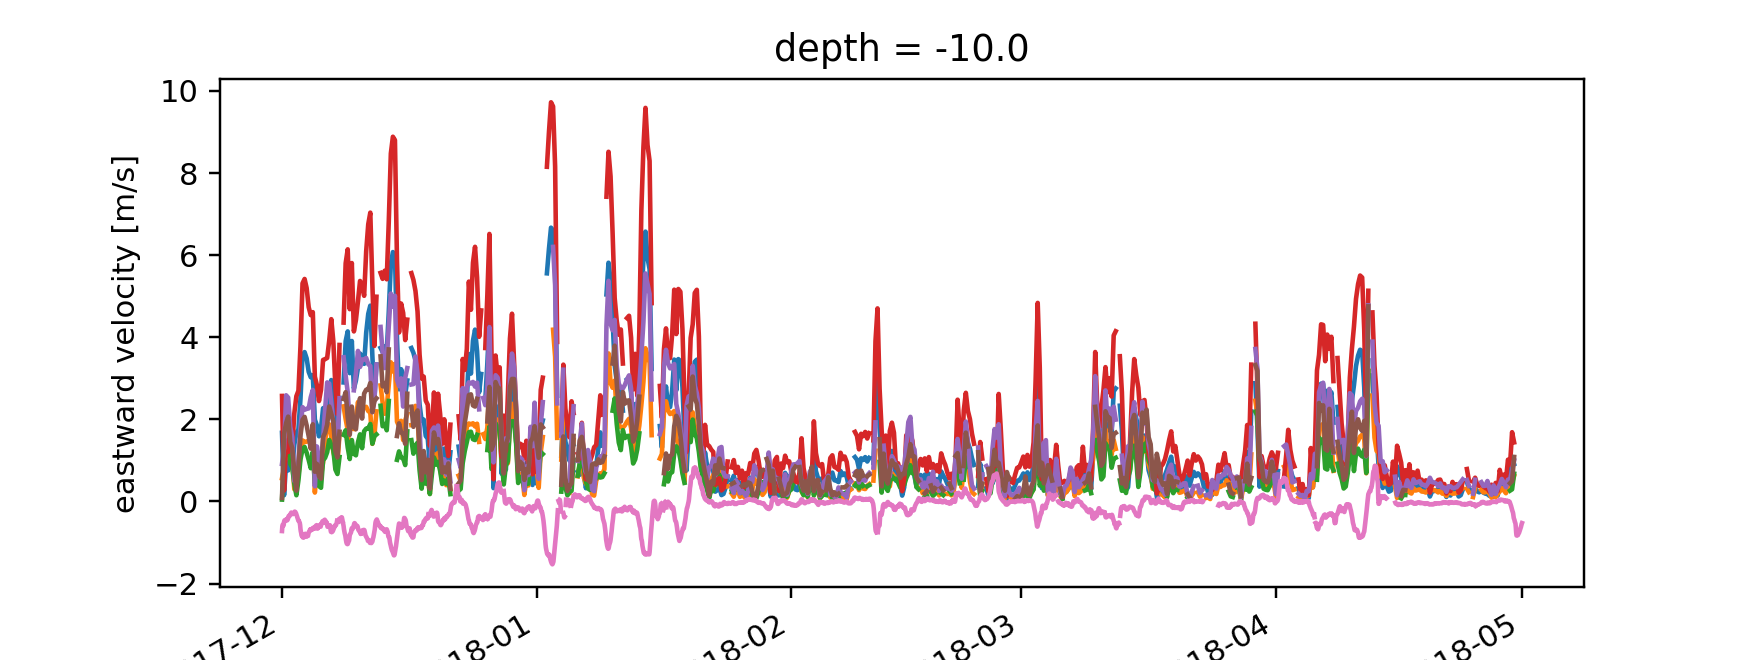

In [2158]:
fig, ax = plt.subplots(figsize=(8,3))
# plt.plot(dates, us['-12'])

for z0 in z0_vals:
    plt.plot(dates, usm[z0][-30])
    plt.plot(dates, usm[z0][-12])
    plt.plot(dates, usm[z0][-6])


In [2160]:
depth

-6

<IPython.core.display.Javascript object>


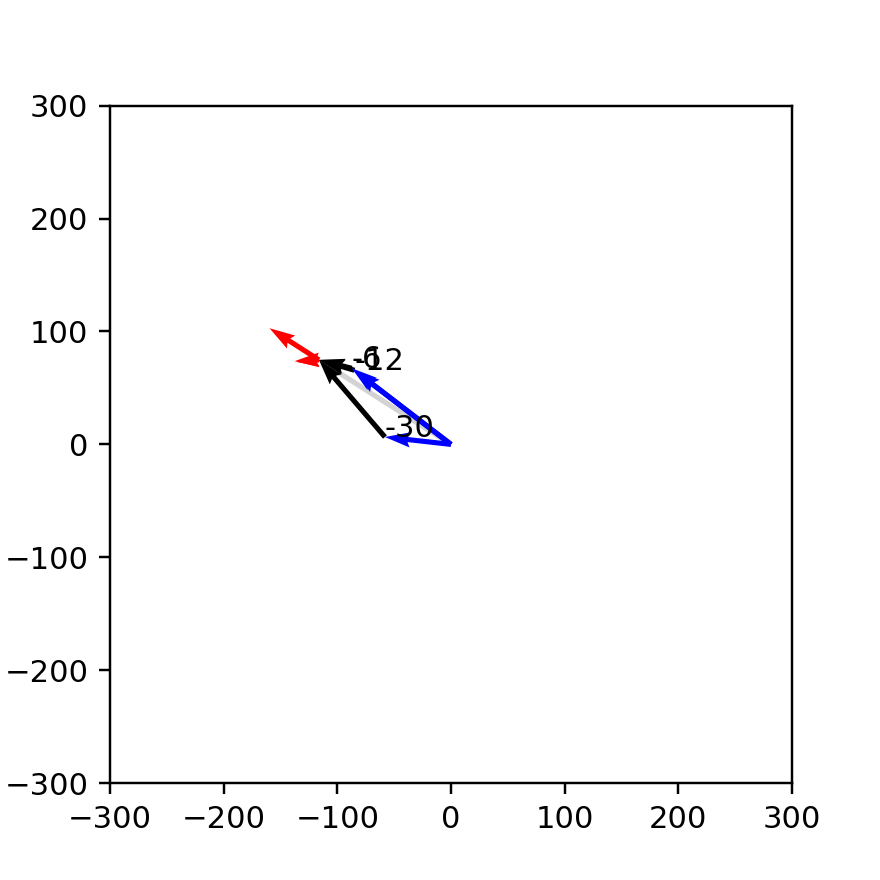

-159.66093844051068  102.86218277968763  -30
-137.53659492792661  73.73702947640463  -12
-135.9227278739465  73.06300295734566  -6


In [2198]:



fig, ax = plt.subplots(figsize=(4,4))
size=300
ax.set_xlim(-size,size)
ax.set_ylim(-size,size)
    


date = datetime(2018,1,18,6)
di = np.where(dates == date)[0][0]

Uo, Ui, V = create_V(depth, date)
plt.quiver(0, 0, Ui.real, Ui.imag, angles='xy', scale_units='xy', scale=1, pivot='tail', color='lightgray')

# relaive ice-ocean velocities
for depth in depths:
    
    Uo, Ui, V = create_V(depth, date)
    ax.quiver(0, 0, Uo.real, Uo.imag, angles='xy', scale_units='xy', scale=1, pivot='tail', color='b')
    ax.quiver(Uo.real, Uo.imag, V.real, V.imag, angles='xy', scale_units='xy', scale=1, pivot='tail', color='k')
    ax.text(Uo.real, Uo.imag, depth, zorder=100)

    z0 = 0.05
    
    usx = 10*us0[z0][depth][di].real
    usy = 10*us0[z0][depth][di].imag
    
    ax.quiver(Ui.real, Ui.imag, usx, usy, angles='xy', scale_units='xy', scale=1, pivot='tail', color='r')
    print(Ui.real+usx, Ui.imag+usy, depth)
#     ax.text(Ui.real+usx, Ui.imag+usy, depth, zorder=100)
    
# plt.quiver(0, 0, x0.real, x0.imsag, angles='xy', scale_units='xy', scale=1, pivot='tail', color='b')

# plt.quiver(Uo.real, Uo.imag, V.real, V.imag, angles='xy', scale_units='xy', scale=1, pivot='tail', color='gray')


<IPython.core.display.Javascript object>


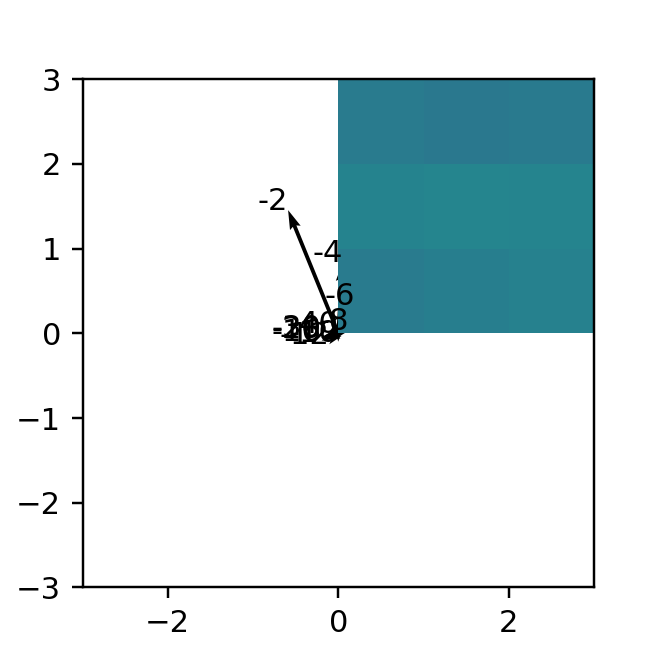

(-3.0, 3.0)

In [1336]:
#https://en.wikipedia.org/wiki/Ekman_spiral#cite_note-GFD-3

Av = 10 * units('cm')**2/units('s') # vertical turbulent viscosity coefficient
# Av = 500 * units('cm')**2/units('s') # vertical turbulent viscosity coefficient
# https://www.sciencedirect.com/science/article/pii/0278434394E0037M


# bottom boundary
# https://uhslc.soest.hawaii.edu/ocn620/notes_pdf/ekman.pdf
# Av: diffusivity, Av, which could be eddy or molecular

om = 7.2921 * 10 **(-5)
f = 2 * om * np.sin(70*np.pi/180) * units('s')**(-1)
dE = np.sqrt(2 * Av / f).to('m')
rho = cst['rho_o']

dE

# z = np.arange(-40, 0) * units('m')

z = np.array([-40,-30,-20,-16,-12,-10,-8,-6,-4,-2]) * units('m')

Tx = -1 * units('N/m2')
Ty = 0 * units('N/m2')
phi = (z/dE - np.pi/4)

slope = Tx.magnitude * units('m/s')


fig, ax = plt.subplots(figsize=(3,3)) 
u = ((dE/(rho*Av*np.sqrt(2)))* np.exp(z/dE) * (Tx*np.cos(phi) - Ty*np.sin(phi))).to_base_units()
v = ((dE/(rho*Av*np.sqrt(2)))* np.exp(z/dE) * (Tx*np.sin(phi) + Ty*np.cos(phi))).to_base_units()

# plt.plot(u, z)
# plt.plot(v, z)

# bottom
U = u[z < z[np.where(-z > 2*dE)[0]].max()][-1]
V = v[z < z[np.where(-z > 2*dE)[0]].max()][-1]
zb = z - z[0]
ut = - U * (1 - np.exp(-zb/dE) * np.cos(zb/dE)) - V * (np.exp(-zb/dE) * np.sin(zb/dE))
vt = U * np.exp(-zb/dE) * np.sin(zb/dE) + V * (1 - np.exp(-zb/dE) * np.cos(zb/dE))


# plt.plot(ut, z)
# plt.plot(vt, z)

total_u = ut + u 
total_v = vt + v

# plt.plot(total_u, z)
# plt.plot(total_v, z)


sp = 1
ax.quiver(np.zeros(len(z))[::sp], 
           np.zeros(len(z))[::sp],
           total_u[::sp], 
           total_v[::sp],  angles='xy', scale_units='xy', scale=1 )


label_side = 'right'
for u, v, t in zip(total_u[::sp],total_v[::sp],z[::sp].magnitude):
    ax.text(u.magnitude, v.magnitude, f'{t}', ha=label_side)
    

    

ax.set_xlim(-3,3)
ax.set_ylim(-3,3)


In [1373]:
depth = -10

U = along_sfc.sel(depth = depth, time=event_time).mean(dim='time').values
V = perp_sfc.sel(depth = depth, time=event_time).mean(dim='time').values

a = np.array([U,V])
b = np.array([1,0])
c = np.dot(a,b)/np.linalg.norm(a)/np.linalg.norm(b) # -> cosine of the angle
angle = np.arccos(np.clip(c, -1, 1)) # if you really want the angle

ocean_speed = np.sqrt(ds.u**2+ds.v**2).sel(depth = depth, time=event_time)
speed_ratio = np.nanmean(ocean_speed)/np.nanmean(icespeed.sel(time=event_time))

print(f'angle: {angle * 180/np.pi : .1f}')
print(f'speed ratio: {speed_ratio : .3f}')

angle:  0.3
speed ratio:  0.678


In [529]:
us0 = {}




def calc_CD(z, z0, kappa):
    
    # z is positive here
    sqrt_CD = ((1/kappa)*np.log(z/z0))**(-1)

    return sqrt_CD
    
    
z0_vals = [0.0001, 0.001, 0.05, 0.1]

z_vals = [-6,-8,-10,-12,-24,-30]
# z_vals = [-11.3, -15.3, -23.3]

for z0 in z0_vals:
    
    us0[z0] = {}
    
    print(f'\nz0 = {z0}')

    for z in z_vals:

        
        sqrt_CD = calc_CD(-z, z0, cst['kappa'])
        print(f'   z = {z}, sqrt_CD = {sqrt_CD:.3f}')
        
        del_u = ds.u.sel(depth = z) - u_sfc
        del_v = ds.v.sel(depth = z) - v_sfc
        dU = np.sqrt(del_u**2 + del_v**2)

        us0_val = sqrt_CD * dU.values
        
        us0[z0][z] = us0_val


z0 = 0.0001
   z = -6, sqrt_CD = 0.036 
   z = -8, sqrt_CD = 0.035 
   z = -10, sqrt_CD = 0.035 
   z = -12, sqrt_CD = 0.034 
   z = -24, sqrt_CD = 0.032 
   z = -30, sqrt_CD = 0.032 

z0 = 0.001
   z = -6, sqrt_CD = 0.046 
   z = -8, sqrt_CD = 0.045 
   z = -10, sqrt_CD = 0.043 
   z = -12, sqrt_CD = 0.043 
   z = -24, sqrt_CD = 0.040 
   z = -30, sqrt_CD = 0.039 

z0 = 0.05
   z = -6, sqrt_CD = 0.084 
   z = -8, sqrt_CD = 0.079 
   z = -10, sqrt_CD = 0.075 
   z = -12, sqrt_CD = 0.073 
   z = -24, sqrt_CD = 0.065 
   z = -30, sqrt_CD = 0.063 

z0 = 0.1
   z = -6, sqrt_CD = 0.098 
   z = -8, sqrt_CD = 0.091 
   z = -10, sqrt_CD = 0.087 
   z = -12, sqrt_CD = 0.084 
   z = -24, sqrt_CD = 0.073 
   z = -30, sqrt_CD = 0.070 


<IPython.core.display.Javascript object>


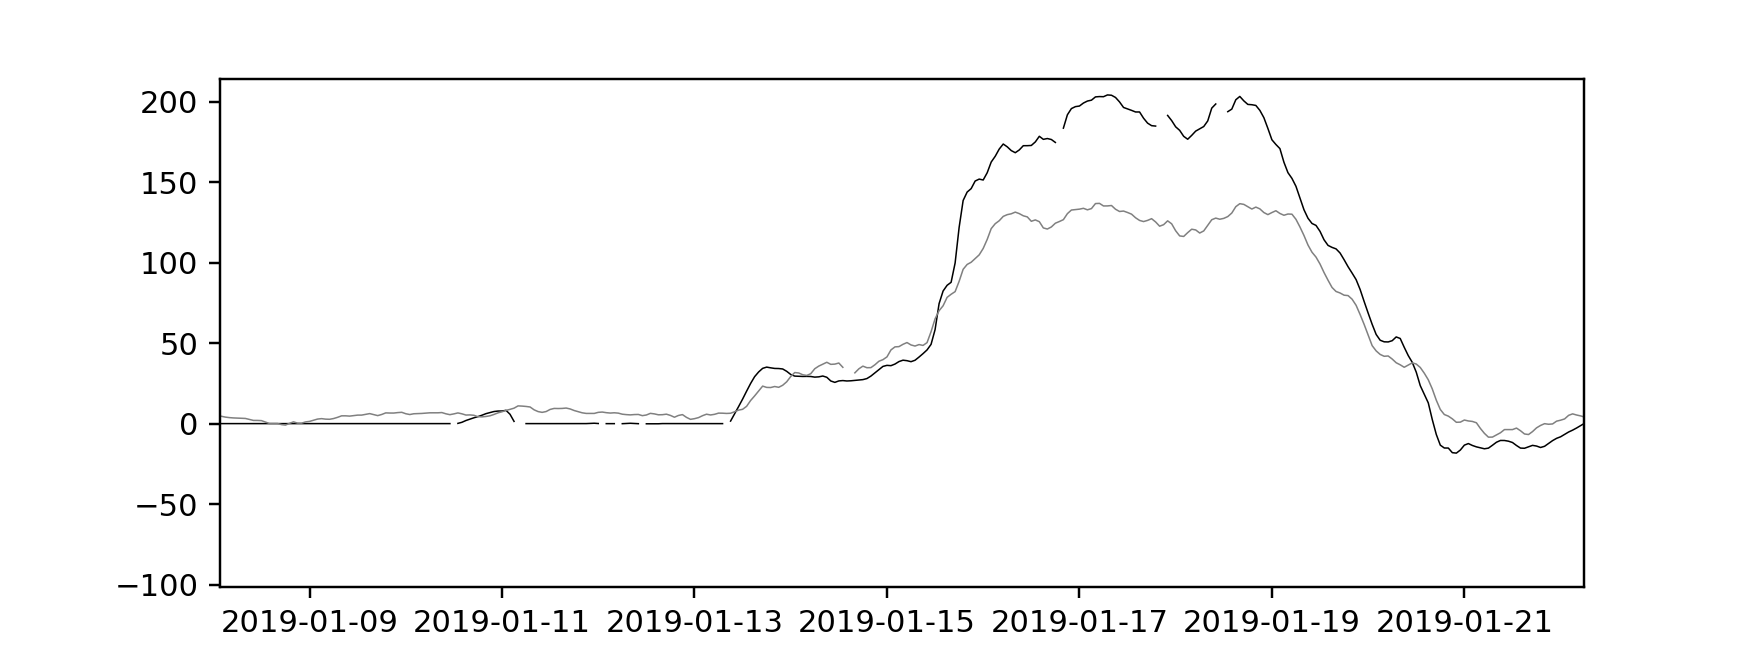

In [605]:
%matplotlib notebook

fig, ax= plt.subplots(figsize=(8,3))
plt.plot(ds3.time, ds3.se* units('m/s').to('km/day'), c='k', lw=0.5)
plt.plot(ds.time, ds.se.sel(depth=-10)* units('m/s').to('km/day'), c='gray', lw=0.5)

In [623]:
wind_angle

<Quantity([-165.65416   -166.94397   -168.34123   ...   14.4704       1.6910133
   -9.494447 ], 'degree')>

In [636]:


wind_angle = vectors.vector_angle(ds4.u10.values, ds4.v10.values)
wind_speed = np.sqrt(ds4.u10.values**2 + ds4.v10.values**2)

fd_ice_angle = wind_angle + 20 * units('degree')
fd_ice_speed = 0.02 * wind_speed

fd_ice_u = fd_ice_speed * np.cos(fd_ice_angle)
fd_ice_v = fd_ice_speed * np.sin(fd_ice_angle)
fd_ice_se = vectors.comp_along_theta(fd_ice_u, fd_ice_v, 135 * units('degree'))

# u_norm = u_sfc / icespeed
# v_norm = v_sfc / icespeed

# u_perp = - v_norm
# v_perp = u_norm

# along_sfc = vectors.comp_along_theta(ds.u, ds.v, scf_angle)
# perp_sfc  = vectors.comp_along_theta(ds.u, ds.v, scf_angle + 90*units('deg'))

<IPython.core.display.Javascript object>


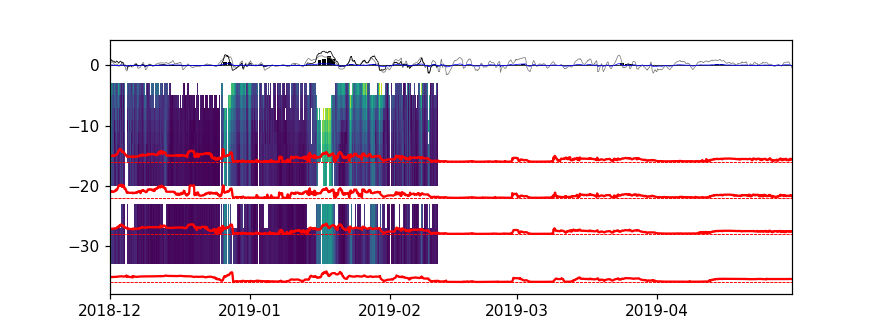

In [726]:
%matplotlib notebook

fig, ax= plt.subplots(figsize=(8,3))

# dudz = ds.u.diff('depth') / ds.depth.diff('depth')
# dvdz = ds.v.diff('depth') / ds.depth.diff('depth')
# shear = np.sqrt(dudz**2 + dvdz**2)

# plt.pcolormesh(ds.time, ds.depth.values[:-1], shear, vmin=0, vmax=0.1)

dudz = (ds3.u.values - ds.u) / ds.depth
dvdz = (ds3.v.values - ds.v) / ds.depth
shear = np.sqrt(dudz**2 + dvdz**2)
plt.pcolormesh(ds.time, ds.depth, shear,  vmin=0, vmax=0.1)



for depth in ds2.depth.values:
    plt.plot(ds2.time, 2*ds2.sel(depth=depth).dT +depth, c='r')
    plt.axhline(depth, c='r', lw=0.5, ls = 'dashed')
    plt.axhline(depth, c='r', lw=0.5, ls = 'dashed')

plt.axhline(0, c='k', lw=0.5)
plt.bar(DS.time, DS.extent/4000, align='edge', color='k')
plt.plot(ds4.time, ds4.se/10, c='gray', lw=0.5)
plt.plot(ds3.time, ds3.se, c='k', lw=0.5)

plt.plot(ds3.time, fd_ice_se, c='b', lw=0.5)


In [643]:
geomap

NameError: name 'geomap' is not defined

<IPython.core.display.Javascript object>


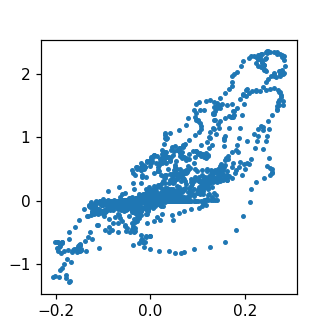

In [642]:
fig, ax= plt.subplots(figsize=(3,3))


ax.scatter(fd_ice_se, ds3.se, s=5)

In [558]:
z = -10
del_u = u_sfc #- ds.u.sel(depth = z) #- u_sfc
del_v = v_sfc #- ds.v.sel(depth = z) #- v_sfc
V = np.sqrt(del_u**2 + del_v**2)

uK = np.sqrt(0.0104 * V ** (1.78))

Text(0, 0.5, '$u_{*0}$')

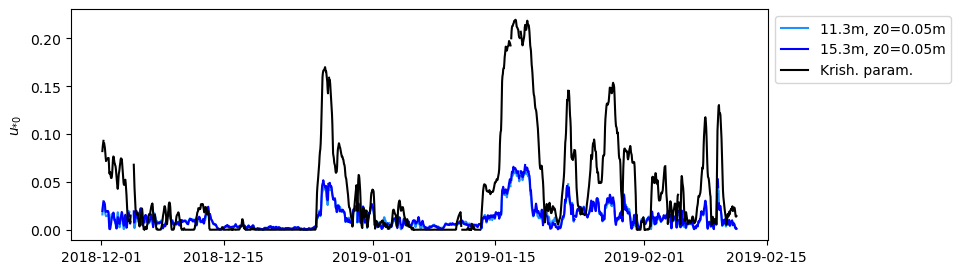

In [559]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(9,3))

# plt.plot(ds.time, us0[0.05][-30], label='30m, z0=0.05m', c='lightgray')
plt.plot(ds.time, us0[0.05][-10], label='11.3m, z0=0.05m', c='dodgerblue', )
plt.plot(ds.time, us0[0.05][-12], label='15.3m, z0=0.05m', c='blue', )

plt.plot(ds.time, uK, label='Krish. param.', c='k', )


# plt.plot(ds.time, us0[0.05][-6], label='6m, z0=0.05m', c='darkorange', alpha=0.75)

# ax.set_xlim(datetime(2017,12,1), datetime(2018,4,15))

plt.legend(bbox_to_anchor=(1,1))

plt.ylabel('$u_{*0}$')
# fig.savefig('/Users/mackenziejewell/Desktop/img.png', dpi=300, bbox_inches='tight')

<IPython.core.display.Javascript object>


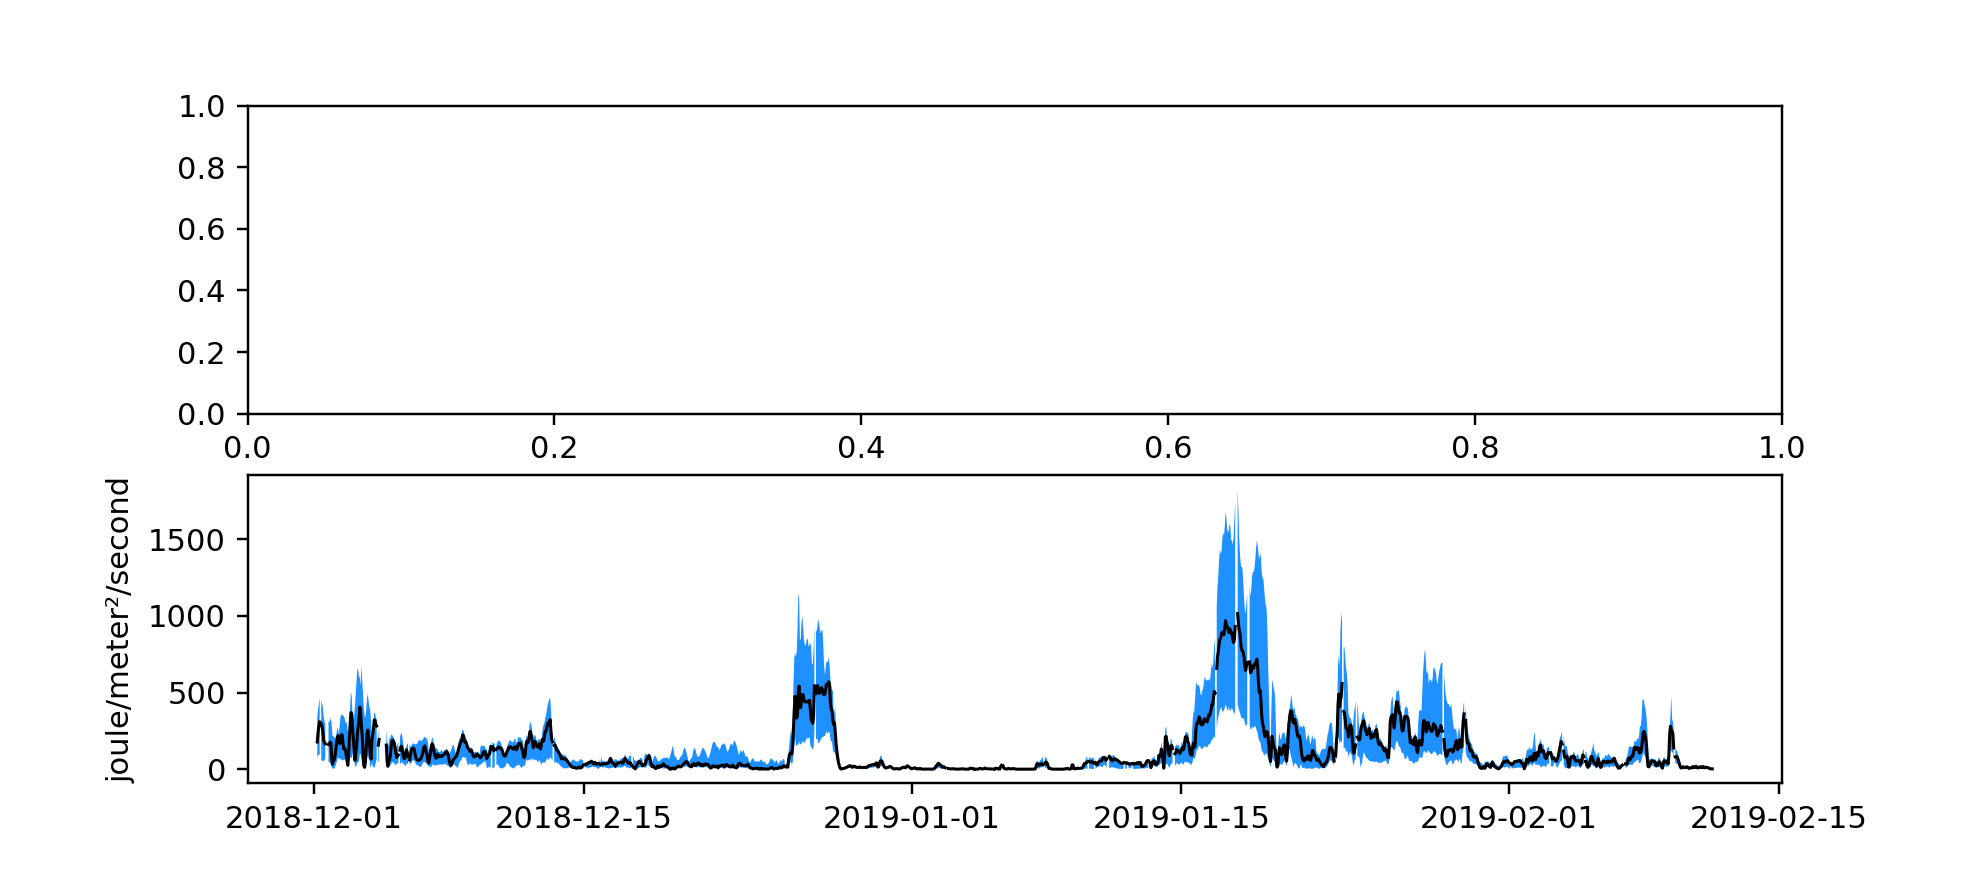

In [533]:
%matplotlib notebook
fig, axs = plt.subplots(2,1,figsize=(9,4))

plt.fill_between(ds.time, THF_min, THF_max, color='dodgerblue', lw=0)
plt.plot(ds.time, THF, c='k', lw=1)

<IPython.core.display.Javascript object>


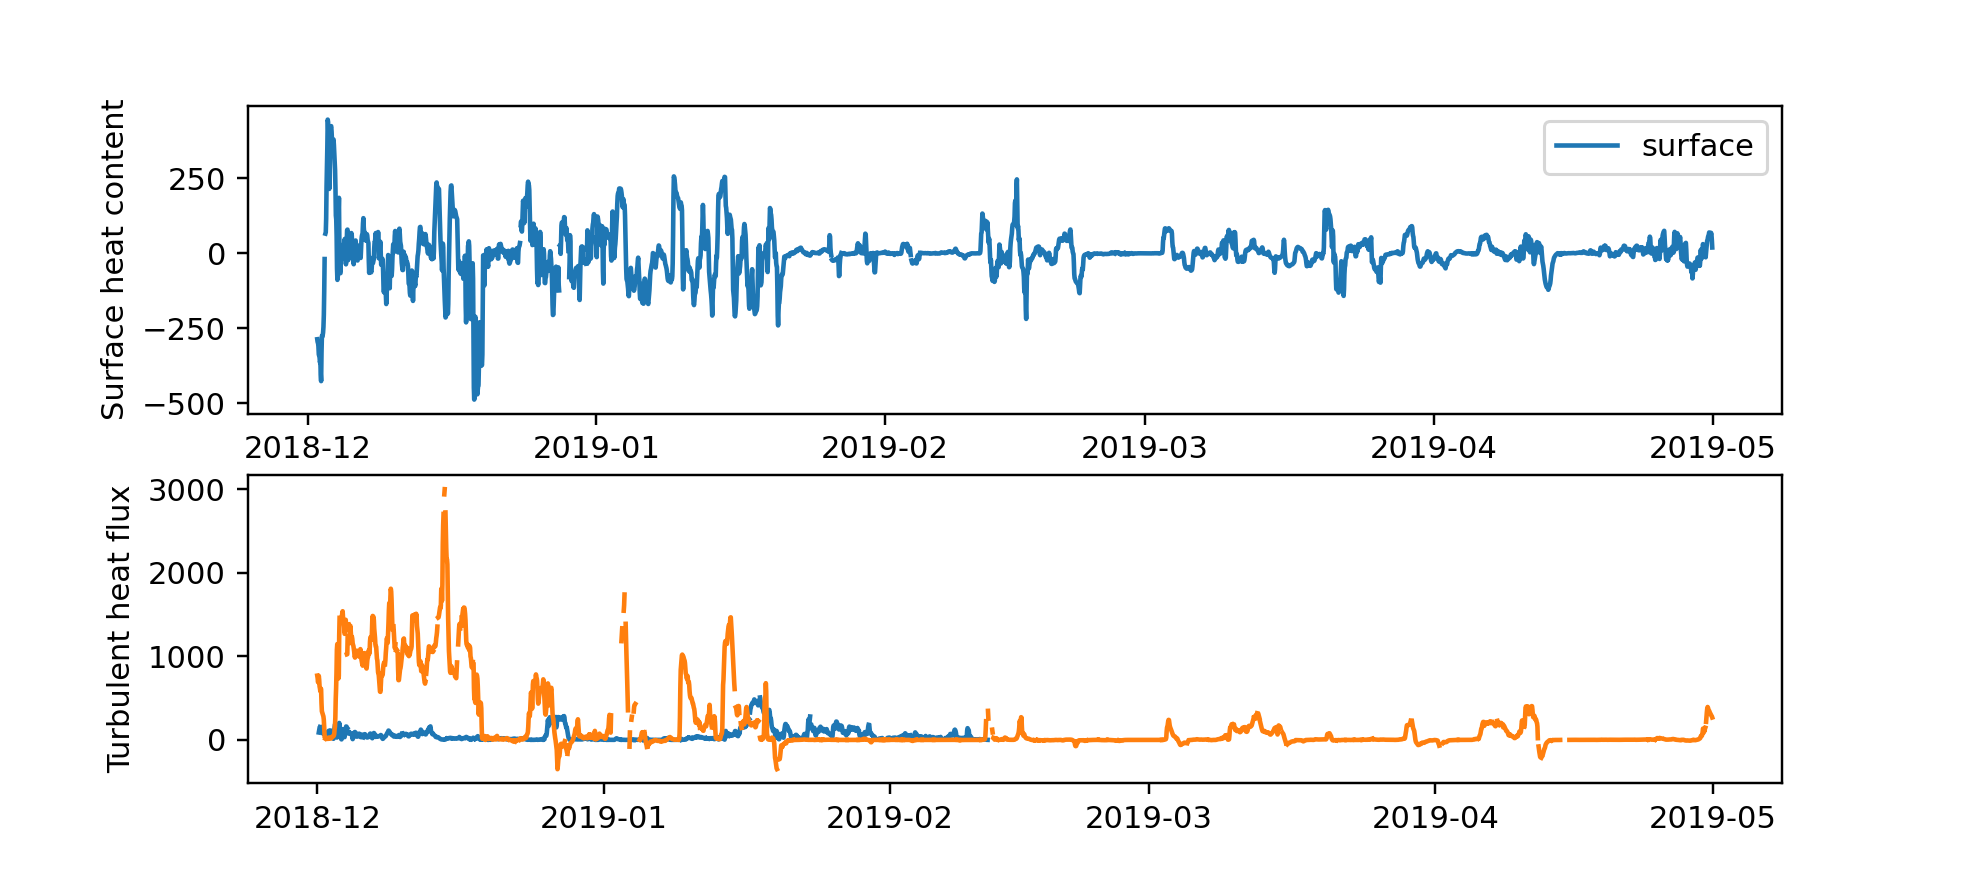

In [532]:
St = 0.0057

zT = -16

dT = (ds2.sel(depth=zT).dT).values * units('delta_degC')

us = us0[0.05][-10] * units('m/s')
THF = (cst['rho_o'] * cst['Cp_o'] * cst['St'] * us * dT)



THF_min = np.copy(THF)
THF_max = np.copy(THF)

for z in z_vals:
    
    for z0 in z0_vals:

        us = us0[z0][z] * units('m/s')
        THF_new = (cst['rho_o'] * cst['Cp_o'] * cst['St'] * us * dT)
        THF_min[THF_new<THF_min] = THF_new[THF_new<THF_min]
        THF_max[THF_new>THF_max] = THF_new[THF_new>THF_max]



%matplotlib notebook
fig, axs = plt.subplots(2,1,figsize=(9,4))

ax = axs[0]
# ax.plot(ds2.time, OHC[0,:])
lag = 24
ax.plot(ds2.time[lag:], (OHC[0,:][lag:] - OHC[0,:][:-lag])/(lag*60*60), label = 'surface')
ax.legend()
ax.set_ylabel('Surface heat content')


ax = axs[1]
# ax.plot(ds2.time[lag:], (OHC[0,:][lag:] - OHC[0,:][:-lag])/(lag*60*60*units('s')))
ax.plot(ds2.time, 0.5*THF)
ax.set_ylabel('Turbulent heat flux')

ax.plot(ds2.time, (1/3600)*trap_OHT/(16*units('m')))



In [1646]:
wind_angle = vectors.vector_angle(ds4.u10.values, ds4.v10.values)
wind_speed = np.sqrt(ds4.u10.values**2 + ds4.v10.values**2)



wf = 0.15
ta = 20*units('deg')

exp_ice_u = wf * wind_speed * np.cos(wind_angle + ta)
exp_ice_v = wf * wind_speed * np.sin(wind_angle + ta)

exp_ice_se = vectors.comp_along_theta(exp_ice_u, exp_ice_v, 135*units('deg'))





In [1652]:
# 0.2*wind_speed

<IPython.core.display.Javascript object>


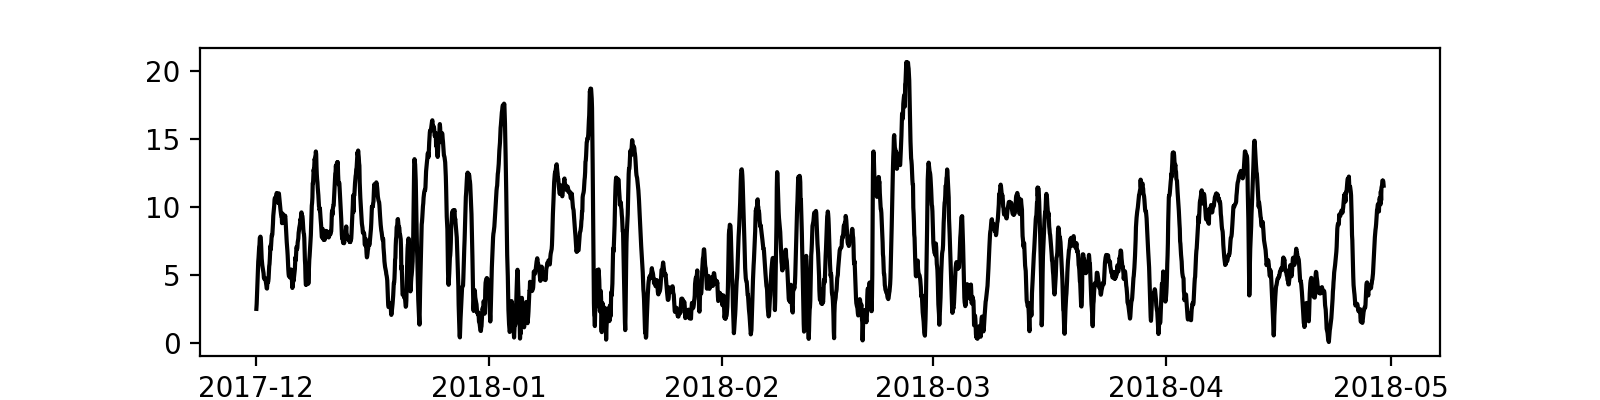

In [1660]:
%matplotlib notebook

fig, ax = plt.subplots(figsize=(8,2))

plt.plot(ds.time, wind_speed, c='k', label='wind')

In [1664]:
2 * (1/0.02)

100.0

<IPython.core.display.Javascript object>


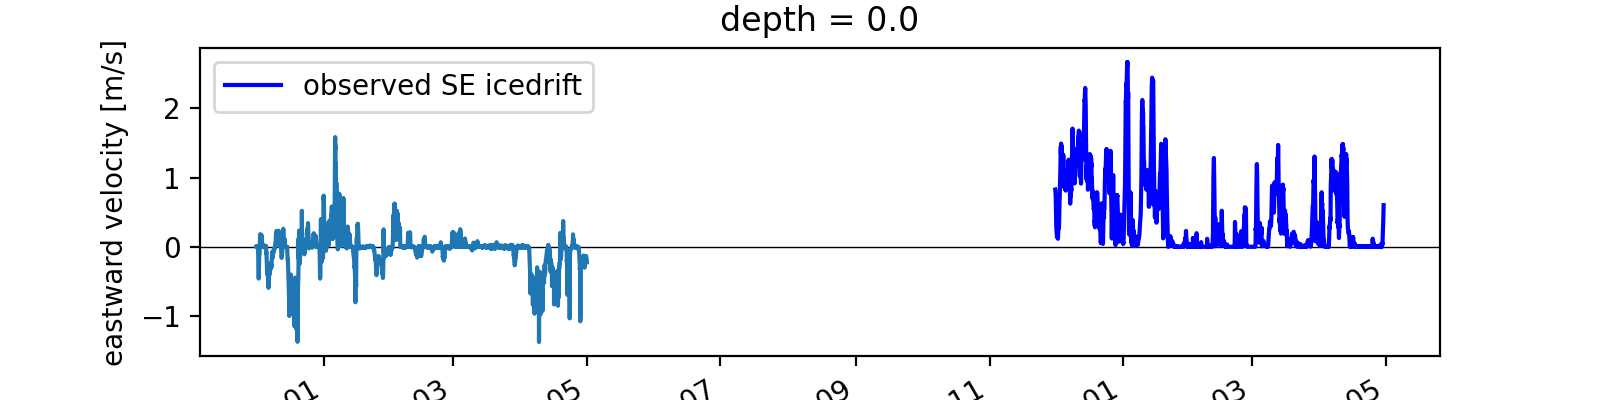

In [1661]:
%matplotlib notebook

fig, ax = plt.subplots(figsize=(8,2))

# plt.plot(ds.time, wind_speed, c='k', label='wind')

# plt.plot(ds.time, exp_ice_se, c='gray', label='expected SE ice drift (wind)')
# plt.plot(ds.time, ma.masked_where(wind_speed<3,np.sqrt(ds3.u**2+ds3.v**2)/wind_speed), c='b', label= 'observed SE icedrift')

plt.plot(ds.time, np.sqrt(ds3.u**2+ds3.v**2), c='b', label= 'observed SE icedrift')

plt.legend()
plt.axhline(0, c='k', zorder=-1, lw=0.5)

# ax2 = ax.twinx()
# ax2.plot(ds2.T.sel(depth=-16), c='r')
# plt.plot(ds4.se)

<IPython.core.display.Javascript object>


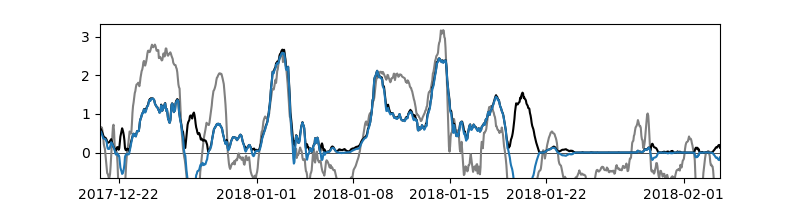

In [1520]:
%matplotlib notebook

fig, ax = plt.subplots(figsize=(8,2))

ax.axhline(0,c='k', zorder=-1, lw=0.5)

# ax.set_xlim(datetime(2017,12,1), datetime(2018,3,1))

# plt.plot(ds.time, 0.2*np.sqrt(ds4.u10**2+ds4.v10**2), c='gray')
plt.plot(ds.time, exp_ice, c='gray')

# plt.plot(ds.time, 0.15*ds4.se_rot20, c='lightgray')
plt.plot(ds.time, np.sqrt(ds3.u**2+ds3.v**2), c='k')

plt.plot(ds.time, ds3.se)

# plt.plot(ds.time, ds.se.sel(depth=-10), c='blue')
# plt.plot(ds.time, icespeed, c='k')




# ds2.dT.sel(depth=-16).plot()
# plt.plot(ds.time[td:], (ds2.dT.sel(depth=-16)[td:]).values-(ds2.dT.sel(depth=-16)[:-td]).values)



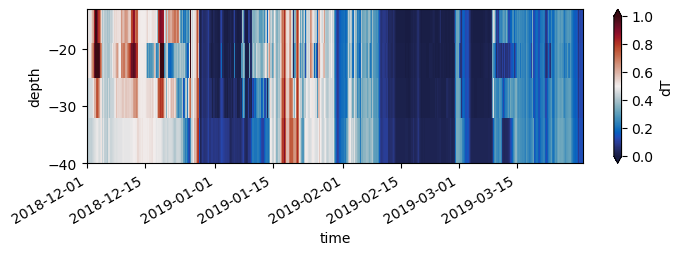

In [1464]:

fig, ax = plt.subplots(figsize=(8,2))

ds2.dT.plot(vmin=0, vmax=1, cmap=cmocean.cm.balance)

In [1440]:
ds2.dT.plot()

In [1404]:
ds2.sel(depth=-16).Ct

<xarray.DataArray 'Ct' (time: 3601)>
[3601 values with dtype=float64]
Coordinates:
    depth    float64 -16.0
  * time     (time) datetime64[ns] 2017-12-01 2017-12-01T01:00:00 ... 2018-04-30
Attributes:
    long_name:  Conservative temperature
    units:      degC

In [1380]:
trap_OHT

<Quantity([22287670.19561567 21728675.68262421 21122584.83847924 ...
  2000277.97990832  3259400.32654066  4518469.92499136], 'joule / meter / second')>